In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# print(os.getcwd())
# os.chdir('./GAN-Estimation-Uncertainty/uncertainty')

In [3]:
import numpy as np

In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
import torchvision
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
from tqdm import tqdm

In [5]:
# import seaborn as sea

### Useful sites:
1. [Torch-Uncertainty Library](https://github.com/ensta-u2is/torch-uncertainty)
   - A library for uncertainty estimation in deep learning, including deep learning baselines like Deep Ensembles, MC-Dropout, and more. The repository also provides tutorials.

2. [Awesome Uncertainty Deep Learning Repository](https://github.com/ENSTA-U2IS/awesome-uncertainty-deeplearning)
   - A collection of papers and resources related to Uncertainty and Deep Learning.

3. [Paper on Uncertainty Estimation](https://cds.cern.ch/record/2837844/files/2210.09767.pdf)
   - A paper from HSE describing how uncertainty estimation was applied to a GAN task in a physics experiment, specifically the LHCb experiment.


### Prepare test dataset

In [6]:
from datasets.sine import SinDataset

In [7]:
my_dataset = SinDataset(
                  train_data_length = 1024,
                  train_data_length_certain = 974,
                  multiplier_2 = 3
    
                )

# my_dataset = SinDataset(
#                   train_data_length = 990,
#                   train_data_length_certain = 990
#                 )


In [8]:
# my_dataset[:][1]

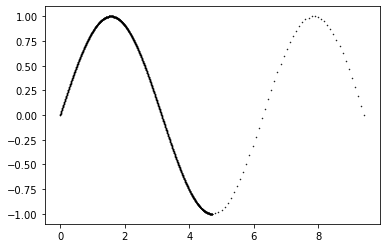

In [9]:
plt.plot(my_dataset[:][1], my_dataset[:][0], 'ko', markersize=0.5)

save_filename = os.path.join('datasets', 'sine')
plt.savefig(save_filename, dpi=300)

In [10]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(
    my_dataset, batch_size=BATCH_SIZE, shuffle=True
)

### GAN architecture
>start with basic simple cGAN

Define the GAN

>The GAN is designed such that a random latent number or vector is concatenated with a given variable 'x.' The GAN is then trained to learn the mapping from this combined input to the target variable 'y,' where 'y' is defined as the sine of 'x'

In [11]:
from modules.base_GAN import Base_Discriminator, Base_Generator, train
from modules.optimal_batch import WeightedIntervalCrossEntropyLoss
from modules.optimal_batch import create_batch, calculate_variance, weights_variances
from modules.animate import plot_sine
from modules.optimal_batch import calculate_MSE, calculate_metrics

In [12]:
from modules.optimal_batch import WeightedVarianceCrossEntropyLoss, variance4data

In [13]:
loss_f = WeightedVarianceCrossEntropyLoss()

In [14]:
from modules.mnist_models import CNNClassifierWrapper

In [115]:
# from modules.mnist_classifier import eval_model
# from modules.mnist_models import CNN, CNN2, CNN3
# CLASSIFIER = CNN3().to(device=device)
# PATH = './mnist_tests_classifier/classifier__CNN3__1_9_32/classifier_model.pt'
# CLASSIFIER.load_state_dict(torch.load(PATH))
D.eval()

Base_Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [23]:
class DWrapper:
    def __init__(self, model, layer_index=-1, use_global_pooling=False):
        self.model = model
        self.activation = {}
        self.base_transform = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
                        ])
        self.layer_index = layer_index
        self.model.model[self.layer_index].register_forward_hook(self.get_activation('extract'))
        self.use_global_pooling = use_global_pooling
        
    def get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output.detach()
        return hook
    
    def preprocess_image(self, image):
        # Apply transformations to the image
        preprocessed_image = self.base_transform(image)
        # .unsqueeze(0)  # Add batch dimension
        return preprocessed_image

    def __call__(self, image, info, transform = False):
        
        # Preprocess the image
        if transform:
            preprocessed_image = self.preprocess_image(image)
        output = self.model(image, info)
        output = self.activation['extract']
        
        if self.use_global_pooling:
            output = F.adaptive_avg_pool2d(output, (1, 1))

        output = output.view(output.size(0), -1)  # Flatten to (batch_size, num_channels)
        
        return output

In [24]:
def nvariance4data(generator,
                   discriminator_wrapper,
                   data_loader,
                   repeat: int = 20,
                   device='cpu'):
    variances = {}
    latent_space_samples = torch.randn(repeat, 1)
    for batch_idx, (x, info) in enumerate(data_loader):
        batch_size = x.size(0)
        x, info = x.to(device), info.to(device)
        for el in info:
            with torch.no_grad():
                res = generator(latent_space_samples, el.repeat(repeat, 1))
                # print()
                res = discriminator_wrapper(res, el.repeat(repeat, 1))
                variance = torch.var(res, dim=0)
                variances[el.item()] = torch.sum(variance).item()
                
                
    def variances2weights(variances: dict):
        """
        Convert dict of variances to dict of weights,
        so, the max weight is 1 for max value of variances and 0 if variance is 0
        """
        max_variance = max(variances.values())
        weights = {key: max(0.01, value / max_variance) for key, value in variances.items()} 
        # print(weights)
        return weights


    return variances2weights(variances)

In [66]:
# plt.bar(nvariance4data(G, FEATURE_EXTRACTOR, train_loader))

In [34]:
# FEATURE_EXTRACTOR = CNNClassifierWrapper(D, layer_index = -3, use_global_pooling = False)
FEATURE_EXTRACTOR = DWrapper(D, layer_index = -5, use_global_pooling = False)

In [33]:
# img_example = torch.rand(32, 1, 28, 28)  #image 28 on 28 with 1 chanel like in mnist
for a, b in train_loader:
    break
    
z = torch.randn(a.size(0), 1)
x_fake, y_fake = G(z, b.view(-1, 1)).view(-1, 1), torch.zeros(a.size(0), 1) 
print(x_fake.size(), b.view(-1, 1).size())
print(D(x_fake, b.view(-1, 1)).size())
print(FEATURE_EXTRACTOR(x_fake, b.view(-1, 1)).size())

torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 128])


In [137]:
# x_fake
# y_fake

In [144]:
# D.eval
# D(b)
# D(x_fake, b.view(-1, 1))


In [19]:
for a, b in train_loader:
    break

In [19]:
# a = variance4data(G, train_loader)
# for batch_idx, (x, info) in enumerate(train_loader):
#     batch_size = x.size(0)
#     x, info = x.to(device), info.to(device)
#     break
    
# G.zero_grad()

# z = torch.randn(x.size(0), 1).to(device)
# y = torch.ones(x.size(0), 1).to(device)
# G_output = G(z, info.view(-1, 1)).view(-1, 1)
    
# D_output = D(G_output, info.view(-1, 1))

# G_loss = loss_f(D_output, y.to(device), weights = a, conditional_info = info.view(-1, 1))
# G_loss

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [15]:
D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)

In [16]:
#model parametrs
# learning_rate_G = 0.0001
# learning_rate_D = 0.0004
# lr = 0.001
lr = 0.0001
NUM_EPOCHS = 1000
NUM_BATCHES = math.ceil(len(train_loader.dataset)/train_loader.batch_size)
print(f'NUM_BATCHES: {NUM_BATCHES}')

NUM_BATCHES: 32


In [17]:
NUM_BATCHES = math.ceil(len(train_loader.dataset)/train_loader.batch_size)
print(f'NUM_BATCHES: {NUM_BATCHES}')

NUM_BATCHES: 32


In [18]:
# loss_function = nn.BCELoss()
loss_function = WeightedIntervalCrossEntropyLoss()

In [18]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# D_optimizer = optim.Adam(D.parameters(), lr=learning_rate_G, betas=(0.5, 0.999))
# G_optimizer = optim.Adam(G.parameters(), lr=learning_rate_D, betas=(0.5, 0.999))

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR

max_lr = 0.0005

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 8001)
# scheduler_D = CosineAnnealingWarmRestarts(D_optimizer, T_0 = 16001)
# scheduler_G = CosineAnnealingWarmRestarts(G_optimizer, T_0 = 16001)

NameError: name 'D' is not defined

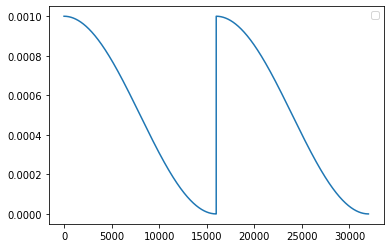

In [722]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
EPOCHS = 1000
BATCHES = 32
steps = []
lrs = []
model = Base_Discriminator().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 960)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 16001)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

plt.figure()
plt.legend()
plt.plot(steps, lrs, label='OneCycle')
plt.show()

/Users/serafim/Library/Python/3.8/lib/python/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


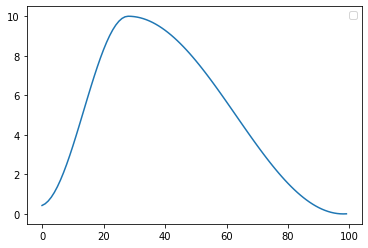

In [15]:
EPOCHS = 10
BATCHES = 10
steps = []
lrs = []
model = Base_Discriminator().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=10,total_steps=EPOCHS * BATCHES)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

plt.figure()
plt.legend()
plt.plot(steps, lrs, label='OneCycle')
plt.show()

In [658]:
# lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
#                                                num_warmup_steps=num_warmup_steps,
#                                                num_training_steps=len(train_dataloader) * num_epochs)

In [151]:
calculate_metrics(G, D)

(0.5447544772209075,
 0.516249748140719,
 0.0003296025966919842,
 0.00011212450086168246,
 6.998561790466309,
 6.826826241970062)

In [53]:
# G.eval
torch.tensor(torch.linspace(0, math.pi, 10)[3].item())

tensor(1.0472)

In [71]:
# calculate_MSE

In [77]:
calculate_MSE(G)


(0.03563845444087544, 0.6326510818618002)

In [79]:
calculate_MSE(G)

(0.03466253470968, 0.6587069528328023)

### Training

In [24]:
# NAME = 'base_gan__variance__2_5'
# NAME = 'base_gan__1_1'
# NAME = 'base_gan__1_1'
# NAME = 'base_gan__variance_10_split__any_wieights__2_1'
# NAME = 'base_gan__variance_2_split__accurate_wieights__3_1'
# NAME = 'base_gan__sin_confidence_all__variance_10_split__accurate_wieights__8_1'
# NAME = 'base_gan__sin_confidence_all_1,5_pi__variance_10_split__accurate_wieights__9_1'
# NAME = 'base_gan__lr_0,0001__10_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights_0,01__lr_0,0001__12_1'
# NAME = 'base_gan__part_dataset__lr_0,0001__9_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights_0,01_OneCycleLR__lr_0,0005__1_1'

save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'

In [19]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR
-np.log(1)
# # %matplotlib inline
# %config InlineBackend.close_figures = False

-0.0

In [141]:
# torch.var()
a = np.array([[1, 1, 1, 2, 2, 2]])
np.var(a)

0.25

In [19]:
# NUM_EPOCHS
from modules.base_GAN import DWrapper, nvariance4data

In [57]:
FEATURE_EXTRACTOR = DWrapper(G, layer_index=-2, use_global_pooling=False)
FEATURE_EXTRACTOR.register_hook()  # Register the hook

In [58]:
# b

In [59]:
for a, b in train_loader:
    break
z = torch.randn(a.size(0), 1).to(device)
print(z.size())
# y = torch.ones(x.size(0), 1).to(device)
#     # print(z.size(), y.size())
    
#     # fake_info = 2 * math.pi * torch.rand(x.size(0)).view(-1, 1).to(device)#fake info maybe is crooectly to take from data or from the same distribution, with the same density
# G_output = G(z, info.view(-1, 1)).view(-1, space_dimension)

    # weights = nvariance4data(G, FEATURE_EXTRACTOR, data_loader)
    # FEATURE_EXTRACTOR.remove_hook()  
FEATURE_EXTRACTOR(z, b.view(-1, 1)).size()

torch.Size([32, 1])


torch.Size([32, 32])

In [27]:
a

tensor([ 0.4911, -0.7246, -0.9085,  0.0678, -0.3613, -0.0307,  0.0484,  0.2099,
         0.6533,  0.9936, -0.1031,  0.0081,  0.7918,  0.9956,  0.8177, -0.8385,
         0.5797,  0.0145,  0.9491,  0.0048,  0.3173,  0.9867,  0.7223,  0.6005,
         0.8713,  0.2476,  0.9859,  0.8006,  0.5162, -0.1279,  0.6335,  0.4178])

In [68]:
# import time
# ts = []

# for i in tqdm(range(1000)):
#     t1 = time.time()
    
#     # FEATURE_EXTRACTOR.to(device)
#     FEATURE_EXTRACTOR = DWrapper(D, layer_index = -5, use_global_pooling = False)
#     weights = nvariance4data(G, FEATURE_EXTRACTOR, train_loader, device = 'cpu')
#     torch.cuda.empty_cache()
#     ts.append(time.time() - t1)
#     FEATURE_EXTRACTOR.activation = {}
#     # print(time.time() - t1)
    
ts = []
for i in tqdm(range(300)):
    t1 = time.time()
    FEATURE_EXTRACTOR = DWrapper(D, layer_index=-5, use_global_pooling=False)
    FEATURE_EXTRACTOR.register_hook()  # Register the hook
    weights = nvariance4data(G, FEATURE_EXTRACTOR, train_loader)
    FEATURE_EXTRACTOR.remove_hook()  # Remove the hook when done
    ts.append(time.time() - t1)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [02:32<00:00,  1.97it/s]


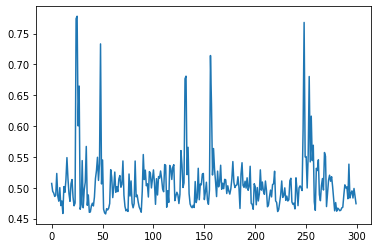

In [69]:
plt.plot(ts)

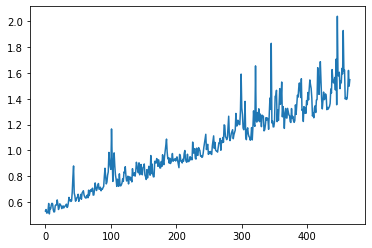

In [43]:
# plt.bar(ts)

plt.plot(ts)

In [60]:
lr = 0.0001
NUM_EPOCHS = 5000

loss_function = WeightedIntervalCrossEntropyLoss()
D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

NAME = f'base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__2'
# Adjust these parameters as needed
max_lr = 0.0005 
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


In [46]:
lr = 0.0001
NUM_EPOCHS = 5000

loss_function = WeightedVarianceCrossEntropyLoss()
# loss_function = WeightedIntervalCrossEntropyLoss()
D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

NAME = f'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__6'
# Adjust these parameters as needed
max_lr = 0.0005 
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


In [47]:
D_losses_final, G_losses_final, Variances, Weights_variance, s = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 10,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200,
)
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__6' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.5039, average G_loss: 0.5340


  4%|██████▍                                                                                                                                                           | 200/5000 [04:05<1:36:54,  1.21s/it]

epoch [200/5000], average D_loss: 0.3974, average G_loss: 0.5497


  8%|████████████▉                                                                                                                                                     | 400/5000 [08:11<1:33:28,  1.22s/it]

epoch [400/5000], average D_loss: 0.2492, average G_loss: 0.2511


 12%|███████████████████▍                                                                                                                                              | 600/5000 [12:18<1:30:00,  1.23s/it]

epoch [600/5000], average D_loss: 0.2032, average G_loss: 0.2115


 16%|█████████████████████████▉                                                                                                                                        | 800/5000 [16:26<1:26:30,  1.24s/it]

epoch [800/5000], average D_loss: 0.0863, average G_loss: 0.0873


 20%|████████████████████████████████▏                                                                                                                                | 1000/5000 [20:34<1:22:28,  1.24s/it]

epoch [1000/5000], average D_loss: 0.0805, average G_loss: 0.0811


 24%|██████████████████████████████████████▋                                                                                                                          | 1200/5000 [24:42<1:19:20,  1.25s/it]

epoch [1200/5000], average D_loss: 0.0640, average G_loss: 0.0648


 28%|█████████████████████████████████████████████                                                                                                                    | 1400/5000 [28:50<1:14:43,  1.25s/it]

epoch [1400/5000], average D_loss: 0.0173, average G_loss: 0.0172


 32%|███████████████████████████████████████████████████▌                                                                                                             | 1600/5000 [32:59<1:09:58,  1.23s/it]

epoch [1600/5000], average D_loss: 0.0377, average G_loss: 0.0378


 36%|█████████████████████████████████████████████████████████▉                                                                                                       | 1800/5000 [37:07<1:05:21,  1.23s/it]

epoch [1800/5000], average D_loss: 0.0245, average G_loss: 0.0243


 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 2000/5000 [41:16<1:01:53,  1.24s/it]

epoch [2000/5000], average D_loss: 0.0306, average G_loss: 0.0308


 44%|███████████████████████████████████████████████████████████████████████▋                                                                                           | 2200/5000 [45:25<58:27,  1.25s/it]

epoch [2200/5000], average D_loss: 0.0188, average G_loss: 0.0189


 48%|██████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2400/5000 [49:34<53:39,  1.24s/it]

epoch [2400/5000], average D_loss: 0.0224, average G_loss: 0.0225


 52%|████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 2600/5000 [53:43<49:26,  1.24s/it]

epoch [2600/5000], average D_loss: 0.0201, average G_loss: 0.0208


 56%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2800/5000 [57:52<44:57,  1.23s/it]

epoch [2800/5000], average D_loss: 0.0224, average G_loss: 0.0275


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 3000/5000 [1:02:01<41:52,  1.26s/it]

epoch [3000/5000], average D_loss: 0.0257, average G_loss: 0.0327


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 3200/5000 [1:06:11<36:57,  1.23s/it]

epoch [3200/5000], average D_loss: 0.0263, average G_loss: 0.0333


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3400/5000 [1:10:20<33:24,  1.25s/it]

epoch [3400/5000], average D_loss: 0.0232, average G_loss: 0.0375


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3600/5000 [1:14:31<28:56,  1.24s/it]

epoch [3600/5000], average D_loss: 0.0240, average G_loss: 0.0560


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3800/5000 [1:18:41<24:49,  1.24s/it]

epoch [3800/5000], average D_loss: 0.0186, average G_loss: 0.0552


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4000/5000 [1:22:51<20:36,  1.24s/it]

epoch [4000/5000], average D_loss: 0.0176, average G_loss: 0.0524


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4200/5000 [1:27:03<16:52,  1.27s/it]

epoch [4200/5000], average D_loss: 0.0191, average G_loss: 0.0533


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4400/5000 [1:31:14<12:23,  1.24s/it]

epoch [4400/5000], average D_loss: 0.0190, average G_loss: 0.0708


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 4600/5000 [1:35:25<08:15,  1.24s/it]

epoch [4600/5000], average D_loss: 0.0155, average G_loss: 0.0771


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4800/5000 [1:39:35<04:06,  1.23s/it]

epoch [4800/5000], average D_loss: 0.0172, average G_loss: 0.0536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:46<00:00,  1.25s/it]


In [44]:
D_losses_final, G_losses_final, Variances, Weights_variance, s = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 10,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200,
)
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__5' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.2053, average G_loss: 0.1942


  4%|██████▍                                                                                                                                                           | 200/5000 [04:09<1:37:02,  1.21s/it]

epoch [200/5000], average D_loss: 0.4097, average G_loss: 0.5362


  8%|████████████▉                                                                                                                                                     | 400/5000 [08:17<1:34:23,  1.23s/it]

epoch [400/5000], average D_loss: 0.2781, average G_loss: 0.3047


 12%|███████████████████▍                                                                                                                                              | 600/5000 [12:25<1:30:33,  1.23s/it]

epoch [600/5000], average D_loss: 0.1207, average G_loss: 0.2465


 16%|█████████████████████████▉                                                                                                                                        | 800/5000 [16:34<1:27:51,  1.26s/it]

epoch [800/5000], average D_loss: 0.0350, average G_loss: 0.0361


 20%|████████████████████████████████▏                                                                                                                                | 1000/5000 [20:43<1:24:25,  1.27s/it]

epoch [1000/5000], average D_loss: 0.0278, average G_loss: 0.0299


 24%|██████████████████████████████████████▋                                                                                                                          | 1200/5000 [24:51<1:18:23,  1.24s/it]

epoch [1200/5000], average D_loss: 0.0328, average G_loss: 0.0370


 28%|█████████████████████████████████████████████                                                                                                                    | 1400/5000 [29:00<1:13:52,  1.23s/it]

epoch [1400/5000], average D_loss: 0.0265, average G_loss: 0.0366


 32%|███████████████████████████████████████████████████▌                                                                                                             | 1600/5000 [33:09<1:10:02,  1.24s/it]

epoch [1600/5000], average D_loss: 0.0497, average G_loss: 0.0579


 36%|█████████████████████████████████████████████████████████▉                                                                                                       | 1800/5000 [37:18<1:07:15,  1.26s/it]

epoch [1800/5000], average D_loss: 0.0405, average G_loss: 0.0596


 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 2000/5000 [41:27<1:01:53,  1.24s/it]

epoch [2000/5000], average D_loss: 0.0233, average G_loss: 0.0289


 44%|███████████████████████████████████████████████████████████████████████▋                                                                                           | 2200/5000 [45:37<57:33,  1.23s/it]

epoch [2200/5000], average D_loss: 0.0255, average G_loss: 0.0319


 48%|██████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2400/5000 [49:47<53:35,  1.24s/it]

epoch [2400/5000], average D_loss: 0.0293, average G_loss: 0.0327


 52%|████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 2600/5000 [53:59<49:49,  1.25s/it]

epoch [2600/5000], average D_loss: 0.0320, average G_loss: 0.0359


 56%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 2800/5000 [58:08<45:20,  1.24s/it]

epoch [2800/5000], average D_loss: 0.0232, average G_loss: 0.0224


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 3000/5000 [1:02:18<42:01,  1.26s/it]

epoch [3000/5000], average D_loss: 0.0324, average G_loss: 0.0329


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 3200/5000 [1:06:27<37:17,  1.24s/it]

epoch [3200/5000], average D_loss: 0.0164, average G_loss: 0.0191


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3400/5000 [1:10:36<33:07,  1.24s/it]

epoch [3400/5000], average D_loss: 0.0206, average G_loss: 0.0218


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3600/5000 [1:14:44<28:52,  1.24s/it]

epoch [3600/5000], average D_loss: 0.0554, average G_loss: 0.0549


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3800/5000 [1:18:53<24:42,  1.24s/it]

epoch [3800/5000], average D_loss: 0.0626, average G_loss: 0.0631


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4000/5000 [1:23:05<20:27,  1.23s/it]

epoch [4000/5000], average D_loss: 0.0526, average G_loss: 0.0557


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4200/5000 [1:27:14<16:25,  1.23s/it]

epoch [4200/5000], average D_loss: 0.0370, average G_loss: 0.0383


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4400/5000 [1:31:30<12:42,  1.27s/it]

epoch [4400/5000], average D_loss: 0.0442, average G_loss: 0.0461


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 4600/5000 [1:35:40<08:25,  1.26s/it]

epoch [4600/5000], average D_loss: 0.0403, average G_loss: 0.0424


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4800/5000 [1:39:49<04:12,  1.26s/it]

epoch [4800/5000], average D_loss: 0.0217, average G_loss: 0.0236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:59<00:00,  1.25s/it]


In [ ]:
import matplotlib.pyplot as plt

# Define a function to plot the metrics
def plot_metrics(metrics: List[Tuple[float, float, float, float, float, float]], title: str):
    epochs = range(1, len(metrics) + 1)
    
    mse1_values = [m[0] for m in metrics]
    mse2_values = [m[1] for m in metrics]
    var1_values = [m[2] for m in metrics]
    var2_values = [m[3] for m in metrics]
    entropy1_values = [m[4] for m in metrics]
    entropy2_values = [m[5] for m in metrics]
    
    # Plot the metrics
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3, 2, 1)
    # plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, mse1_values, 'b', label='MSE1')
    plt.title('MSE1')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 2)
    plt.plot(epochs, mse2_values, 'r', label='MSE2')
    plt.title('MSE2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(3, 2, 3)
    # plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, var1_values, 'g', label='Var1')
    plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values, 'c', label='Var2')
    plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(3, 2, 5)
    plt.plot(epochs, entropy1_values, 'm', label='Entropy1')
    plt.title('Entropy1')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 6)
    plt.plot(epochs, entropy2_values, 'y', label='Entropy2')
    plt.title('Entropy2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# Example usage
plot_metrics(s, 'Metrics Over Training')


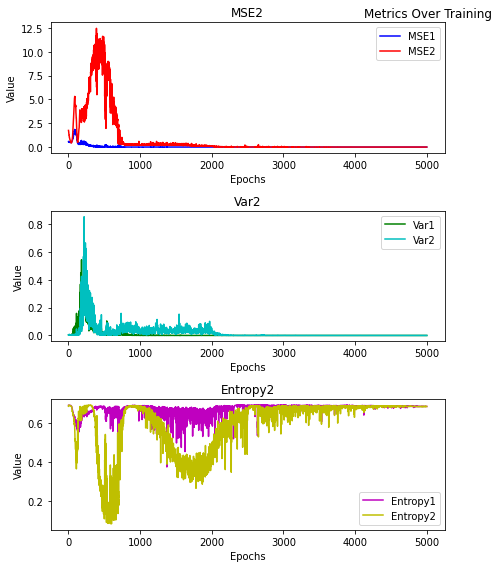

In [90]:
import matplotlib.pyplot as plt

# Define a function to plot the metrics
def plot_metrics(metrics: List[Tuple[float, float, float, float, float, float]], title: str):
    epochs = range(1, len(metrics) + 1)
    
    mse1_values = [m[0] for m in metrics]
    mse2_values = [m[1] for m in metrics]
    var1_values = [m[2] for m in metrics]
    var2_values = [m[3] for m in metrics]
    entropy1_values = [m[4] for m in metrics]
    entropy2_values = [m[5] for m in metrics]
    
    # Plot the metrics
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3, 2, 1)
    # plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, mse1_values, 'b', label='MSE1')
    plt.title('MSE1')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 2)
    plt.plot(epochs, mse2_values, 'r', label='MSE2')
    plt.title('MSE2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(3, 2, 3)
    # plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, var1_values, 'g', label='Var1')
    plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values, 'c', label='Var2')
    plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(3, 2, 5)
    plt.plot(epochs, entropy1_values, 'm', label='Entropy1')
    plt.title('Entropy1')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 6)
    plt.plot(epochs, entropy2_values, 'y', label='Entropy2')
    plt.title('Entropy2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# Example usage
plot_metrics(s, 'Metrics Over Training')


In [81]:
with open('/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__2/metrics.pkl', 'wb') as f:
    pickle.dump(s, f)

In [35]:
# s

In [51]:
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = nn.BCELoss()
max_lr = 0.0005

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
NAME = f'base_gan__lr_0,001_OneCycleLR__7'

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance, ss = train(
        num_epochs = NUM_EPOCHS,
        data_loader = train_loader,
        D = D,
        G = G,
        D_optimizer = D_optimizer,
        G_optimizer = G_optimizer, 
        criterion = loss_function,
        device = device,
        plot_process = True,
        save_path = save_path,
        name = f'{NAME}',
        weights_interval = False,
        # plot_info = True,
        animate_bar_var = True,
        progress_generator = True,
        scheduler_D = scheduler_D,
        scheduler_G = scheduler_G,
        info_n = NUM_EPOCHS,
        # save_mse = 'G_mse.pkl'
        # n_split = 10
    )

Folder 'base_gan__lr_0,001_OneCycleLR__7' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6946, average G_loss: 0.6384


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:42:11<00:00,  1.23s/it]


In [52]:
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = nn.BCELoss()
max_lr = 0.0005

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
NAME = f'base_gan__lr_0,001_OneCycleLR__8'

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance, ss = train(
        num_epochs = NUM_EPOCHS,
        data_loader = train_loader,
        D = D,
        G = G,
        D_optimizer = D_optimizer,
        G_optimizer = G_optimizer, 
        criterion = loss_function,
        device = device,
        plot_process = True,
        save_path = save_path,
        name = f'{NAME}',
        weights_interval = False,
        # plot_info = True,
        animate_bar_var = True,
        progress_generator = True,
        scheduler_D = scheduler_D,
        scheduler_G = scheduler_G,
        info_n = NUM_EPOCHS,
        # save_mse = 'G_mse.pkl'
        # n_split = 10
    )

Folder 'base_gan__lr_0,001_OneCycleLR__8' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.7005, average G_loss: 0.7491


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:42:44<00:00,  1.23s/it]


In [53]:
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = nn.BCELoss()
max_lr = 0.0005

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
NAME = f'base_gan__lr_0,001_OneCycleLR__9'

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance, ss = train(
        num_epochs = NUM_EPOCHS,
        data_loader = train_loader,
        D = D,
        G = G,
        D_optimizer = D_optimizer,
        G_optimizer = G_optimizer, 
        criterion = loss_function,
        device = device,
        plot_process = True,
        save_path = save_path,
        name = f'{NAME}',
        weights_interval = False,
        # plot_info = True,
        animate_bar_var = True,
        progress_generator = True,
        scheduler_D = scheduler_D,
        scheduler_G = scheduler_G,
        info_n = NUM_EPOCHS,
        # save_mse = 'G_mse.pkl'
        # n_split = 10
    )

Folder 'base_gan__lr_0,001_OneCycleLR__9' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6990, average G_loss: 0.7308


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:35<00:00,  1.24s/it]


In [54]:
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = nn.BCELoss()
max_lr = 0.0005

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
NAME = f'base_gan__lr_0,001_OneCycleLR__10'

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance, ss = train(
        num_epochs = NUM_EPOCHS,
        data_loader = train_loader,
        D = D,
        G = G,
        D_optimizer = D_optimizer,
        G_optimizer = G_optimizer, 
        criterion = loss_function,
        device = device,
        plot_process = True,
        save_path = save_path,
        name = f'{NAME}',
        weights_interval = False,
        # plot_info = True,
        animate_bar_var = True,
        progress_generator = True,
        scheduler_D = scheduler_D,
        scheduler_G = scheduler_G,
        info_n = NUM_EPOCHS,
        # save_mse = 'G_mse.pkl'
        # n_split = 10
    )

Folder 'base_gan__lr_0,001_OneCycleLR__10' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6930, average G_loss: 0.6553


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:42:51<00:00,  1.23s/it]


In [186]:
# ss

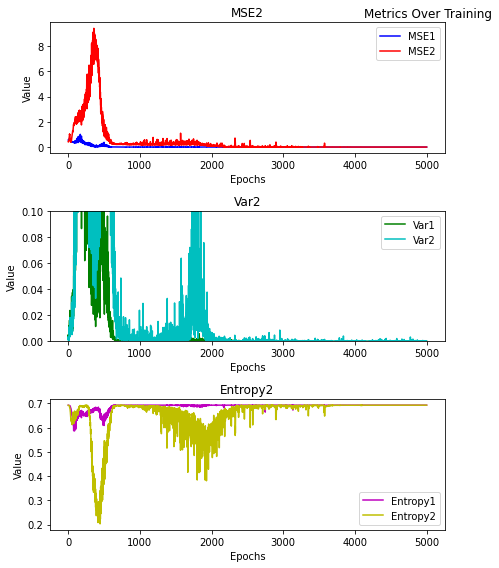

In [257]:
import matplotlib.pyplot as plt

# Define a function to plot the metrics
def plot_metrics(metrics: List[Tuple[float, float, float, float, float, float]], title: str):
    epochs = range(1, len(metrics) + 1)
    
    mse1_values = [m[0] for m in metrics]
    mse2_values = [m[1] for m in metrics]
    var1_values = [m[2] for m in metrics]
    var2_values = [m[3] for m in metrics]
    entropy1_values = [m[4] for m in metrics]
    entropy2_values = [m[5] for m in metrics]
    
    # Plot the metrics
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3, 2, 1)
    # plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, mse1_values, 'b', label='MSE1')
    plt.title('MSE1')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 2)
    plt.plot(epochs, mse2_values, 'r', label='MSE2')
    plt.title('MSE2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(3, 2, 3)
    plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, var1_values, 'g', label='Var1')
    plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values, 'c', label='Var2')
    plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(3, 2, 5)
    plt.plot(epochs, entropy1_values, 'm', label='Entropy1')
    plt.title('Entropy1')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 6)
    plt.plot(epochs, entropy2_values, 'y', label='Entropy2')
    plt.title('Entropy2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# Example usage
plot_metrics(s, 'Metrics Over Training')


In [ ]:
with open('/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/base_gan__lr_0,001_OneCycleLR__2/metrics.pkl', 'wb') as f:
    pickle.dump(s, f)

In [262]:
with open('/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__2/metrics.pkl', 'wb') as f:
    pickle.dump(s, f)

In [62]:
# import pickle
# with open('/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/base_gan__lr_0,001_OneCycleLR__2/metrics.pkl', 'rb') as f:
#     ss = pickle.load(f)
    
# with open('/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/base_gan__lr_0,001_OneCycleLR__2/metrics.pkl', 'rb') as f:
    # mynewlist = pickle.load(f)
    
filename = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/base_gan__lr_0,001_OneCycleLR__2/metrics.pkl'
filename = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__2/metrics.pkl'
filename = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/base_gan__lr_0,001_OneCycleLR__1/metrics.pkl'
with open(filename, 'rb') as f:
    classification_dict = pickle.load(f)

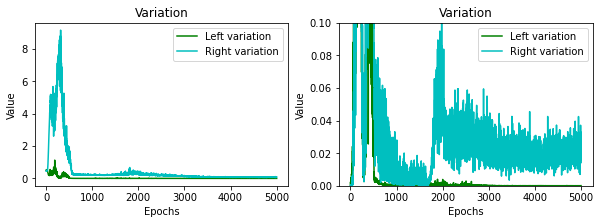

In [78]:
# plot_metrics(ss, 'Variation')
import matplotlib.pyplot as plt
from typing import List, Tuple
# Define a function to plot the metrics
def plot_metrics(metrics: List[Tuple[float, float, float, float, float, float]], title: str):
    epochs = range(1, len(metrics) + 1)
    
    mse1_values = [m[0] for m in metrics]
    mse2_values = [m[1] for m in metrics]
    var1_values = [m[2] for m in metrics]
    var2_values = [m[3] for m in metrics]
    entropy1_values = [m[4] for m in metrics]
    entropy2_values = [m[5] for m in metrics]
    
    # Plot the metrics
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    # plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, mse1_values, 'g', label='Left variation')
    plt.title('Variation')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 2)
    plt.plot(epochs, mse2_values, 'c', label='Right variation')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, var1_values, 'g', label='Left variation')
    plt.title('Variation')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values, 'c', label='Right variation')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
#     plt.subplot(3, 2, 5)
#     plt.plot(epochs, entropy1_values, 'm', label='Entropy1')
#     plt.title('Entropy1')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
#     # plt.subplot(3, 2, 6)
#     plt.plot(epochs, entropy2_values, 'y', label='Entropy2')
#     plt.title('Entropy2')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    plt.savefig('tests/var_bce_plot.png')
#     plt.tight_layout()
#     plt.suptitle(title)
#     plt.show()

# Example usage
plot_metrics(classification_dict, 'Metrics Over Training')


In [60]:
# classification_dict

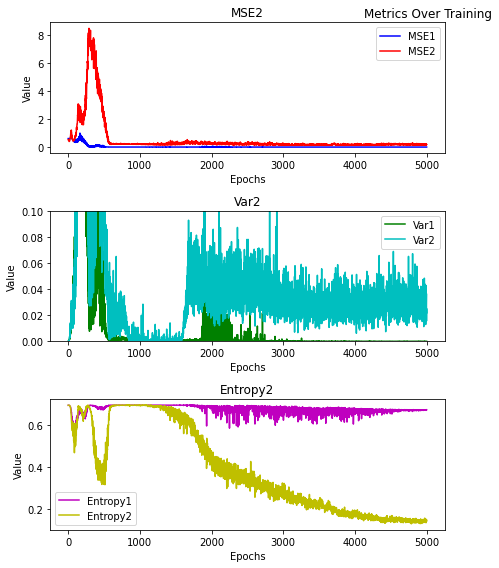

In [259]:
plot_metrics(ss, 'Metrics Over Training')

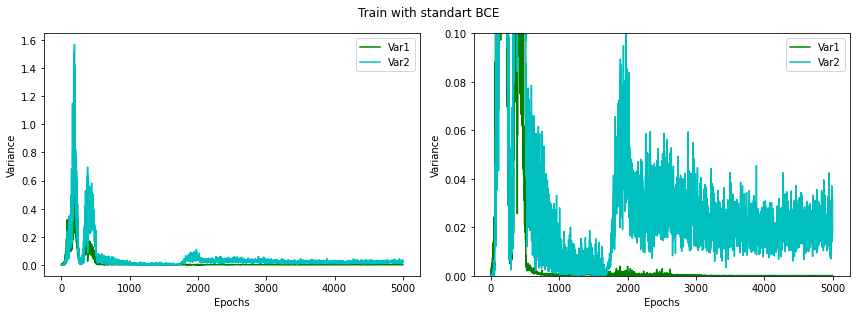

In [232]:
import matplotlib.pyplot as plt

# Define a function to plot the metrics
def plot_metrics(metrics: List[Tuple[float, float, float, float, float, float]], title: str):
    epochs = range(1, len(metrics) + 1)
    
    mse1_values = [m[0] for m in metrics]
    mse2_values = [m[1] for m in metrics]
    var1_values = [m[2] for m in metrics]
    var2_values = [m[3] for m in metrics]
    entropy1_values = [m[4] for m in metrics]
    entropy2_values = [m[5] for m in metrics]
    
    # Plot the metrics
    plt.figure(figsize=(12, 8))
    
#     plt.subplot(3, 2, 1)
#     # plt.gca().set_ylim([0, 0.1])
#     plt.plot(epochs, mse1_values, 'b', label='MSE1')
#     plt.title('MSE1')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
#     # plt.subplot(3, 2, 2)
#     plt.plot(epochs, mse2_values, 'r', label='MSE2')
#     plt.title('MSE2')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
    plt.subplot(2, 2, 1)
    # plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, var1_values, 'g', label='Var1')
    # plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values, 'c', label='Var2')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    
    # plt.subplot(1, 2, 1)
    plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, var1_values, 'g', label='Var1')
    # plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values, 'c', label='Var2')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
#     plt.subplot(3, 2, 5)
#     plt.plot(epochs, entropy1_values, 'm', label='Entropy1')
#     plt.title('Entropy1')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
#     # plt.subplot(3, 2, 6)
#     plt.plot(epochs, entropy2_values, 'y', label='Entropy2')
#     plt.title('Entropy2')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    # plt.suptitle(title)
    plt.savefig('tests/metrics_bce_plot.png')
    plt.show()

# Example usage
plot_metrics(ss, 'Train with standart BCE')
# plot_metrics(s, 'Train with weighted BCE')


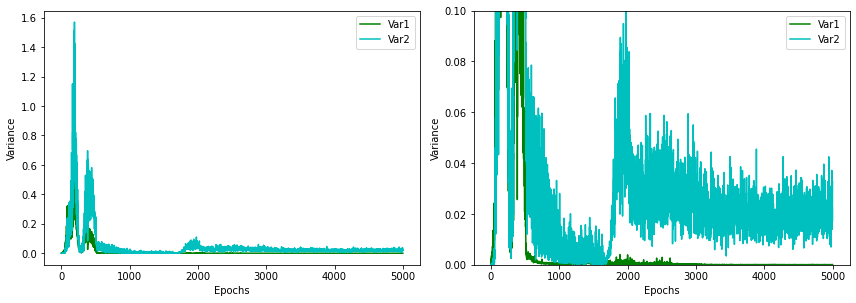

In [221]:
plot_metrics(ss, 'Variances')

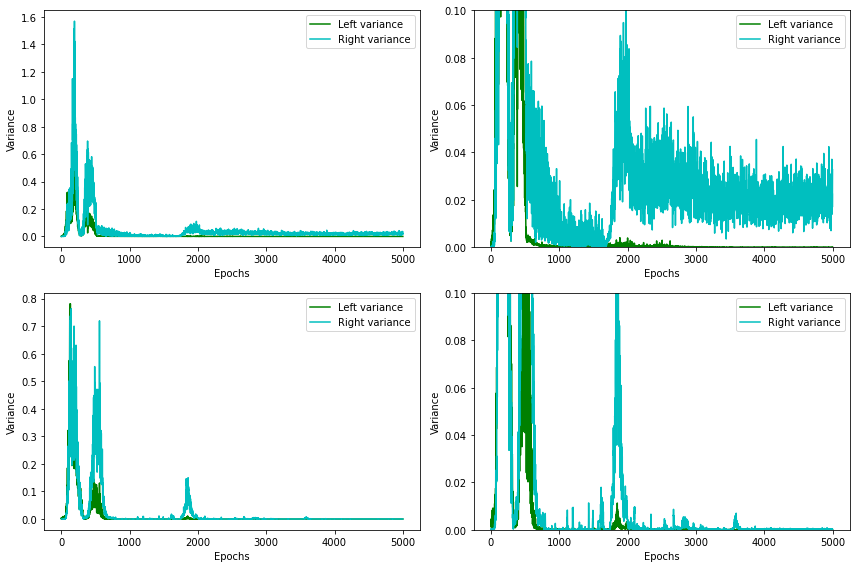

In [245]:
import matplotlib.pyplot as plt

# Define a function to plot the metrics
def plot_metrics(metrics: List[Tuple[float, float, float, float, float, float]],
                 metrics2: List[Tuple[float, float, float, float, float, float]],
                 title: str):
    epochs = range(1, len(metrics) + 1)
    
    mse1_values = [m[0] for m in metrics]
    mse2_values = [m[1] for m in metrics]
    var1_values = [m[2] for m in metrics]
    var2_values = [m[3] for m in metrics]
    entropy1_values = [m[4] for m in metrics]
    entropy2_values = [m[5] for m in metrics]
    
    mse1_values2 = [m[0] for m in metrics2]
    mse2_values2 = [m[1] for m in metrics2]
    var1_values2 = [m[2] for m in metrics2]
    var2_values2 = [m[3] for m in metrics2]
    entropy1_values2 = [m[4] for m in metrics2]
    entropy2_values2 = [m[5] for m in metrics2]
    
    # Plot the metrics
    plt.figure(figsize=(12, 8))
    
#     plt.subplot(3, 2, 1)
#     # plt.gca().set_ylim([0, 0.1])
#     plt.plot(epochs, mse1_values, 'b', label='MSE1')
#     plt.title('MSE1')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
#     # plt.subplot(3, 2, 2)
#     plt.plot(epochs, mse2_values, 'r', label='MSE2')
#     plt.title('MSE2')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
    plt.subplot(2, 2, 1)
    # plt.gca().set_ylim([0, 0.001])
    plt.plot(epochs, var1_values, 'g', label='Left variance')
    # plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values, 'c', label='Right variance')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, var1_values, 'g', label='Left variance')
    # plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values, 'c', label='Right variance')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    
    plt.subplot(2, 2, 3)
    
    # plt.subplot(1, 2, 1)
    # plt.gca().set_ylim([0, 0.1])
    
    plt.plot(epochs, var1_values2, 'g', label='Left variance')
    # plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values2, 'c', label='Right variance')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    
    # plt.subplot(1, 2, 1)
    plt.gca().set_ylim([0, 0.1])
    
    plt.plot(epochs, var1_values2, 'g', label='Left variance')
    # plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values2, 'c', label='Right variance')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.title('Variance')
    
#     plt.subplot(3, 2, 5)
#     plt.plot(epochs, entropy1_values, 'm', label='Entropy1')
#     plt.title('Entropy1')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
#     # plt.subplot(3, 2, 6)
#     plt.plot(epochs, entropy2_values, 'y', label='Entropy2')
#     plt.title('Entropy2')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
    plt.tight_layout()
    # plt.suptitle(title)
    # plt.savefig('tests/metrics_bce_wbce_plot.png')
    plt.show()

# Example usage
# plot_metrics(s, 'Variances')

plot_metrics(ss, s, 'Variances')

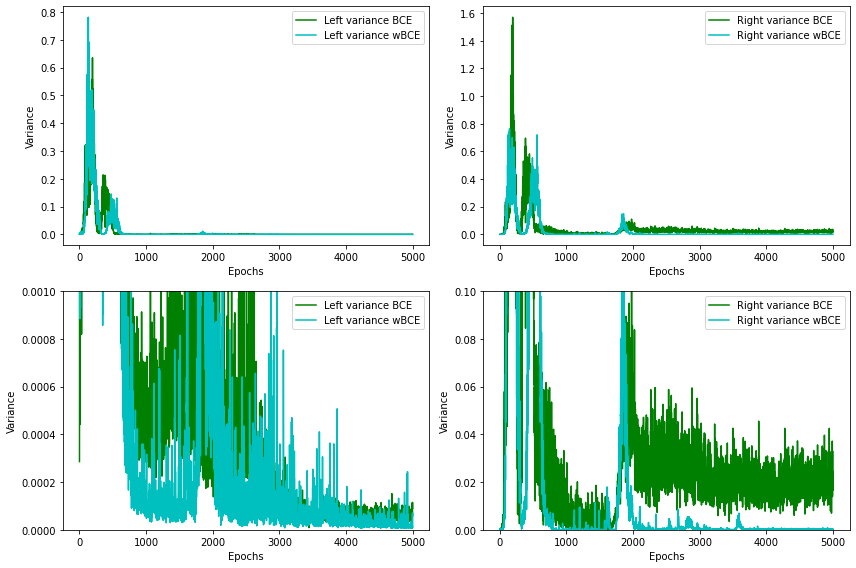

In [253]:
import matplotlib.pyplot as plt

# Define a function to plot the metrics
def plot_metrics(metrics: List[Tuple[float, float, float, float, float, float]],
                 metrics2: List[Tuple[float, float, float, float, float, float]],
                 title: str):
    epochs = range(1, len(metrics) + 1)
    
    mse1_values = [m[0] for m in metrics]
    mse2_values = [m[1] for m in metrics]
    var1_values = [m[2] for m in metrics]
    var2_values = [m[3] for m in metrics]
    entropy1_values = [m[4] for m in metrics]
    entropy2_values = [m[5] for m in metrics]
    
    mse1_values2 = [m[0] for m in metrics2]
    mse2_values2 = [m[1] for m in metrics2]
    var1_values2 = [m[2] for m in metrics2]
    var2_values2 = [m[3] for m in metrics2]
    entropy1_values2 = [m[4] for m in metrics2]
    entropy2_values2 = [m[5] for m in metrics2]
    
    # Plot the metrics
    plt.figure(figsize=(12, 8))
    
#     plt.subplot(3, 2, 1)
#     # plt.gca().set_ylim([0, 0.1])
#     plt.plot(epochs, mse1_values, 'b', label='MSE1')
#     plt.title('MSE1')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
#     # plt.subplot(3, 2, 2)
#     plt.plot(epochs, mse2_values, 'r', label='MSE2')
#     plt.title('MSE2')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
    plt.subplot(2, 2, 1)
    # plt.gca().set_ylim([0, 0.001])
    plt.plot(epochs, var1_values, 'g', label='Left variance BCE')
    # plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var1_values2, 'c', label='Left variance wBCE')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    # plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, var2_values, 'g', label='Right variance BCE')
    # plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values2, 'c', label='Right variance wBCE')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    
    plt.subplot(2, 2, 3)
    plt.gca().set_ylim([0, 0.001])
    plt.plot(epochs, var1_values, 'g', label='Left variance BCE')
    # plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var1_values2, 'c', label='Left variance wBCE')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.gca().set_ylim([0, 0.1])
    plt.plot(epochs, var2_values, 'g', label='Right variance BCE')
    # plt.title('Var1')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.subplot(3, 2, 4)
    plt.plot(epochs, var2_values2, 'c', label='Right variance wBCE')
    # plt.title('Var2')
    plt.xlabel('Epochs')
    plt.ylabel('Variance')
    plt.legend()
    
    # plt.title('Variance')
    
#     plt.subplot(3, 2, 5)
#     plt.plot(epochs, entropy1_values, 'm', label='Entropy1')
#     plt.title('Entropy1')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
#     # plt.subplot(3, 2, 6)
#     plt.plot(epochs, entropy2_values, 'y', label='Entropy2')
#     plt.title('Entropy2')
#     plt.xlabel('Epochs')
#     plt.ylabel('Value')
#     plt.legend()
    
    plt.tight_layout()
    # plt.suptitle(title)
    plt.savefig('tests/metrics1_bce_wbce_plot.png')
    plt.show()

# Example usage
# plot_metrics(s, 'Variances')

plot_metrics(ss, s, 'Variances')

In [175]:
pwd

'/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty'

In [176]:
with open('/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__1/metrics.pkl', 'wb') as f:
    pickle.dump(s, f)

In [173]:
1/2 * np.log(1/2) + 1/2 * np.log(1/2)

-0.6931471805599453

In [174]:
3/4 * np.log(3/4) + 1/4 * np.log(1/4)

-0.5623351446188083

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR

lr = 0.0001
NUM_EPOCHS = 5000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = WeightedVarianceCrossEntropyLoss()
save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
for i in range(26):
    D = Base_Discriminator().to(device=device)
    G = Base_Generator().to(device=device)

    D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
    G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    
    NAME = f'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__{i}'
    # Adjust these parameters as needed
    max_lr = 0.0005  # Maximum learning rate

    # Define the scheduler for both D_optimizer and G_optimizer
    scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
    scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


    D_losses_final, G_losses_final, Variances, Weights_variance, s = train(
        num_epochs = NUM_EPOCHS,
        data_loader = train_loader,
        D = D,
        G = G,
        D_optimizer = D_optimizer,
        G_optimizer = G_optimizer, 
        criterion = loss_function,
        device = device,
        plot_process = True,
        save_path = save_path,
        name = f'{NAME}',
        weights_interval = True,
        # plot_info = True,
        animate_bar_var = True,
        progress_generator = True,
        n_split = 10,
        scheduler_D = scheduler_D,
        scheduler_G = scheduler_G,
        info_n = NUM_EPOCHS,
        save_mse = 'G_mse.pkl'
    )
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__0' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.4314, average G_loss: 0.4166


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:42<00:00,  1.24s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.2536, average G_loss: 0.2407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:48<00:00,  1.25s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__2' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.5836, average G_loss: 0.5726


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:18<00:00,  1.24s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__3' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.2681, average G_loss: 0.2799


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:10<00:00,  1.24s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__4' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.3820, average G_loss: 0.3847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:16<00:00,  1.24s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__5' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.2231, average G_loss: 0.2620


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:44:03<00:00,  1.25s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__6' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.4313, average G_loss: 0.3928


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:44:06<00:00,  1.25s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__7' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.3326, average G_loss: 0.3186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:57<00:00,  1.25s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__8' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.0918, average G_loss: 0.0907


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:15<00:00,  1.24s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__9' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.2543, average G_loss: 0.2795


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:04<00:00,  1.24s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__10' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.3296, average G_loss: 0.3298


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:20<00:00,  1.24s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__11' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.2499, average G_loss: 0.2495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:42:47<00:00,  1.23s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__12' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.3412, average G_loss: 0.3464


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:47:35<00:00,  1.29s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__13' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.4923, average G_loss: 0.5076


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:44:27<00:00,  1.25s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__14' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.5419, average G_loss: 0.5275


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:44:16<00:00,  1.25s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__15' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.3247, average G_loss: 0.3148


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:56<00:00,  1.25s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__16' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.2606, average G_loss: 0.2594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:53<00:00,  1.25s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__17' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.2151, average G_loss: 0.2244


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:44:14<00:00,  1.25s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__18' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.5151, average G_loss: 0.5540


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:49<00:00,  1.25s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__19' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.3560, average G_loss: 0.3153


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:40<00:00,  1.24s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__20' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.5371, average G_loss: 0.5623


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:43:31<00:00,  1.24s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__21' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.2195, average G_loss: 0.1931


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:45:07<00:00,  1.26s/it]


Folder 'base_gan__variance__each_point__accurate_wieights_0,01_OneCycleLR__lr_0,0001__22' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_5_eWBCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.5535, average G_loss: 0.5587


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 3208/5000 [1:05:54<37:00,  1.24s/it]

In [23]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = WeightedIntervalCrossEntropyLoss()
# loss_function = nn.BCELoss()

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
NAME = 'base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__5_1'
# Adjust these parameters as needed
max_lr = 0.0005  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 10,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
)
# plot_sine(G, save_path = save_path, name = NAME)


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.0511, average G_loss: 0.0485


  4%|█████▌                                                                                                                                    | 200/5000 [03:14<1:12:15,  1.11it/s]

epoch [200/5000], average D_loss: 0.0547, average G_loss: 0.0600


  8%|███████████                                                                                                                               | 400/5000 [06:26<1:09:49,  1.10it/s]

epoch [400/5000], average D_loss: 0.0537, average G_loss: 0.0711


 12%|████████████████▌                                                                                                                         | 600/5000 [09:35<1:09:57,  1.05it/s]

epoch [600/5000], average D_loss: 0.0303, average G_loss: 0.0338


 16%|██████████████████████                                                                                                                    | 800/5000 [12:41<1:07:22,  1.04it/s]

epoch [800/5000], average D_loss: 0.0170, average G_loss: 0.0172


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [15:47<59:45,  1.12it/s]

epoch [1000/5000], average D_loss: 0.0193, average G_loss: 0.0195


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [18:55<58:55,  1.07it/s]

epoch [1200/5000], average D_loss: 0.0192, average G_loss: 0.0200


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [22:07<54:41,  1.10it/s]

epoch [1400/5000], average D_loss: 0.0157, average G_loss: 0.0197


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [25:13<51:16,  1.11it/s]

epoch [1600/5000], average D_loss: 0.0233, average G_loss: 0.0269


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [28:20<50:02,  1.07it/s]

epoch [1800/5000], average D_loss: 0.0201, average G_loss: 0.0262


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [31:27<45:45,  1.09it/s]

epoch [2000/5000], average D_loss: 0.0362, average G_loss: 0.0363


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [34:34<42:41,  1.09it/s]

epoch [2200/5000], average D_loss: 0.0411, average G_loss: 0.0409


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [37:45<39:07,  1.11it/s]

epoch [2400/5000], average D_loss: 0.0379, average G_loss: 0.0385


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [40:54<37:13,  1.07it/s]

epoch [2600/5000], average D_loss: 0.0458, average G_loss: 0.0481


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [44:01<32:55,  1.11it/s]

epoch [2800/5000], average D_loss: 0.0520, average G_loss: 0.0520


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [47:10<29:56,  1.11it/s]

epoch [3000/5000], average D_loss: 0.0714, average G_loss: 0.0712


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [50:17<31:04,  1.04s/it]

epoch [3200/5000], average D_loss: 0.0558, average G_loss: 0.0561


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [53:30<24:27,  1.09it/s]

epoch [3400/5000], average D_loss: 0.0605, average G_loss: 0.0605


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [56:38<21:41,  1.08it/s]

epoch [3600/5000], average D_loss: 0.0590, average G_loss: 0.0592


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [59:47<18:18,  1.09it/s]

epoch [3800/5000], average D_loss: 0.0396, average G_loss: 0.0393


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4000/5000 [1:02:56<14:57,  1.11it/s]

epoch [4000/5000], average D_loss: 0.0546, average G_loss: 0.0546


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4200/5000 [1:06:06<12:23,  1.08it/s]

epoch [4200/5000], average D_loss: 0.0451, average G_loss: 0.0451


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:09:19<09:26,  1.06it/s]

epoch [4400/5000], average D_loss: 0.0456, average G_loss: 0.0457


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:12:29<06:22,  1.05it/s]

epoch [4600/5000], average D_loss: 0.0286, average G_loss: 0.0286


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:15:40<02:59,  1.11it/s]

epoch [4800/5000], average D_loss: 0.0523, average G_loss: 0.0523


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:18:51<00:00,  1.06it/s]


In [24]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = WeightedIntervalCrossEntropyLoss()
# loss_function = nn.BCELoss()

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
NAME = 'base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__6_1'
# Adjust these parameters as needed
max_lr = 0.0005  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 10,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
)
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__6_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.1136, average G_loss: 0.1124


  4%|█████▌                                                                                                                                    | 200/5000 [03:02<1:10:58,  1.13it/s]

epoch [200/5000], average D_loss: 0.0582, average G_loss: 0.0623


  8%|███████████                                                                                                                               | 400/5000 [06:07<1:09:20,  1.11it/s]

epoch [400/5000], average D_loss: 0.1146, average G_loss: 0.1179


 12%|████████████████▌                                                                                                                         | 600/5000 [09:11<1:05:14,  1.12it/s]

epoch [600/5000], average D_loss: 0.0215, average G_loss: 0.0215


 16%|██████████████████████                                                                                                                    | 800/5000 [12:22<1:03:44,  1.10it/s]

epoch [800/5000], average D_loss: 0.0240, average G_loss: 0.0240


 20%|███████████████████████████▍                                                                                                             | 1000/5000 [15:27<1:04:25,  1.03it/s]

epoch [1000/5000], average D_loss: 0.0204, average G_loss: 0.0206


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [18:35<57:46,  1.10it/s]

epoch [1200/5000], average D_loss: 0.0227, average G_loss: 0.0228


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [21:45<55:14,  1.09it/s]

epoch [1400/5000], average D_loss: 0.0216, average G_loss: 0.0217


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [24:52<51:43,  1.10it/s]

epoch [1600/5000], average D_loss: 0.0205, average G_loss: 0.0205


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [28:02<51:50,  1.03it/s]

epoch [1800/5000], average D_loss: 0.0192, average G_loss: 0.0192


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [31:09<45:32,  1.10it/s]

epoch [2000/5000], average D_loss: 0.0142, average G_loss: 0.0145


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [34:17<42:05,  1.11it/s]

epoch [2200/5000], average D_loss: 0.0209, average G_loss: 0.0210


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [37:26<41:02,  1.06it/s]

epoch [2400/5000], average D_loss: 0.0167, average G_loss: 0.0166


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [40:26<34:56,  1.14it/s]

epoch [2600/5000], average D_loss: 0.0137, average G_loss: 0.0138


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [43:19<31:39,  1.16it/s]

epoch [2800/5000], average D_loss: 0.0134, average G_loss: 0.0134


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [46:11<28:16,  1.18it/s]

epoch [3000/5000], average D_loss: 0.0163, average G_loss: 0.0165


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [49:04<26:29,  1.13it/s]

epoch [3200/5000], average D_loss: 0.0135, average G_loss: 0.0135


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [51:55<22:10,  1.20it/s]

epoch [3400/5000], average D_loss: 0.0135, average G_loss: 0.0136


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [54:49<19:38,  1.19it/s]

epoch [3600/5000], average D_loss: 0.0142, average G_loss: 0.0142


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [57:42<18:22,  1.09it/s]

epoch [3800/5000], average D_loss: 0.0136, average G_loss: 0.0139


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4000/5000 [1:00:35<13:53,  1.20it/s]

epoch [4000/5000], average D_loss: 0.0128, average G_loss: 0.0129


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4200/5000 [1:03:28<11:10,  1.19it/s]

epoch [4200/5000], average D_loss: 0.0135, average G_loss: 0.0135


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:06:21<08:35,  1.16it/s]

epoch [4400/5000], average D_loss: 0.0136, average G_loss: 0.0136


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:09:14<05:56,  1.12it/s]

epoch [4600/5000], average D_loss: 0.0134, average G_loss: 0.0135


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:12:07<02:47,  1.19it/s]

epoch [4800/5000], average D_loss: 0.0136, average G_loss: 0.0136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:15:01<00:00,  1.11it/s]


In [ ]:

# D = Base_Discriminator().to(device=device)
# G = Base_Generator().to(device=device)
# lr = 0.0001
# NUM_EPOCHS = 5000
# loss_function = WeightedIntervalCrossEntropyLoss()
# # loss_function = nn.BCELoss()

# D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
# G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# # NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# # NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# # NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
# NAME = 'base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__2_1'
# # Adjust these parameters as needed
# max_lr = 0.0005  # Maximum learning rate

# # Define the scheduler for both D_optimizer and G_optimizer
# scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
# scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


# D_losses_final, G_losses_final, Variances, Weights_variance = train(
#     num_epochs = NUM_EPOCHS,
#     data_loader = train_loader,
#     D = D,
#     G = G,
#     D_optimizer = D_optimizer,
#     G_optimizer = G_optimizer, 
#     criterion = loss_function,
#     device = device,
#     plot_process = True,
#     save_path = save_path,
#     name = f'{NAME}',
#     weights_interval = True,
#     # plot_info = True,
#     animate_bar_var = True,
#     progress_generator = True,
#     n_split = 10,
#     scheduler_D = scheduler_D,
#     scheduler_G = scheduler_G
# )
# # plot_sine(G, save_path = save_path, name = NAME)


In [96]:
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = nn.BCELoss()
max_lr = 0.0005
save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
for i in range(50):
    D = Base_Discriminator().to(device=device)
    G = Base_Generator().to(device=device)

    D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
    G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    NAME = f'base_gan__lr_0,001_OneCycleLR__{i}'

# Adjust these parameters as needed


    scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
    scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

    D_losses_final, G_losses_final, Variances, Weights_variance = train(
        num_epochs = NUM_EPOCHS,
        data_loader = train_loader,
        D = D,
        G = G,
        D_optimizer = D_optimizer,
        G_optimizer = G_optimizer, 
        criterion = loss_function,
        device = device,
        plot_process = True,
        save_path = save_path,
        name = f'{NAME}',
        weights_interval = False,
        # plot_info = True,
        animate_bar_var = True,
        progress_generator = True,
        scheduler_D = scheduler_D,
        scheduler_G = scheduler_G,
        info_n = NUM_EPOCHS,
        save_mse = 'G_mse.pkl'
        # n_split = 10
    )

Folder 'base_gan__lr_0,001_OneCycleLR__0' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6941, average G_loss: 0.6908


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:08:40<00:00,  1.21it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6993, average G_loss: 0.5993


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:08:38<00:00,  1.21it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__2' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6964, average G_loss: 0.6997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:09:58<00:00,  1.19it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__3' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6922, average G_loss: 0.6598


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:08:26<00:00,  1.22it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__4' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6943, average G_loss: 0.6918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:07:56<00:00,  1.23it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__5' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6956, average G_loss: 0.6640


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:07:24<00:00,  1.24it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__6' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6927, average G_loss: 0.6536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:08:23<00:00,  1.22it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__7' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6981, average G_loss: 0.6784


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:08:32<00:00,  1.22it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__8' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6929, average G_loss: 0.6425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:07:08<00:00,  1.24it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__9' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6975, average G_loss: 0.7194


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:40<00:00,  1.27it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__10' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.7006, average G_loss: 0.7188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:51<00:00,  1.27it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__11' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6968, average G_loss: 0.6537


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:51<00:00,  1.27it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__12' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6961, average G_loss: 0.6250


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:19<00:00,  1.28it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__13' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6940, average G_loss: 0.7097


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:26<00:00,  1.27it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__14' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6959, average G_loss: 0.7643


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:09<00:00,  1.28it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__15' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6952, average G_loss: 0.6520


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:19<00:00,  1.28it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__16' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6933, average G_loss: 0.6976


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:29<00:00,  1.27it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__17' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6976, average G_loss: 0.6357


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:06:17<00:00,  1.26it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__18' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.7003, average G_loss: 0.7506


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:35<00:00,  1.27it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__19' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6929, average G_loss: 0.6651


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:09:44<00:00,  1.19it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__20' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6919, average G_loss: 0.6610


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:27<00:00,  1.27it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__21' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6958, average G_loss: 0.7361


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:06:14<00:00,  1.26it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__22' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6943, average G_loss: 0.6791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:06:21<00:00,  1.26it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__23' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6974, average G_loss: 0.6315


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:43<00:00,  1.27it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__24' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6935, average G_loss: 0.6775


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:33<00:00,  1.27it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__25' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6920, average G_loss: 0.7696


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:05:58<00:00,  1.26it/s]


Folder 'base_gan__lr_0,001_OneCycleLR__26' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests_range_2_BCELoss/'.


  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6942, average G_loss: 0.6827


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4066/5000 [13:52:56<3:11:20, 12.29s/it]


KeyboardInterrupt: 

In [51]:
import pickle
wbce_mse_path = 'tests_range_4_WBCELoss/G_mse.pkl'

with open(wbce_mse_path, 'rb') as f:
    loaded_wbce_G_mse = pickle.load(f)

In [17]:
import pickle
ewbce_mse_path = 'tests_range_5_eWBCELoss/G_mse.pkl'

with open(ewbce_mse_path, 'rb') as f:
    loaded_ewbce_G_mse = pickle.load(f)


In [22]:
bce_mse_path = 'tests_range_2_BCELoss/G_mse.pkl'

with open(bce_mse_path, 'rb') as f:
    loaded_bce_G_mse = pickle.load(f)

22 22


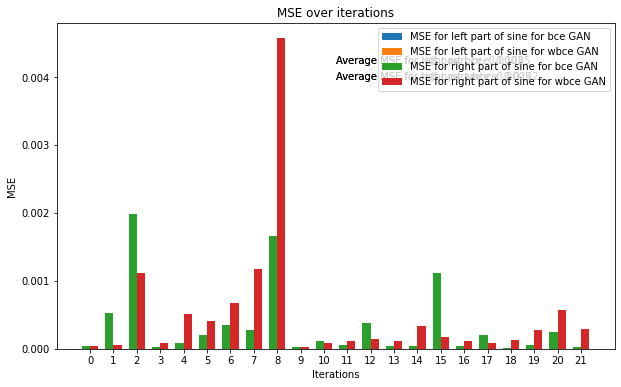

In [23]:
# save_path
import pickle
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_from_pickle_bar(file_path1: str, file_path2: str) -> None:
    """
    Load and plot MSE values from a pickle file as bar plots.
    
    Parameters:
    - file_path: Path to the pickle file containing MSE values.
    """
    # Load the MSE values from the pickle file
    with open(file_path1, 'rb') as f:
        loaded_bce_G_mse = pickle.load(f)
    with open(file_path2, 'rb') as f:
        loaded_wbce_G_mse = pickle.load(f)
    if len(loaded_bce_G_mse) != len(loaded_wbce_G_mse):
        min_len = min(len(loaded_bce_G_mse), len(loaded_wbce_G_mse))
        
        loaded_bce_G_mse = loaded_bce_G_mse[:min_len]
        loaded_wbce_G_mse = loaded_wbce_G_mse[:min_len]
        print(len(loaded_bce_G_mse), len(loaded_wbce_G_mse))
    
    # assert(len(loaded_bce_G_mse) == len(loaded_wbce_G_mse))
    # Extract MSE values from loaded_G_mse
    mse1_values_1 = [mse[0] for mse in loaded_bce_G_mse]
    mse2_values_1 = [mse[1] for mse in loaded_bce_G_mse]
    
    mse1_values_2 = [mse[0] for mse in loaded_wbce_G_mse]
    mse2_values_2 = [mse[1] for mse in loaded_wbce_G_mse]

    # Calculate average MSE values
    avg_mse1_1 = sum(mse1_values_1) / len(mse1_values_1)
    avg_mse2_1 = sum(mse2_values_1) / len(mse2_values_1)

    avg_mse1_2 = sum(mse1_values_2) / len(mse1_values_2)
    avg_mse2_2 = sum(mse2_values_2) / len(mse2_values_2)
    

    # Plot MSE values as bar plots
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(mse1_values_1))
    
    
    rects1 = ax.bar(index, mse1_values_1, bar_width, label='MSE for left part of sine for bce GAN')
    rects2 = ax.bar(index + bar_width, mse1_values_2, bar_width, label='MSE for left part of sine for wbce GAN')
    # rects2 = ax.bar(index + bar_width, mse2_values, bar_width, label='MSE for right part of sine')

    ax.set_xlabel('Iterations')
    ax.set_ylabel('MSE')
    ax.set_title('MSE over iterations')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([str(i) for i in range(len(mse1_values_1))])
    ax.legend()
    
    # Add text for average MSE values
    ax.text(0.5, 0.9, f'Average MSE for left part bce: {avg_mse1_1:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.text(0.5, 0.85, f'Average MSE for left part wbce: {avg_mse1_2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    # ax.text(0.5, 0.85, f'Average MSE for right part: {avg_mse2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

    
    
    rects1 = ax.bar(index, mse1_values_1, bar_width, label='MSE for right part of sine for bce GAN')
    rects2 = ax.bar(index + bar_width, mse1_values_2, bar_width, label='MSE for right part of sine for wbce GAN')
    # rects2 = ax.bar(index + bar_width, mse2_values, bar_width, label='MSE for right part of sine')

    ax.set_xlabel('Iterations')
    ax.set_ylabel('MSE')
    ax.set_title('MSE over iterations')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([str(i) for i in range(len(mse2_values_1))])
    ax.legend()
    
    # Add text for average MSE values
    ax.text(0.5, 0.9, f'Average MSE for right part bce: {avg_mse2_1:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.text(0.5, 0.85, f'Average MSE for right part wbce: {avg_mse2_2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    
    
    plt.show()

# Example usage:
plot_mse_from_pickle_bar(bce_mse_path, ewbce_mse_path)


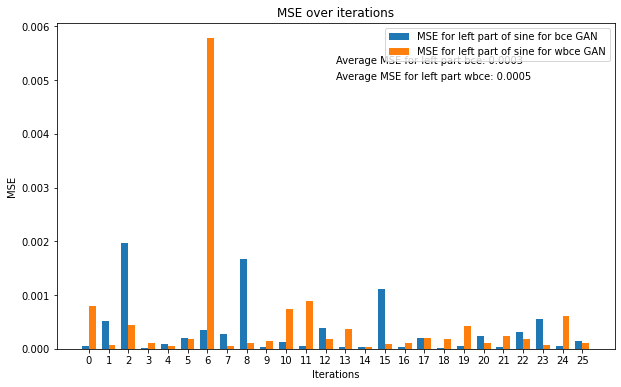

In [49]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_from_pickle_bar(file_path1: str, file_path2: str) -> None:
    """
    Load and plot MSE values from a pickle file as bar plots.
    
    Parameters:
    - file_path: Path to the pickle file containing MSE values.
    """
    # Load the MSE values from the pickle file
    with open(file_path1, 'rb') as f:
        loaded_bce_G_mse = pickle.load(f)
    with open(file_path2, 'rb') as f:
        loaded_wbce_G_mse = pickle.load(f)
    assert(len(loaded_bce_G_mse) == len(loaded_wbce_G_mse))
    # Extract MSE values from loaded_G_mse
    mse1_values_1 = [mse[0] for mse in loaded_bce_G_mse]
    mse2_values_1 = [mse[1] for mse in loaded_bce_G_mse]
    
    mse1_values_2 = [mse[0] for mse in loaded_wbce_G_mse]
    mse2_values_2 = [mse[1] for mse in loaded_wbce_G_mse]

    # Calculate average MSE values
    avg_mse1_1 = sum(mse1_values_1) / len(mse1_values_1)
    avg_mse2_1 = sum(mse2_values_1) / len(mse2_values_1)

    avg_mse1_2 = sum(mse1_values_2) / len(mse1_values_2)
    avg_mse2_2 = sum(mse2_values_2) / len(mse2_values_2)
    

    # Plot MSE values as bar plots
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(mse1_values_1))
    
    
    rects1 = ax.bar(index, mse1_values_1, bar_width, label='MSE for left part of sine for bce GAN')
    rects2 = ax.bar(index + bar_width, mse1_values_2, bar_width, label='MSE for left part of sine for wbce GAN')
    # rects2 = ax.bar(index + bar_width, mse2_values, bar_width, label='MSE for right part of sine')

    ax.set_xlabel('Iterations')
    ax.set_ylabel('MSE')
    ax.set_title('MSE over iterations')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([str(i) for i in range(len(mse1_values_1))])
    ax.legend()
    
    # Add text for average MSE values
    ax.text(0.5, 0.9, f'Average MSE for left part bce: {avg_mse1_1:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.text(0.5, 0.85, f'Average MSE for left part wbce: {avg_mse1_2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    # ax.text(0.5, 0.85, f'Average MSE for right part: {avg_mse2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

    
    
    rects1 = ax.bar(index, mse1_values_1, bar_width, label='MSE for right part of sine for bce GAN')
    rects2 = ax.bar(index + bar_width, mse1_values_2, bar_width, label='MSE for right part of sine for wbce GAN')
    # rects2 = ax.bar(index + bar_width, mse2_values, bar_width, label='MSE for right part of sine')

    ax.set_xlabel('Iterations')
    ax.set_ylabel('MSE')
    ax.set_title('MSE over iterations')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([str(i) for i in range(len(mse2_values_1))])
    ax.legend()
    
    # Add text for average MSE values
    ax.text(0.5, 0.9, f'Average MSE for right part bce: {avg_mse2_1:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.text(0.5, 0.85, f'Average MSE for right part wbce: {avg_mse2_2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    
    
    plt.show()

# Example usage:
plot_mse_from_pickle_bar(bce_mse_path, wbce_mse_path)


22 22
The left part:
 Mean MSE: BCE GAN -- 0.00034, WBCE GAN -- 0.00050,
 Median MSE: BCE GAN -- 0.00010, WBCE GAN -- 0.00016

The right part:
 Mean MSE: BCE GAN -- 0.10047, WBCE GAN -- 0.01421,
 Median MSE: BCE GAN -- 0.05744, WBCE GAN -- 0.00522


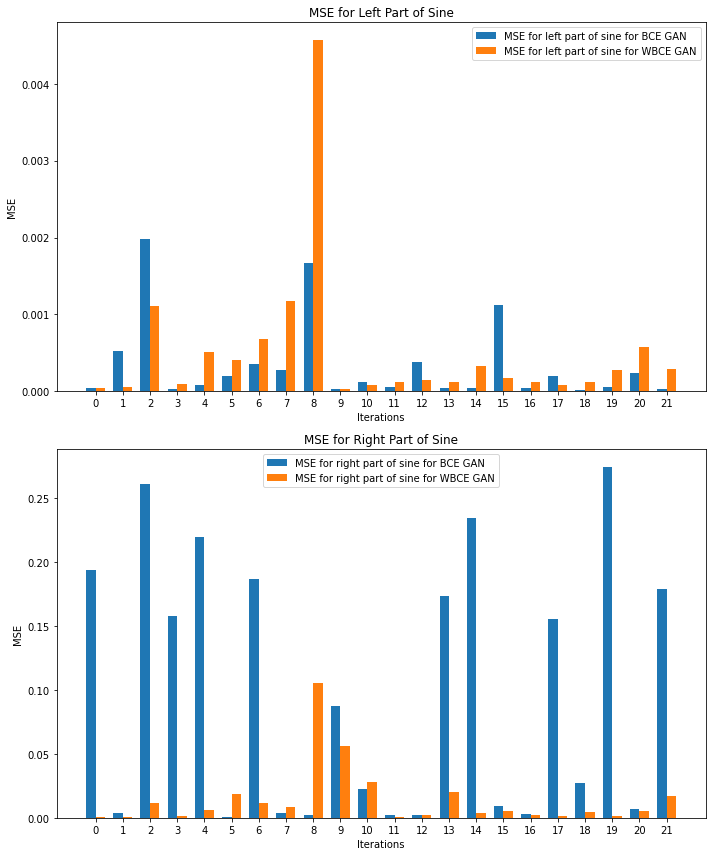

In [24]:

        
import pickle
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_from_pickle_bar(file_path1: str, file_path2: str) -> None:
    """
    Load and plot MSE values from two pickle files as bar plots.
    
    Parameters:
    - file_path1: Path to the first pickle file containing MSE values.
    - file_path2: Path to the second pickle file containing MSE values.
    """
    # Load the MSE values from the first pickle file
    with open(file_path1, 'rb') as f:
        loaded_bce_G_mse = pickle.load(f)
        
    # Load the MSE values from the second pickle file
    with open(file_path2, 'rb') as f:
        loaded_wbce_G_mse = pickle.load(f)
        
    if len(loaded_bce_G_mse) != len(loaded_wbce_G_mse):
        min_len = min(len(loaded_bce_G_mse), len(loaded_wbce_G_mse))
        
        loaded_bce_G_mse = loaded_bce_G_mse[:min_len]
        loaded_wbce_G_mse = loaded_wbce_G_mse[:min_len]
        print(len(loaded_bce_G_mse), len(loaded_wbce_G_mse))
    # assert len(loaded_bce_G_mse) == len(loaded_wbce_G_mse)
    
    # Extract MSE values for the left and right parts of the sine function
    mse1_values_bce = [mse[0] for mse in loaded_bce_G_mse]
    mse2_values_bce = [mse[1] for mse in loaded_bce_G_mse]
    
    mse1_values_wbce = [mse[0] for mse in loaded_wbce_G_mse]
    mse2_values_wbce = [mse[1] for mse in loaded_wbce_G_mse]

    # Calculate average and median MSE values for both parts
    avg_mse1_bce = np.mean(mse1_values_bce)
    avg_mse2_bce = np.mean(mse2_values_bce)
    median_mse1_bce = np.median(mse1_values_bce)
    median_mse2_bce = np.median(mse2_values_bce)
    
    avg_mse1_wbce = np.mean(mse1_values_wbce)
    avg_mse2_wbce = np.mean(mse2_values_wbce)
    median_mse1_wbce = np.median(mse1_values_wbce)
    median_mse2_wbce = np.median(mse2_values_wbce)

    # Plot MSE values as bar plots
    fig, axes = plt.subplots(2, figsize=(10, 12))
    index = np.arange(len(mse1_values_bce))
    bar_width = 0.35

    # Plot MSE values for the left part of the sine function
    axes[0].bar(index, mse1_values_bce, bar_width, label='MSE for left part of sine for BCE GAN')
    axes[0].bar(index + bar_width, mse1_values_wbce, bar_width, label='MSE for left part of sine for WBCE GAN')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('MSE')
    axes[0].set_title('MSE for Left Part of Sine')
    axes[0].set_xticks(index + bar_width / 2)
    axes[0].set_xticklabels([str(i) for i in range(len(mse1_values_bce))])
    axes[0].legend()
    print(f'The left part:\n Mean MSE: BCE GAN -- {avg_mse1_bce:.5f}, WBCE GAN -- {avg_mse1_wbce:.5f},\n Median MSE: BCE GAN -- {median_mse1_bce:.5f}, WBCE GAN -- {median_mse1_wbce:.5f}')
    # axes[0].text(0.5, 0.9, f'Average MSE for left part BCE: {avg_mse1_bce:.4f}', transform=axes[0].transAxes, fontsize=10, verticalalignment='top')
    # axes[0].text(0.5, 0.85, f'Median MSE for left part BCE: {median_mse1_bce:.4f}', transform=axes[0].transAxes, fontsize=10, verticalalignment='top')
    # axes[0].text(0.5, 0.8, f'Average MSE for left part WBCE: {avg_mse1_wbce:.4f}', transform=axes[0].transAxes, fontsize=10, verticalalignment='top')
    # axes[0].text(0.5, 0.75, f'Median MSE for left part WBCE: {median_mse1_wbce:.4f}', transform=axes[0].transAxes, fontsize=10, verticalalignment='top')

    # Plot MSE values for the right part of the sine function
    axes[1].bar(index, mse2_values_bce, bar_width, label='MSE for right part of sine for BCE GAN')
    axes[1].bar(index + bar_width, mse2_values_wbce, bar_width, label='MSE for right part of sine for WBCE GAN')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('MSE')
    axes[1].set_title('MSE for Right Part of Sine')
    axes[1].set_xticks(index + bar_width / 2)
    axes[1].set_xticklabels([str(i) for i in range(len(mse2_values_bce))])
    axes[1].legend()
    # axes[1].text(0.5, 0.9, f'Average MSE for right part BCE: {avg_mse2_bce:.4f}', transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
    # axes[1].text(0.5, 0.85, f'Median MSE for right part BCE: {median_mse2_bce:.4f}', transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
    # axes[1].text(0.5, 0.8, f'Average MSE for right part WBCE: {avg_mse2_wbce:.4f}', transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
    # axes[1].text(0.5, 0.75, f'Median MSE for right part WBCE: {median_mse2_wbce:.4f}', transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
    print(f'\nThe right part:\n Mean MSE: BCE GAN -- {avg_mse2_bce:.5f}, WBCE GAN -- {avg_mse2_wbce:.5f},\n Median MSE: BCE GAN -- {median_mse2_bce:.5f}, WBCE GAN -- {median_mse2_wbce:.5f}')
    plt.tight_layout()
    plt.show()


plot_mse_from_pickle_bar(bce_mse_path, ewbce_mse_path)


The left part:
 Mean MSE: BCE GAN -- 0.00033, WBCE GAN -- 0.00047,
 Median MSE: BCE GAN -- 0.00013, WBCE GAN -- 0.00018

The right part:
 Mean MSE: BCE GAN -- 0.09422, WBCE GAN -- 0.03840,
 Median MSE: BCE GAN -- 0.02489, WBCE GAN -- 0.00411


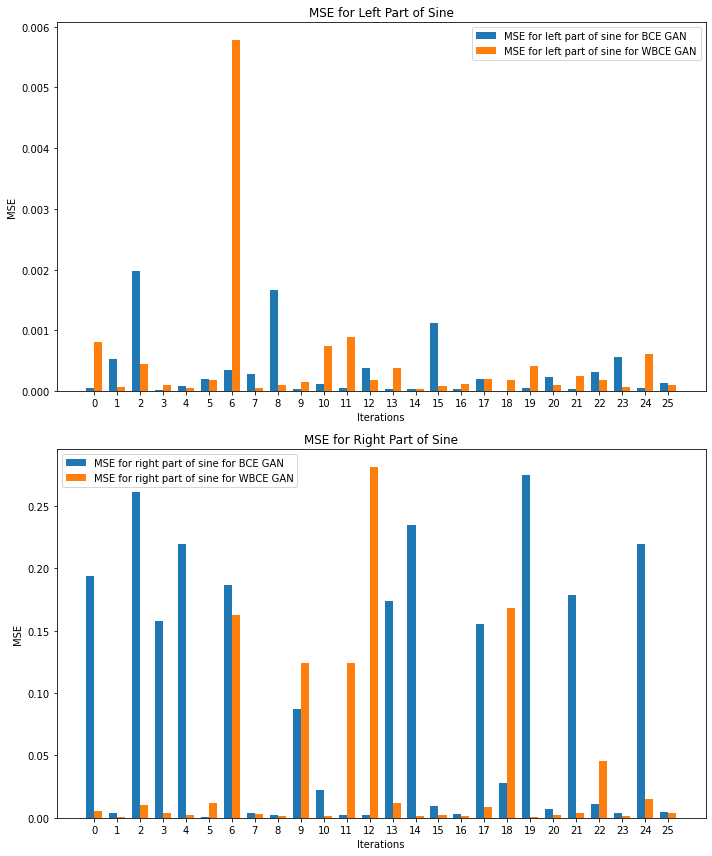

In [70]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_from_pickle_bar(file_path1: str, file_path2: str) -> None:
    """
    Load and plot MSE values from two pickle files as bar plots.
    
    Parameters:
    - file_path1: Path to the first pickle file containing MSE values.
    - file_path2: Path to the second pickle file containing MSE values.
    """
    # Load the MSE values from the first pickle file
    with open(file_path1, 'rb') as f:
        loaded_bce_G_mse = pickle.load(f)
        
    # Load the MSE values from the second pickle file
    with open(file_path2, 'rb') as f:
        loaded_wbce_G_mse = pickle.load(f)
        
    assert len(loaded_bce_G_mse) == len(loaded_wbce_G_mse)
    
    # Extract MSE values for the left and right parts of the sine function
    mse1_values_bce = [mse[0] for mse in loaded_bce_G_mse]
    mse2_values_bce = [mse[1] for mse in loaded_bce_G_mse]
    
    mse1_values_wbce = [mse[0] for mse in loaded_wbce_G_mse]
    mse2_values_wbce = [mse[1] for mse in loaded_wbce_G_mse]

    # Calculate average and median MSE values for both parts
    avg_mse1_bce = np.mean(mse1_values_bce)
    avg_mse2_bce = np.mean(mse2_values_bce)
    median_mse1_bce = np.median(mse1_values_bce)
    median_mse2_bce = np.median(mse2_values_bce)
    
    avg_mse1_wbce = np.mean(mse1_values_wbce)
    avg_mse2_wbce = np.mean(mse2_values_wbce)
    median_mse1_wbce = np.median(mse1_values_wbce)
    median_mse2_wbce = np.median(mse2_values_wbce)

    # Plot MSE values as bar plots
    fig, axes = plt.subplots(2, figsize=(10, 12))
    index = np.arange(len(mse1_values_bce))
    bar_width = 0.35

    # Plot MSE values for the left part of the sine function
    axes[0].bar(index, mse1_values_bce, bar_width, label='MSE for left part of sine for BCE GAN')
    axes[0].bar(index + bar_width, mse1_values_wbce, bar_width, label='MSE for left part of sine for WBCE GAN')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('MSE')
    axes[0].set_title('MSE for Left Part of Sine')
    axes[0].set_xticks(index + bar_width / 2)
    axes[0].set_xticklabels([str(i) for i in range(len(mse1_values_bce))])
    axes[0].legend()
    print(f'The left part:\n Mean MSE: BCE GAN -- {avg_mse1_bce:.5f}, WBCE GAN -- {avg_mse1_wbce:.5f},\n Median MSE: BCE GAN -- {median_mse1_bce:.5f}, WBCE GAN -- {median_mse1_wbce:.5f}')
    # axes[0].text(0.5, 0.9, f'Average MSE for left part BCE: {avg_mse1_bce:.4f}', transform=axes[0].transAxes, fontsize=10, verticalalignment='top')
    # axes[0].text(0.5, 0.85, f'Median MSE for left part BCE: {median_mse1_bce:.4f}', transform=axes[0].transAxes, fontsize=10, verticalalignment='top')
    # axes[0].text(0.5, 0.8, f'Average MSE for left part WBCE: {avg_mse1_wbce:.4f}', transform=axes[0].transAxes, fontsize=10, verticalalignment='top')
    # axes[0].text(0.5, 0.75, f'Median MSE for left part WBCE: {median_mse1_wbce:.4f}', transform=axes[0].transAxes, fontsize=10, verticalalignment='top')

    # Plot MSE values for the right part of the sine function
    axes[1].bar(index, mse2_values_bce, bar_width, label='MSE for right part of sine for BCE GAN')
    axes[1].bar(index + bar_width, mse2_values_wbce, bar_width, label='MSE for right part of sine for WBCE GAN')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('MSE')
    axes[1].set_title('MSE for Right Part of Sine')
    axes[1].set_xticks(index + bar_width / 2)
    axes[1].set_xticklabels([str(i) for i in range(len(mse2_values_bce))])
    axes[1].legend()
    # axes[1].text(0.5, 0.9, f'Average MSE for right part BCE: {avg_mse2_bce:.4f}', transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
    # axes[1].text(0.5, 0.85, f'Median MSE for right part BCE: {median_mse2_bce:.4f}', transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
    # axes[1].text(0.5, 0.8, f'Average MSE for right part WBCE: {avg_mse2_wbce:.4f}', transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
    # axes[1].text(0.5, 0.75, f'Median MSE for right part WBCE: {median_mse2_wbce:.4f}', transform=axes[1].transAxes, fontsize=10, verticalalignment='top')
    print(f'\nThe right part:\n Mean MSE: BCE GAN -- {avg_mse2_bce:.5f}, WBCE GAN -- {avg_mse2_wbce:.5f},\n Median MSE: BCE GAN -- {median_mse2_bce:.5f}, WBCE GAN -- {median_mse2_wbce:.5f}')
    plt.tight_layout()
    plt.show()


plot_mse_from_pickle_bar(bce_mse_path, wbce_mse_path)


In [77]:
import sklearn
sklearn.__version__

'1.2.2'

In [ ]:
sklearn==1.2.2


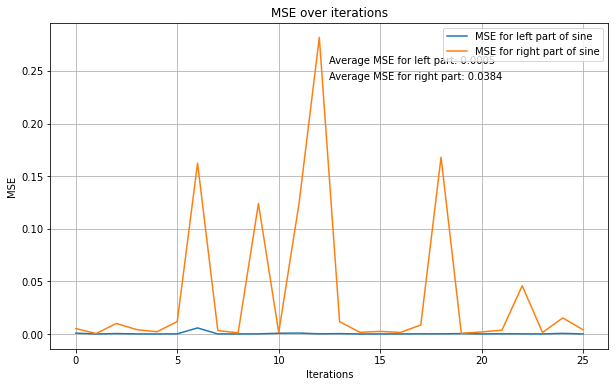

In [36]:
import pickle
import matplotlib.pyplot as plt

# file_path = 'G_mse.pkl'
# file_path = os.path.join(save_path, file_path)

bce_mse_path = 'tests_range_2_BCELoss/G_mse.pkl'
wbce_mse_path = 'tests_range_4_WBCELoss/G_mse.pkl'

def plot_mse_from_pickle(file_path: str) -> None:
    """
    Load and plot MSE values from a pickle file.
    
    Parameters:
    - file_path: Path to the pickle file containing MSE values.
    """
    # Load the MSE values from the pickle file
    with open(file_path, 'rb') as f:
        loaded_G_mse = pickle.load(f)
    # print(loaded_G_mse)

    # Extract MSE values from loaded_G_mse
    mse1_values = [mse[0] for mse in loaded_G_mse]
    mse2_values = [mse[1] for mse in loaded_G_mse]

    # Calculate average MSE values
    avg_mse1 = sum(mse1_values) / len(mse1_values)
    avg_mse2 = sum(mse2_values) / len(mse2_values)

    # Plot MSE values
    plt.figure(figsize=(10, 6))
    plt.plot(mse1_values, label='MSE for left part of sine')
    plt.plot(mse2_values, label='MSE for right part of sine')
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.title('MSE over iterations')
    plt.legend()
    plt.grid(True)
    
    # Add text for average MSE values
    plt.text(0.5, 0.9, f'Average MSE for left part: {avg_mse1:.4f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.5, 0.85, f'Average MSE for right part: {avg_mse2:.4f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    
    plt.show()

# Example usage:
plot_mse_from_pickle(wbce_mse_path)


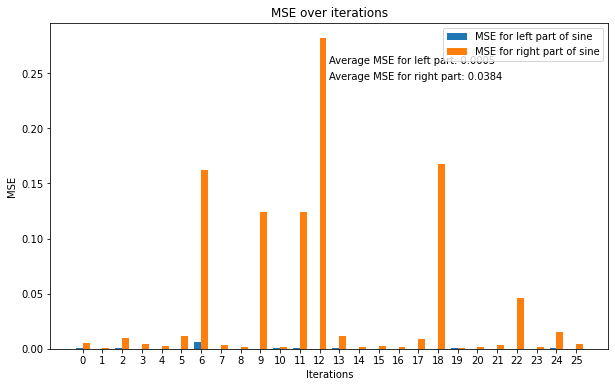

In [25]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_from_pickle_bar(file_path: str) -> None:
    """
    Load and plot MSE values from a pickle file as bar plots.
    
    Parameters:
    - file_path: Path to the pickle file containing MSE values.
    """
    # Load the MSE values from the pickle file
    with open(file_path, 'rb') as f:
        loaded_G_mse = pickle.load(f)

    # Extract MSE values from loaded_G_mse
    mse1_values = [mse[0] for mse in loaded_G_mse]
    mse2_values = [mse[1] for mse in loaded_G_mse]

    # Calculate average MSE values
    avg_mse1 = sum(mse1_values) / len(mse1_values)
    avg_mse2 = sum(mse2_values) / len(mse2_values)

    # Plot MSE values as bar plots
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(mse1_values))
    rects1 = ax.bar(index, mse1_values, bar_width, label='MSE for left part of sine')
    rects2 = ax.bar(index + bar_width, mse2_values, bar_width, label='MSE for right part of sine')

    ax.set_xlabel('Iterations')
    ax.set_ylabel('MSE')
    ax.set_title('MSE over iterations')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([str(i) for i in range(len(mse1_values))])
    ax.legend()
    
    # Add text for average MSE values
    ax.text(0.5, 0.9, f'Average MSE for left part: {avg_mse1:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.text(0.5, 0.85, f'Average MSE for right part: {avg_mse2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

    plt.show()

# Example usage:
plot_mse_from_pickle_bar(file_path)


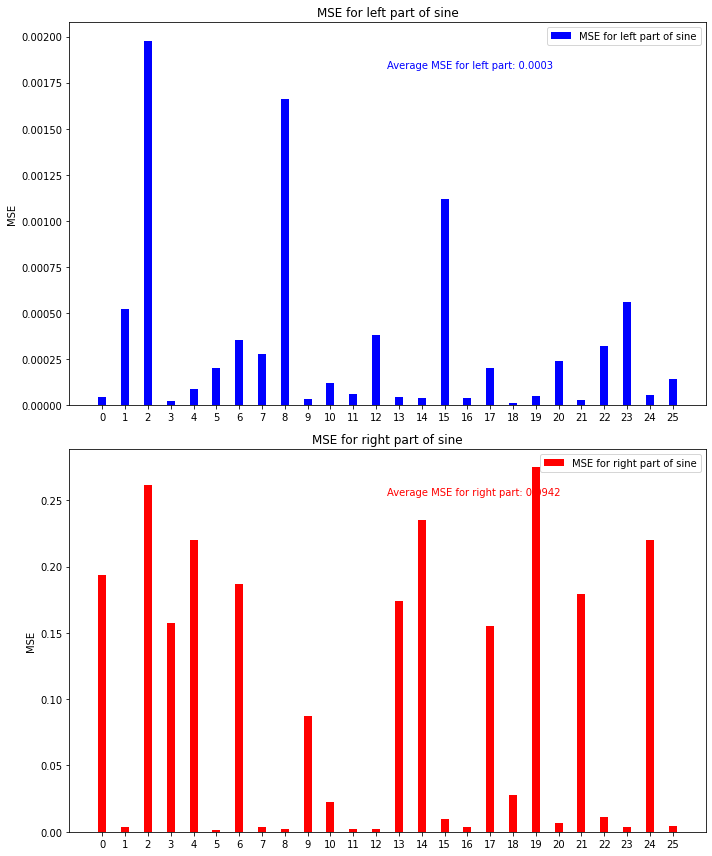

In [42]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_from_pickle_bar(file_path: str) -> None:
    """
    Load and plot MSE values from a pickle file as bar plots.
    
    Parameters:
    - file_path: Path to the pickle file containing MSE values.
    """
    # Load the MSE values from the pickle file
    with open(file_path, 'rb') as f:
        loaded_G_mse = pickle.load(f)

    # Extract MSE values from loaded_G_mse
    mse1_values = [mse[0] for mse in loaded_G_mse]
    mse2_values = [mse[1] for mse in loaded_G_mse]

    # Calculate average MSE values
    avg_mse1 = sum(mse1_values) / len(mse1_values)
    avg_mse2 = sum(mse2_values) / len(mse2_values)

    # Plot MSE values as bar plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    index = np.arange(len(mse1_values))
    bar_width = 0.35

    rects1 = ax1.bar(index, mse1_values, bar_width, label='MSE for left part of sine', color='b')
    ax1.set_ylabel('MSE')
    ax1.set_title('MSE for left part of sine')
    ax1.set_xticks(index)
    ax1.set_xticklabels([str(i) for i in range(len(mse1_values))])
    ax1.legend()
    
    rects2 = ax2.bar(index, mse2_values, bar_width, label='MSE for right part of sine', color='r')
    ax2.set_ylabel('MSE')
    ax2.set_title('MSE for right part of sine')
    ax2.set_xticks(index)
    ax2.set_xticklabels([str(i) for i in range(len(mse2_values))])
    ax2.legend()

    # Add text for average MSE values
    ax1.text(0.5, 0.9, f'Average MSE for left part: {avg_mse1:.4f}', transform=ax1.transAxes, fontsize=10, verticalalignment='top', color='b')
    ax2.text(0.5, 0.9, f'Average MSE for right part: {avg_mse2:.4f}', transform=ax2.transAxes, fontsize=10, verticalalignment='top', color='r')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_mse_from_pickle_bar(bce_mse_path)


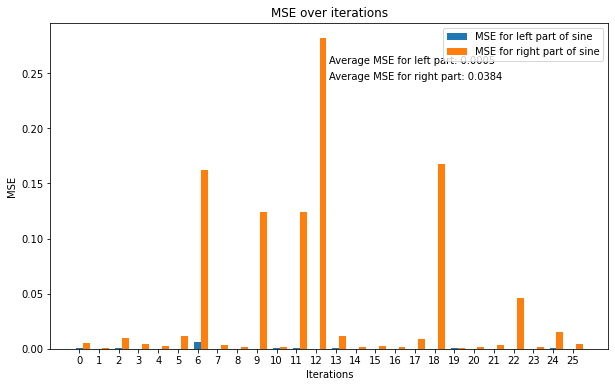

In [27]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_from_pickle_bar(file_path: str) -> None:
    """
    Load and plot MSE values from a pickle file as bar plots, with rects1 on the left and rects2 on the right.
    
    Parameters:
    - file_path: Path to the pickle file containing MSE values.
    """
    # Load the MSE values from the pickle file
    with open(file_path, 'rb') as f:
        loaded_G_mse = pickle.load(f)

    # Extract MSE values from loaded_G_mse
    mse1_values = [mse[0] for mse in loaded_G_mse]
    mse2_values = [mse[1] for mse in loaded_G_mse]

    # Calculate average MSE values
    avg_mse1 = sum(mse1_values) / len(mse1_values)
    avg_mse2 = sum(mse2_values) / len(mse2_values)

    # Plot MSE values as bar plots with rects1 on the left and rects2 on the right
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(mse1_values))
    rects1 = ax.bar(index, mse1_values, bar_width, label='MSE for left part of sine', align='edge')
    rects2 = ax.bar(index + bar_width, mse2_values, bar_width, label='MSE for right part of sine', align='edge')

    ax.set_xlabel('Iterations')
    ax.set_ylabel('MSE')
    ax.set_title('MSE over iterations')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([str(i) for i in range(len(mse1_values))])
    ax.legend()
    
    # Add text for average MSE values
    ax.text(0.5, 0.9, f'Average MSE for left part: {avg_mse1:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.text(0.5, 0.85, f'Average MSE for right part: {avg_mse2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

    plt.show()

# Example usage:
plot_mse_from_pickle_bar(file_path)


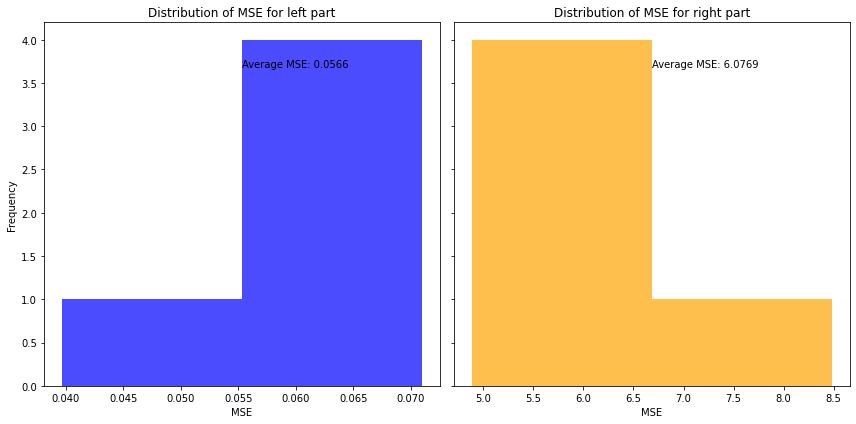

In [95]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_distribution(file_path: str) -> None:
    """
    Load and plot the distribution of MSE values from a pickle file as histograms, 
    with rects1 on the left and rects2 on the right.
    
    Parameters:
    - file_path: Path to the pickle file containing MSE values.
    """
    # Load the MSE values from the pickle file
    with open(file_path, 'rb') as f:
        loaded_G_mse = pickle.load(f)

    # Extract MSE values from loaded_G_mse
    mse1_values = [mse[0] for mse in loaded_G_mse]
    mse2_values = [mse[1] for mse in loaded_G_mse]

    # Calculate average MSE values
    avg_mse1 = sum(mse1_values) / len(mse1_values)
    avg_mse2 = sum(mse2_values) / len(mse2_values)

    # Plot MSE distributions as histograms with rects1 on the left and rects2 on the right
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    axs[0].hist(mse1_values, bins=2, color='blue', alpha=0.7, label='MSE for left part of sine')
    axs[1].hist(mse2_values, bins=2, color='orange', alpha=0.7, label='MSE for right part of sine')

    axs[0].set_xlabel('MSE')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Distribution of MSE for left part')
    axs[1].set_xlabel('MSE')
    axs[1].set_title('Distribution of MSE for right part')
    
    # Add text for average MSE values
    axs[0].text(0.5, 0.9, f'Average MSE: {avg_mse1:.4f}', transform=axs[0].transAxes, fontsize=10, verticalalignment='top')
    axs[1].text(0.5, 0.9, f'Average MSE: {avg_mse2:.4f}', transform=axs[1].transAxes, fontsize=10, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_mse_distribution(file_path)


In [26]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__lr_0,001_OneCycleLR__8_1'

# Adjust these parameters as needed
max_lr = 0.0005

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = False,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
    # n_split = 10
)

Folder 'base_gan__lr_0,001_OneCycleLR__8_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6950, average G_loss: 0.6467


  4%|█████▌                                                                                                                                    | 200/5000 [02:57<1:08:30,  1.17it/s]

epoch [200/5000], average D_loss: 0.6323, average G_loss: 0.8547


  8%|███████████                                                                                                                               | 400/5000 [05:58<1:04:57,  1.18it/s]

epoch [400/5000], average D_loss: 0.6495, average G_loss: 0.8377


 12%|████████████████▌                                                                                                                         | 600/5000 [08:56<1:05:00,  1.13it/s]

epoch [600/5000], average D_loss: 0.6891, average G_loss: 0.7033


 16%|██████████████████████                                                                                                                    | 800/5000 [11:55<1:07:15,  1.04it/s]

epoch [800/5000], average D_loss: 0.6931, average G_loss: 0.6933


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [14:55<59:17,  1.12it/s]

epoch [1000/5000], average D_loss: 0.6925, average G_loss: 0.6982


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [17:55<56:39,  1.12it/s]

epoch [1200/5000], average D_loss: 0.6924, average G_loss: 0.6937


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [20:59<52:32,  1.14it/s]

epoch [1400/5000], average D_loss: 0.6903, average G_loss: 0.7025


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [24:00<49:11,  1.15it/s]

epoch [1600/5000], average D_loss: 0.6857, average G_loss: 0.7008


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [27:02<46:35,  1.14it/s]

epoch [1800/5000], average D_loss: 0.6875, average G_loss: 0.7044


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [30:08<43:41,  1.14it/s]

epoch [2000/5000], average D_loss: 0.6906, average G_loss: 0.7214


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [33:13<42:12,  1.11it/s]

epoch [2200/5000], average D_loss: 0.6917, average G_loss: 0.7020


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [36:18<37:41,  1.15it/s]

epoch [2400/5000], average D_loss: 0.6926, average G_loss: 0.6931


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [39:21<37:33,  1.06it/s]

epoch [2600/5000], average D_loss: 0.6927, average G_loss: 0.6938


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [42:24<32:24,  1.13it/s]

epoch [2800/5000], average D_loss: 0.6933, average G_loss: 0.6926


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [45:26<29:33,  1.13it/s]

epoch [3000/5000], average D_loss: 0.6909, average G_loss: 0.6940


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [48:29<27:16,  1.10it/s]

epoch [3200/5000], average D_loss: 0.6938, average G_loss: 0.6974


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [51:36<26:58,  1.01s/it]

epoch [3400/5000], average D_loss: 0.6921, average G_loss: 0.6924


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [54:41<21:30,  1.08it/s]

epoch [3600/5000], average D_loss: 0.6934, average G_loss: 0.6943


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [57:37<16:45,  1.19it/s]

epoch [3800/5000], average D_loss: 0.6927, average G_loss: 0.6941


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4000/5000 [1:00:29<13:45,  1.21it/s]

epoch [4000/5000], average D_loss: 0.6929, average G_loss: 0.6936


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4200/5000 [1:03:20<10:56,  1.22it/s]

epoch [4200/5000], average D_loss: 0.6929, average G_loss: 0.6944


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:06:10<08:21,  1.20it/s]

epoch [4400/5000], average D_loss: 0.6928, average G_loss: 0.6941


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:08:59<05:30,  1.21it/s]

epoch [4600/5000], average D_loss: 0.6922, average G_loss: 0.6939


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:11:49<02:50,  1.17it/s]

epoch [4800/5000], average D_loss: 0.6926, average G_loss: 0.6940


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:14:39<00:00,  1.12it/s]


In [33]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__lr_0,001_OneCycleLR__15_1'

# Adjust these parameters as needed
max_lr = 0.0005

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = False,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
    # n_split = 10
)

Folder 'base_gan__lr_0,001_OneCycleLR__15_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.7065, average G_loss: 0.8473


  4%|█████▌                                                                                                                                    | 200/5000 [02:40<1:03:02,  1.27it/s]

epoch [200/5000], average D_loss: 0.5839, average G_loss: 1.0134


  8%|███████████                                                                                                                               | 400/5000 [05:21<1:00:35,  1.27it/s]

epoch [400/5000], average D_loss: 0.6740, average G_loss: 0.7582


 12%|████████████████▊                                                                                                                           | 600/5000 [08:03<59:36,  1.23it/s]

epoch [600/5000], average D_loss: 0.6600, average G_loss: 0.7531


 16%|██████████████████████▍                                                                                                                     | 800/5000 [10:46<56:38,  1.24it/s]

epoch [800/5000], average D_loss: 0.6924, average G_loss: 0.6906


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [13:30<54:34,  1.22it/s]

epoch [1000/5000], average D_loss: 0.6934, average G_loss: 0.6958


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [16:14<50:16,  1.26it/s]

epoch [1200/5000], average D_loss: 0.6928, average G_loss: 0.6918


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [18:57<48:31,  1.24it/s]

epoch [1400/5000], average D_loss: 0.6929, average G_loss: 0.6944


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [21:41<45:38,  1.24it/s]

epoch [1600/5000], average D_loss: 0.6937, average G_loss: 0.6974


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [24:24<43:35,  1.22it/s]

epoch [1800/5000], average D_loss: 0.6831, average G_loss: 0.7144


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [27:08<40:18,  1.24it/s]

epoch [2000/5000], average D_loss: 0.6537, average G_loss: 0.8061


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [29:53<37:42,  1.24it/s]

epoch [2200/5000], average D_loss: 0.6674, average G_loss: 0.7940


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [32:38<34:46,  1.25it/s]

epoch [2400/5000], average D_loss: 0.6803, average G_loss: 0.7518


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [35:24<33:59,  1.18it/s]

epoch [2600/5000], average D_loss: 0.6846, average G_loss: 0.7108


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [38:10<29:45,  1.23it/s]

epoch [2800/5000], average D_loss: 0.6844, average G_loss: 0.7198


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [40:58<27:13,  1.22it/s]

epoch [3000/5000], average D_loss: 0.6856, average G_loss: 0.7186


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [43:44<24:44,  1.21it/s]

epoch [3200/5000], average D_loss: 0.6842, average G_loss: 0.7211


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [46:33<22:13,  1.20it/s]

epoch [3400/5000], average D_loss: 0.6745, average G_loss: 0.8020


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [49:21<19:20,  1.21it/s]

epoch [3600/5000], average D_loss: 0.6720, average G_loss: 0.7818


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [52:08<16:21,  1.22it/s]

epoch [3800/5000], average D_loss: 0.6917, average G_loss: 0.7107


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [54:57<13:43,  1.21it/s]

epoch [4000/5000], average D_loss: 0.6889, average G_loss: 0.7183


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4200/5000 [57:45<11:01,  1.21it/s]

epoch [4200/5000], average D_loss: 0.6861, average G_loss: 0.7178


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:00:34<08:29,  1.18it/s]

epoch [4400/5000], average D_loss: 0.6857, average G_loss: 0.7144


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:03:22<05:24,  1.23it/s]

epoch [4600/5000], average D_loss: 0.6865, average G_loss: 0.7152


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:06:10<02:43,  1.22it/s]

epoch [4800/5000], average D_loss: 0.6846, average G_loss: 0.7239


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:08:59<00:00,  1.21it/s]


In [19]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__lr_0,001_OneCycleLR__16_1'

# Adjust these parameters as needed
max_lr = 0.0005

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = False,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
    # n_split = 10
)

Folder 'base_gan__lr_0,001_OneCycleLR__16_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6940, average G_loss: 0.7505


  4%|█████▌                                                                                                                                    | 200/5000 [02:47<1:04:57,  1.23it/s]

epoch [200/5000], average D_loss: 0.6382, average G_loss: 0.8040


  8%|███████████                                                                                                                               | 400/5000 [05:29<1:01:55,  1.24it/s]

epoch [400/5000], average D_loss: 0.6533, average G_loss: 0.7944


 12%|████████████████▊                                                                                                                           | 600/5000 [08:24<59:58,  1.22it/s]

epoch [600/5000], average D_loss: 0.6880, average G_loss: 0.7369


 16%|██████████████████████▍                                                                                                                     | 800/5000 [11:11<57:21,  1.22it/s]

epoch [800/5000], average D_loss: 0.6924, average G_loss: 0.6980


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [14:00<55:01,  1.21it/s]

epoch [1000/5000], average D_loss: 0.6934, average G_loss: 0.6927


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [16:49<52:43,  1.20it/s]

epoch [1200/5000], average D_loss: 0.6883, average G_loss: 0.7041


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [19:38<51:17,  1.17it/s]

epoch [1400/5000], average D_loss: 0.6892, average G_loss: 0.7042


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [22:29<53:06,  1.07it/s]

epoch [1600/5000], average D_loss: 0.6773, average G_loss: 0.7382


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [25:20<43:18,  1.23it/s]

epoch [1800/5000], average D_loss: 0.6848, average G_loss: 0.7401


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [28:10<41:33,  1.20it/s]

epoch [2000/5000], average D_loss: 0.6829, average G_loss: 0.7506


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [31:00<39:49,  1.17it/s]

epoch [2200/5000], average D_loss: 0.6915, average G_loss: 0.7502


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [33:50<36:27,  1.19it/s]

epoch [2400/5000], average D_loss: 0.6756, average G_loss: 0.7738


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [36:41<34:24,  1.16it/s]

epoch [2600/5000], average D_loss: 0.6816, average G_loss: 0.7466


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [39:37<30:36,  1.20it/s]

epoch [2800/5000], average D_loss: 0.6915, average G_loss: 0.7081


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [42:29<27:43,  1.20it/s]

epoch [3000/5000], average D_loss: 0.6877, average G_loss: 0.7254


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [45:20<24:51,  1.21it/s]

epoch [3200/5000], average D_loss: 0.6909, average G_loss: 0.7114


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [48:12<22:21,  1.19it/s]

epoch [3400/5000], average D_loss: 0.6897, average G_loss: 0.7201


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [51:05<19:32,  1.19it/s]

epoch [3600/5000], average D_loss: 0.6855, average G_loss: 0.7219


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [54:02<19:51,  1.01it/s]

epoch [3800/5000], average D_loss: 0.6925, average G_loss: 0.6976


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [56:56<14:17,  1.17it/s]

epoch [4000/5000], average D_loss: 0.6908, average G_loss: 0.6972


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4200/5000 [59:49<11:24,  1.17it/s]

epoch [4200/5000], average D_loss: 0.6907, average G_loss: 0.7038


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:02:43<08:27,  1.18it/s]

epoch [4400/5000], average D_loss: 0.6906, average G_loss: 0.7006


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:05:37<05:43,  1.16it/s]

epoch [4600/5000], average D_loss: 0.6896, average G_loss: 0.7010


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:08:30<02:47,  1.19it/s]

epoch [4800/5000], average D_loss: 0.6898, average G_loss: 0.7002


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:11:27<00:00,  1.17it/s]


In [20]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__lr_0,001_OneCycleLR__17_1'

# Adjust these parameters as needed
max_lr = 0.0005

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = False,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
    # n_split = 10
)

Folder 'base_gan__lr_0,001_OneCycleLR__17_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6935, average G_loss: 0.6773


  4%|█████▌                                                                                                                                    | 200/5000 [02:46<1:06:32,  1.20it/s]

epoch [200/5000], average D_loss: 0.6430, average G_loss: 0.8203


  8%|███████████                                                                                                                               | 400/5000 [05:34<1:03:12,  1.21it/s]

epoch [400/5000], average D_loss: 0.6701, average G_loss: 0.7592


 12%|████████████████▌                                                                                                                         | 600/5000 [08:27<1:00:54,  1.20it/s]

epoch [600/5000], average D_loss: 0.6924, average G_loss: 0.6984


 16%|██████████████████████▍                                                                                                                     | 800/5000 [11:16<57:50,  1.21it/s]

epoch [800/5000], average D_loss: 0.6937, average G_loss: 0.6932


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [14:07<57:18,  1.16it/s]

epoch [1000/5000], average D_loss: 0.6923, average G_loss: 0.6939


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [16:57<52:37,  1.20it/s]

epoch [1200/5000], average D_loss: 0.6934, average G_loss: 0.6996


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [19:48<50:05,  1.20it/s]

epoch [1400/5000], average D_loss: 0.6879, average G_loss: 0.7194


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [22:42<47:09,  1.20it/s]

epoch [1600/5000], average D_loss: 0.6731, average G_loss: 0.7322


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [25:32<45:35,  1.17it/s]

epoch [1800/5000], average D_loss: 0.6727, average G_loss: 0.7576


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [28:22<42:23,  1.18it/s]

epoch [2000/5000], average D_loss: 0.6650, average G_loss: 0.8254


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [31:13<39:15,  1.19it/s]

epoch [2200/5000], average D_loss: 0.6784, average G_loss: 0.7947


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [34:04<36:31,  1.19it/s]

epoch [2400/5000], average D_loss: 0.6810, average G_loss: 0.7870


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [37:01<36:56,  1.08it/s]

epoch [2600/5000], average D_loss: 0.6792, average G_loss: 0.8015


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [40:03<29:48,  1.23it/s]

epoch [2800/5000], average D_loss: 0.6699, average G_loss: 0.8548


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [42:55<29:26,  1.13it/s]

epoch [3000/5000], average D_loss: 0.6756, average G_loss: 0.8270


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [45:50<24:28,  1.23it/s]

epoch [3200/5000], average D_loss: 0.6741, average G_loss: 0.7856


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [48:57<24:32,  1.09it/s]

epoch [3400/5000], average D_loss: 0.6819, average G_loss: 0.7689


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [51:47<19:38,  1.19it/s]

epoch [3600/5000], average D_loss: 0.6764, average G_loss: 0.7707


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [54:41<16:27,  1.22it/s]

epoch [3800/5000], average D_loss: 0.6788, average G_loss: 0.7972


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [57:32<13:51,  1.20it/s]

epoch [4000/5000], average D_loss: 0.6797, average G_loss: 0.7797


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4200/5000 [1:00:22<11:00,  1.21it/s]

epoch [4200/5000], average D_loss: 0.6807, average G_loss: 0.7942


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:03:13<08:28,  1.18it/s]

epoch [4400/5000], average D_loss: 0.6773, average G_loss: 0.7663


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:06:04<05:31,  1.21it/s]

epoch [4600/5000], average D_loss: 0.6789, average G_loss: 0.8201


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:08:58<03:04,  1.09it/s]

epoch [4800/5000], average D_loss: 0.6815, average G_loss: 0.7833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:11:49<00:00,  1.16it/s]


In [21]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__lr_0,001_OneCycleLR__18_1'

# Adjust these parameters as needed
max_lr = 0.0005

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = False,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
    # n_split = 10
)

Folder 'base_gan__lr_0,001_OneCycleLR__18_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6967, average G_loss: 0.7314


  4%|█████▌                                                                                                                                    | 200/5000 [02:44<1:04:18,  1.24it/s]

epoch [200/5000], average D_loss: 0.6165, average G_loss: 0.9328


  8%|███████████                                                                                                                               | 400/5000 [05:30<1:07:24,  1.14it/s]

epoch [400/5000], average D_loss: 0.6487, average G_loss: 0.8651


 12%|████████████████▊                                                                                                                           | 600/5000 [08:17<58:53,  1.25it/s]

epoch [600/5000], average D_loss: 0.6847, average G_loss: 0.7669


 16%|██████████████████████▍                                                                                                                     | 800/5000 [11:04<58:00,  1.21it/s]

epoch [800/5000], average D_loss: 0.6938, average G_loss: 0.6943


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [13:50<54:31,  1.22it/s]

epoch [1000/5000], average D_loss: 0.6924, average G_loss: 0.6991


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [16:37<52:02,  1.22it/s]

epoch [1200/5000], average D_loss: 0.6923, average G_loss: 0.6983


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [19:24<49:02,  1.22it/s]

epoch [1400/5000], average D_loss: 0.6880, average G_loss: 0.7032


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [22:14<46:27,  1.22it/s]

epoch [1600/5000], average D_loss: 0.6889, average G_loss: 0.7088


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [25:01<43:27,  1.23it/s]

epoch [1800/5000], average D_loss: 0.6930, average G_loss: 0.7038


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [27:48<42:04,  1.19it/s]

epoch [2000/5000], average D_loss: 0.6897, average G_loss: 0.6970


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [30:35<38:29,  1.21it/s]

epoch [2200/5000], average D_loss: 0.6907, average G_loss: 0.6954


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [33:22<36:31,  1.19it/s]

epoch [2400/5000], average D_loss: 0.6885, average G_loss: 0.7035


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [36:10<32:49,  1.22it/s]

epoch [2600/5000], average D_loss: 0.6885, average G_loss: 0.7144


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [38:59<29:46,  1.23it/s]

epoch [2800/5000], average D_loss: 0.6905, average G_loss: 0.7067


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [41:46<27:43,  1.20it/s]

epoch [3000/5000], average D_loss: 0.6869, average G_loss: 0.7142


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [44:33<24:28,  1.23it/s]

epoch [3200/5000], average D_loss: 0.6884, average G_loss: 0.7066


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [47:21<22:23,  1.19it/s]

epoch [3400/5000], average D_loss: 0.6900, average G_loss: 0.6942


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [50:08<18:55,  1.23it/s]

epoch [3600/5000], average D_loss: 0.6914, average G_loss: 0.7049


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [52:57<16:31,  1.21it/s]

epoch [3800/5000], average D_loss: 0.6834, average G_loss: 0.7151


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [55:46<13:38,  1.22it/s]

epoch [4000/5000], average D_loss: 0.6876, average G_loss: 0.7019


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4200/5000 [58:34<10:56,  1.22it/s]

epoch [4200/5000], average D_loss: 0.6848, average G_loss: 0.7092


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:01:22<08:16,  1.21it/s]

epoch [4400/5000], average D_loss: 0.6867, average G_loss: 0.7222


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:04:11<05:31,  1.21it/s]

epoch [4600/5000], average D_loss: 0.6847, average G_loss: 0.7182


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:06:59<02:52,  1.16it/s]

epoch [4800/5000], average D_loss: 0.6841, average G_loss: 0.7118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:09:50<00:00,  1.19it/s]


In [27]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__lr_0,001_OneCycleLR__9_1'

# Adjust these parameters as needed
max_lr = 0.0005

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = False,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
    # n_split = 10
)

Folder 'base_gan__lr_0,001_OneCycleLR__9_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6972, average G_loss: 0.7288


  4%|█████▌                                                                                                                                    | 200/5000 [02:44<1:04:25,  1.24it/s]

epoch [200/5000], average D_loss: 0.6079, average G_loss: 0.9630


  8%|███████████                                                                                                                               | 400/5000 [05:27<1:01:16,  1.25it/s]

epoch [400/5000], average D_loss: 0.6423, average G_loss: 0.8610


 12%|████████████████▌                                                                                                                         | 600/5000 [08:12<1:00:29,  1.21it/s]

epoch [600/5000], average D_loss: 0.6902, average G_loss: 0.7019


 16%|██████████████████████▍                                                                                                                     | 800/5000 [10:57<58:42,  1.19it/s]

epoch [800/5000], average D_loss: 0.6927, average G_loss: 0.6890


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [13:43<55:00,  1.21it/s]

epoch [1000/5000], average D_loss: 0.6926, average G_loss: 0.6924


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [16:29<54:03,  1.17it/s]

epoch [1200/5000], average D_loss: 0.6931, average G_loss: 0.6915


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [19:16<50:14,  1.19it/s]

epoch [1400/5000], average D_loss: 0.6929, average G_loss: 0.6947


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [22:03<47:16,  1.20it/s]

epoch [1600/5000], average D_loss: 0.6862, average G_loss: 0.7061


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [24:48<43:47,  1.22it/s]

epoch [1800/5000], average D_loss: 0.6853, average G_loss: 0.7381


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [27:36<41:25,  1.21it/s]

epoch [2000/5000], average D_loss: 0.6678, average G_loss: 0.7872


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [30:22<38:52,  1.20it/s]

epoch [2200/5000], average D_loss: 0.6797, average G_loss: 0.8119


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [33:10<35:40,  1.21it/s]

epoch [2400/5000], average D_loss: 0.6798, average G_loss: 0.7952


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [35:58<33:29,  1.19it/s]

epoch [2600/5000], average D_loss: 0.6806, average G_loss: 0.7956


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [38:46<32:08,  1.14it/s]

epoch [2800/5000], average D_loss: 0.6793, average G_loss: 0.7471


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [41:34<27:57,  1.19it/s]

epoch [3000/5000], average D_loss: 0.6697, average G_loss: 0.7640


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [44:22<24:27,  1.23it/s]

epoch [3200/5000], average D_loss: 0.6898, average G_loss: 0.7050


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [47:11<22:25,  1.19it/s]

epoch [3400/5000], average D_loss: 0.6843, average G_loss: 0.7373


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [50:00<20:00,  1.17it/s]

epoch [3600/5000], average D_loss: 0.6858, average G_loss: 0.7149


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [52:49<16:36,  1.20it/s]

epoch [3800/5000], average D_loss: 0.6888, average G_loss: 0.7069


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [55:37<13:41,  1.22it/s]

epoch [4000/5000], average D_loss: 0.6811, average G_loss: 0.7235


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4200/5000 [58:26<10:57,  1.22it/s]

epoch [4200/5000], average D_loss: 0.6852, average G_loss: 0.7081


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:01:14<08:28,  1.18it/s]

epoch [4400/5000], average D_loss: 0.6898, average G_loss: 0.7087


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:04:05<05:27,  1.22it/s]

epoch [4600/5000], average D_loss: 0.6895, average G_loss: 0.7013


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:06:54<02:44,  1.22it/s]

epoch [4800/5000], average D_loss: 0.6893, average G_loss: 0.7100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:09:44<00:00,  1.19it/s]


In [28]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__lr_0,001_OneCycleLR__10_1'

# Adjust these parameters as needed
max_lr = 0.0005

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = False,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
    # n_split = 10
)

Folder 'base_gan__lr_0,001_OneCycleLR__10_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6966, average G_loss: 0.7410


  4%|█████▌                                                                                                                                    | 200/5000 [02:44<1:06:11,  1.21it/s]

epoch [200/5000], average D_loss: 0.6345, average G_loss: 0.8137


  8%|███████████                                                                                                                               | 400/5000 [05:29<1:02:56,  1.22it/s]

epoch [400/5000], average D_loss: 0.6542, average G_loss: 0.7841


 12%|████████████████▊                                                                                                                           | 600/5000 [08:14<59:58,  1.22it/s]

epoch [600/5000], average D_loss: 0.6580, average G_loss: 0.8245


 16%|██████████████████████▍                                                                                                                     | 800/5000 [11:00<59:25,  1.18it/s]

epoch [800/5000], average D_loss: 0.6931, average G_loss: 0.6919


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [13:46<55:12,  1.21it/s]

epoch [1000/5000], average D_loss: 0.6935, average G_loss: 0.6974


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [16:32<51:57,  1.22it/s]

epoch [1200/5000], average D_loss: 0.6936, average G_loss: 0.6967


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [19:20<50:25,  1.19it/s]

epoch [1400/5000], average D_loss: 0.6924, average G_loss: 0.6957


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [22:06<45:58,  1.23it/s]

epoch [1600/5000], average D_loss: 0.6884, average G_loss: 0.7021


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [24:53<43:57,  1.21it/s]

epoch [1800/5000], average D_loss: 0.6871, average G_loss: 0.7031


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [27:40<42:35,  1.17it/s]

epoch [2000/5000], average D_loss: 0.6866, average G_loss: 0.7311


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [30:26<37:26,  1.25it/s]

epoch [2200/5000], average D_loss: 0.6841, average G_loss: 0.7271


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [33:14<35:01,  1.24it/s]

epoch [2400/5000], average D_loss: 0.6818, average G_loss: 0.7399


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [36:02<33:39,  1.19it/s]

epoch [2600/5000], average D_loss: 0.6824, average G_loss: 0.7514


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [38:50<31:02,  1.18it/s]

epoch [2800/5000], average D_loss: 0.6854, average G_loss: 0.7455


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [41:39<30:12,  1.10it/s]

epoch [3000/5000], average D_loss: 0.6858, average G_loss: 0.7443


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [44:28<24:30,  1.22it/s]

epoch [3200/5000], average D_loss: 0.6896, average G_loss: 0.7217


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [47:18<22:27,  1.19it/s]

epoch [3400/5000], average D_loss: 0.6934, average G_loss: 0.7019


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [50:09<19:43,  1.18it/s]

epoch [3600/5000], average D_loss: 0.6892, average G_loss: 0.7064


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [53:00<17:48,  1.12it/s]

epoch [3800/5000], average D_loss: 0.6920, average G_loss: 0.6993


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [55:50<14:34,  1.14it/s]

epoch [4000/5000], average D_loss: 0.6910, average G_loss: 0.6996


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4200/5000 [58:39<10:50,  1.23it/s]

epoch [4200/5000], average D_loss: 0.6892, average G_loss: 0.6972


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:01:29<08:34,  1.17it/s]

epoch [4400/5000], average D_loss: 0.6916, average G_loss: 0.7013


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:04:19<05:37,  1.19it/s]

epoch [4600/5000], average D_loss: 0.6916, average G_loss: 0.7019


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:07:10<02:53,  1.15it/s]

epoch [4800/5000], average D_loss: 0.6940, average G_loss: 0.7008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:10:00<00:00,  1.19it/s]


In [29]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__lr_0,001_OneCycleLR__11_1'

# Adjust these parameters as needed
max_lr = 0.0005

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = False,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
    # n_split = 10
)

Folder 'base_gan__lr_0,001_OneCycleLR__11_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.6946, average G_loss: 0.6310


  4%|█████▌                                                                                                                                    | 200/5000 [02:43<1:05:24,  1.22it/s]

epoch [200/5000], average D_loss: 0.6088, average G_loss: 0.8945


  8%|███████████                                                                                                                               | 400/5000 [05:29<1:02:31,  1.23it/s]

epoch [400/5000], average D_loss: 0.6467, average G_loss: 0.8353


 12%|████████████████▊                                                                                                                           | 600/5000 [08:14<58:31,  1.25it/s]

epoch [600/5000], average D_loss: 0.6449, average G_loss: 0.9336


 16%|██████████████████████▍                                                                                                                     | 800/5000 [11:00<57:59,  1.21it/s]

epoch [800/5000], average D_loss: 0.6679, average G_loss: 0.7514


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [13:47<55:04,  1.21it/s]

epoch [1000/5000], average D_loss: 0.6669, average G_loss: 0.7584


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [16:34<52:51,  1.20it/s]

epoch [1200/5000], average D_loss: 0.6599, average G_loss: 0.8004


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [19:22<49:51,  1.20it/s]

epoch [1400/5000], average D_loss: 0.6608, average G_loss: 0.8435


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [22:09<50:31,  1.12it/s]

epoch [1600/5000], average D_loss: 0.6048, average G_loss: 1.1312


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [24:56<43:05,  1.24it/s]

epoch [1800/5000], average D_loss: 0.6135, average G_loss: 1.1586


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [27:44<41:04,  1.22it/s]

epoch [2000/5000], average D_loss: 0.5529, average G_loss: 1.4137


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [30:31<39:21,  1.19it/s]

epoch [2200/5000], average D_loss: 0.6150, average G_loss: 1.2015


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [33:18<36:35,  1.18it/s]

epoch [2400/5000], average D_loss: 0.5885, average G_loss: 1.3354


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [36:08<34:34,  1.16it/s]

epoch [2600/5000], average D_loss: 0.5772, average G_loss: 1.4317


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [38:58<31:01,  1.18it/s]

epoch [2800/5000], average D_loss: 0.6307, average G_loss: 1.0812


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [41:46<28:43,  1.16it/s]

epoch [3000/5000], average D_loss: 0.5681, average G_loss: 1.4172


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [44:37<25:19,  1.18it/s]

epoch [3200/5000], average D_loss: 0.6113, average G_loss: 1.2649


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [47:26<22:58,  1.16it/s]

epoch [3400/5000], average D_loss: 0.6275, average G_loss: 1.0427


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [50:16<19:04,  1.22it/s]

epoch [3600/5000], average D_loss: 0.6217, average G_loss: 1.1596


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [53:05<16:49,  1.19it/s]

epoch [3800/5000], average D_loss: 0.5978, average G_loss: 1.0834


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [55:55<13:34,  1.23it/s]

epoch [4000/5000], average D_loss: 0.6195, average G_loss: 1.1288


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4200/5000 [58:45<11:12,  1.19it/s]

epoch [4200/5000], average D_loss: 0.6091, average G_loss: 1.1135


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:01:35<08:32,  1.17it/s]

epoch [4400/5000], average D_loss: 0.6072, average G_loss: 1.0837


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:04:25<05:30,  1.21it/s]

epoch [4600/5000], average D_loss: 0.6030, average G_loss: 1.0554


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:07:16<02:54,  1.14it/s]

epoch [4800/5000], average D_loss: 0.6052, average G_loss: 1.1350


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:10:05<00:00,  1.19it/s]


In [30]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = WeightedIntervalCrossEntropyLoss()
# loss_function = nn.BCELoss()

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
NAME = 'base_gan__variance__2_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__12_1'
# Adjust these parameters as needed
max_lr = 0.0005  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 2,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
)
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance__2_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__12_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.4941, average G_loss: 0.5041


  4%|█████▌                                                                                                                                    | 200/5000 [02:48<1:06:21,  1.21it/s]

epoch [200/5000], average D_loss: 0.2067, average G_loss: 0.3474


  8%|███████████                                                                                                                               | 400/5000 [05:36<1:05:57,  1.16it/s]

epoch [400/5000], average D_loss: 0.1579, average G_loss: 0.2110


 12%|████████████████▌                                                                                                                         | 600/5000 [08:23<1:00:54,  1.20it/s]

epoch [600/5000], average D_loss: 0.1157, average G_loss: 0.1407


 16%|██████████████████████▍                                                                                                                     | 800/5000 [11:12<59:20,  1.18it/s]

epoch [800/5000], average D_loss: 0.1263, average G_loss: 0.1296


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [14:01<55:48,  1.19it/s]

epoch [1000/5000], average D_loss: 0.1336, average G_loss: 0.1343


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [16:52<53:05,  1.19it/s]

epoch [1200/5000], average D_loss: 0.1759, average G_loss: 0.1795


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [19:43<52:14,  1.15it/s]

epoch [1400/5000], average D_loss: 0.1086, average G_loss: 0.1278


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [22:33<50:03,  1.13it/s]

epoch [1600/5000], average D_loss: 0.0723, average G_loss: 0.0808


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [25:22<43:52,  1.22it/s]

epoch [1800/5000], average D_loss: 0.0555, average G_loss: 0.0755


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [28:12<41:14,  1.21it/s]

epoch [2000/5000], average D_loss: 0.0574, average G_loss: 0.0780


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [31:03<40:04,  1.16it/s]

epoch [2200/5000], average D_loss: 0.0537, average G_loss: 0.0746


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [33:53<37:16,  1.16it/s]

epoch [2400/5000], average D_loss: 0.0525, average G_loss: 0.0827


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [36:46<34:11,  1.17it/s]

epoch [2600/5000], average D_loss: 0.0491, average G_loss: 0.1014


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [39:38<31:02,  1.18it/s]

epoch [2800/5000], average D_loss: 0.0526, average G_loss: 0.0831


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [42:30<27:59,  1.19it/s]

epoch [3000/5000], average D_loss: 0.0591, average G_loss: 0.0905


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [45:23<24:59,  1.20it/s]

epoch [3200/5000], average D_loss: 0.0588, average G_loss: 0.0901


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [48:15<23:25,  1.14it/s]

epoch [3400/5000], average D_loss: 0.0595, average G_loss: 0.0720


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [51:08<19:33,  1.19it/s]

epoch [3600/5000], average D_loss: 0.0583, average G_loss: 0.0854


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [54:01<17:53,  1.12it/s]

epoch [3800/5000], average D_loss: 0.0541, average G_loss: 0.0645


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [56:55<14:35,  1.14it/s]

epoch [4000/5000], average D_loss: 0.0606, average G_loss: 0.0744


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4200/5000 [59:49<13:18,  1.00it/s]

epoch [4200/5000], average D_loss: 0.0585, average G_loss: 0.0745


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:02:43<08:29,  1.18it/s]

epoch [4400/5000], average D_loss: 0.0641, average G_loss: 0.0745


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:05:37<05:36,  1.19it/s]

epoch [4600/5000], average D_loss: 0.0627, average G_loss: 0.0822


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:08:32<02:48,  1.18it/s]

epoch [4800/5000], average D_loss: 0.0658, average G_loss: 0.0871


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:11:25<00:00,  1.17it/s]


In [31]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = WeightedIntervalCrossEntropyLoss()
# loss_function = nn.BCELoss()

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
NAME = 'base_gan__variance__6_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__13_1'
# Adjust these parameters as needed
max_lr = 0.0005  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 6,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
)
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance__6_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__13_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.0756, average G_loss: 0.0785


  4%|█████▌                                                                                                                                    | 200/5000 [02:47<1:04:29,  1.24it/s]

epoch [200/5000], average D_loss: 0.0987, average G_loss: 0.1063


  8%|███████████                                                                                                                               | 400/5000 [05:35<1:03:17,  1.21it/s]

epoch [400/5000], average D_loss: 0.1508, average G_loss: 0.1792


 12%|████████████████▌                                                                                                                         | 600/5000 [08:24<1:00:14,  1.22it/s]

epoch [600/5000], average D_loss: 0.1163, average G_loss: 0.1511


 16%|██████████████████████▍                                                                                                                     | 800/5000 [11:13<58:55,  1.19it/s]

epoch [800/5000], average D_loss: 0.0321, average G_loss: 0.0356


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [14:03<57:17,  1.16it/s]

epoch [1000/5000], average D_loss: 0.0495, average G_loss: 0.0504


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [16:52<54:02,  1.17it/s]

epoch [1200/5000], average D_loss: 0.1165, average G_loss: 0.1236


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [19:42<50:13,  1.19it/s]

epoch [1400/5000], average D_loss: 0.1562, average G_loss: 0.2938


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [22:31<47:43,  1.19it/s]

epoch [1600/5000], average D_loss: 0.0197, average G_loss: 0.0530


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [25:21<44:11,  1.21it/s]

epoch [1800/5000], average D_loss: 0.0208, average G_loss: 0.0499


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [28:11<41:53,  1.19it/s]

epoch [2000/5000], average D_loss: 0.0249, average G_loss: 0.0647


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [31:02<39:51,  1.17it/s]

epoch [2200/5000], average D_loss: 0.0174, average G_loss: 0.1390


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [33:53<36:35,  1.18it/s]

epoch [2400/5000], average D_loss: 0.0190, average G_loss: 0.0964


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [36:46<33:24,  1.20it/s]

epoch [2600/5000], average D_loss: 0.0255, average G_loss: 0.0789


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [39:37<30:24,  1.21it/s]

epoch [2800/5000], average D_loss: 0.0181, average G_loss: 0.0865


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [42:28<27:56,  1.19it/s]

epoch [3000/5000], average D_loss: 0.0219, average G_loss: 0.0622


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [45:19<25:37,  1.17it/s]

epoch [3200/5000], average D_loss: 0.0398, average G_loss: 0.0764


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [48:12<22:16,  1.20it/s]

epoch [3400/5000], average D_loss: 0.0821, average G_loss: 0.1126


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [51:05<21:44,  1.07it/s]

epoch [3600/5000], average D_loss: 0.0464, average G_loss: 0.1197


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [53:59<17:14,  1.16it/s]

epoch [3800/5000], average D_loss: 0.0569, average G_loss: 0.0629


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [56:51<14:02,  1.19it/s]

epoch [4000/5000], average D_loss: 0.0578, average G_loss: 0.0660


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4200/5000 [59:44<12:13,  1.09it/s]

epoch [4200/5000], average D_loss: 0.0558, average G_loss: 0.0657


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:02:38<08:15,  1.21it/s]

epoch [4400/5000], average D_loss: 0.0626, average G_loss: 0.0718


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:05:33<05:42,  1.17it/s]

epoch [4600/5000], average D_loss: 0.0486, average G_loss: 0.0578


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:08:26<02:49,  1.18it/s]

epoch [4800/5000], average D_loss: 0.0409, average G_loss: 0.0504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:11:16<00:00,  1.17it/s]


In [32]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = WeightedIntervalCrossEntropyLoss()
# loss_function = nn.BCELoss()

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
NAME = 'base_gan__variance__20_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__14_1'
# Adjust these parameters as needed
max_lr = 0.0005  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 20,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G,
    info_n = 200
)
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance__20_split__accurate_wieights_0,01_OneCycleLR__lr_0,0001__14_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.0350, average G_loss: 0.0314


  4%|█████▌                                                                                                                                    | 200/5000 [02:45<1:05:08,  1.23it/s]

epoch [200/5000], average D_loss: 0.0262, average G_loss: 0.0310


  8%|███████████                                                                                                                               | 400/5000 [05:31<1:04:22,  1.19it/s]

epoch [400/5000], average D_loss: 0.0190, average G_loss: 0.0316


 12%|████████████████▊                                                                                                                           | 600/5000 [08:18<59:52,  1.22it/s]

epoch [600/5000], average D_loss: 0.0161, average G_loss: 0.0231


 16%|██████████████████████▍                                                                                                                     | 800/5000 [11:04<58:45,  1.19it/s]

epoch [800/5000], average D_loss: 0.0125, average G_loss: 0.0132


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [13:52<56:40,  1.18it/s]

epoch [1000/5000], average D_loss: 0.0127, average G_loss: 0.0147


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [16:39<52:22,  1.21it/s]

epoch [1200/5000], average D_loss: 0.0112, average G_loss: 0.0174


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [19:28<49:49,  1.20it/s]

epoch [1400/5000], average D_loss: 0.0122, average G_loss: 0.0171


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [22:17<46:41,  1.21it/s]

epoch [1600/5000], average D_loss: 0.0110, average G_loss: 0.0150


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [25:05<45:26,  1.17it/s]

epoch [1800/5000], average D_loss: 0.0115, average G_loss: 0.0242


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [27:53<42:26,  1.18it/s]

epoch [2000/5000], average D_loss: 0.0123, average G_loss: 0.0175


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [30:42<39:03,  1.19it/s]

epoch [2200/5000], average D_loss: 0.0116, average G_loss: 0.0138


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [33:30<35:28,  1.22it/s]

epoch [2400/5000], average D_loss: 0.0134, average G_loss: 0.0136


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [36:20<33:07,  1.21it/s]

epoch [2600/5000], average D_loss: 0.0202, average G_loss: 0.0199


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [39:10<31:34,  1.16it/s]

epoch [2800/5000], average D_loss: 0.0248, average G_loss: 0.0281


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [42:01<27:42,  1.20it/s]

epoch [3000/5000], average D_loss: 0.0116, average G_loss: 0.0118


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [44:52<25:46,  1.16it/s]

epoch [3200/5000], average D_loss: 0.0112, average G_loss: 0.0113


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [47:43<22:29,  1.19it/s]

epoch [3400/5000], average D_loss: 0.0165, average G_loss: 0.0166


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [50:34<19:52,  1.17it/s]

epoch [3600/5000], average D_loss: 0.0105, average G_loss: 0.0109


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [53:25<17:24,  1.15it/s]

epoch [3800/5000], average D_loss: 0.0114, average G_loss: 0.0116


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [56:17<14:14,  1.17it/s]

epoch [4000/5000], average D_loss: 0.0107, average G_loss: 0.0109


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4200/5000 [59:07<11:43,  1.14it/s]

epoch [4200/5000], average D_loss: 0.0147, average G_loss: 0.0149


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4400/5000 [1:01:58<08:16,  1.21it/s]

epoch [4400/5000], average D_loss: 0.0157, average G_loss: 0.0161


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 4600/5000 [1:04:50<05:36,  1.19it/s]

epoch [4600/5000], average D_loss: 0.0168, average G_loss: 0.0167


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4800/5000 [1:07:47<03:17,  1.01it/s]

epoch [4800/5000], average D_loss: 0.0166, average G_loss: 0.0171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:10:49<00:00,  1.18it/s]


In [772]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 1000
loss_function = WeightedIntervalCrossEntropyLoss()
# loss_function = nn.BCELoss()

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
NAME = 'base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,001__3_1'
# Adjust these parameters as needed
max_lr = 0.0005  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 4,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
)
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,001__3_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.1377, average G_loss: 0.1498


  2%|██▊                                                                                                                                          | 20/1000 [00:09<06:22,  2.56it/s]

epoch [20/1000], average D_loss: 0.1078, average G_loss: 0.1081


  4%|█████▋                                                                                                                                       | 40/1000 [00:19<05:52,  2.72it/s]

epoch [40/1000], average D_loss: 0.1190, average G_loss: 0.1270


  6%|████████▍                                                                                                                                    | 60/1000 [00:28<05:44,  2.73it/s]

epoch [60/1000], average D_loss: 0.1198, average G_loss: 0.1440


  8%|███████████▎                                                                                                                                 | 80/1000 [00:38<05:41,  2.70it/s]

epoch [80/1000], average D_loss: 0.1373, average G_loss: 0.1658


 10%|██████████████                                                                                                                              | 100/1000 [00:47<05:40,  2.65it/s]

epoch [100/1000], average D_loss: 0.1188, average G_loss: 0.1303


 12%|████████████████▊                                                                                                                           | 120/1000 [00:56<05:48,  2.53it/s]

epoch [120/1000], average D_loss: 0.1345, average G_loss: 0.1826


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:05<05:18,  2.70it/s]

epoch [140/1000], average D_loss: 0.1350, average G_loss: 0.2126


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:14<05:20,  2.62it/s]

epoch [160/1000], average D_loss: 0.1112, average G_loss: 0.2108


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:24<05:10,  2.64it/s]

epoch [180/1000], average D_loss: 0.1125, average G_loss: 0.2066


 20%|████████████████████████████                                                                                                                | 200/1000 [01:33<05:36,  2.38it/s]

epoch [200/1000], average D_loss: 0.1466, average G_loss: 0.2332


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [01:42<04:52,  2.66it/s]

epoch [220/1000], average D_loss: 0.0884, average G_loss: 0.2562


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [01:52<05:01,  2.52it/s]

epoch [240/1000], average D_loss: 0.0748, average G_loss: 0.1493


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [02:01<04:35,  2.69it/s]

epoch [260/1000], average D_loss: 0.0656, average G_loss: 0.0823


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:10<04:29,  2.67it/s]

epoch [280/1000], average D_loss: 0.0650, average G_loss: 0.0668


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:19<05:06,  2.29it/s]

epoch [300/1000], average D_loss: 0.1246, average G_loss: 0.1289


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:28<04:16,  2.66it/s]

epoch [320/1000], average D_loss: 0.0734, average G_loss: 0.0762


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [02:38<04:11,  2.62it/s]

epoch [340/1000], average D_loss: 0.0763, average G_loss: 0.0936


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [02:47<04:07,  2.58it/s]

epoch [360/1000], average D_loss: 0.0778, average G_loss: 0.0854


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [02:56<03:54,  2.65it/s]

epoch [380/1000], average D_loss: 0.0691, average G_loss: 0.0746


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [03:05<03:46,  2.65it/s]

epoch [400/1000], average D_loss: 0.0661, average G_loss: 0.0716


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:15<03:39,  2.64it/s]

epoch [420/1000], average D_loss: 0.0604, average G_loss: 0.0659


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [03:24<03:56,  2.37it/s]

epoch [440/1000], average D_loss: 0.0563, average G_loss: 0.0596


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [03:34<03:26,  2.61it/s]

epoch [460/1000], average D_loss: 0.0508, average G_loss: 0.0557


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [03:43<03:28,  2.49it/s]

epoch [480/1000], average D_loss: 0.0564, average G_loss: 0.0639


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [03:52<03:09,  2.65it/s]

epoch [500/1000], average D_loss: 0.0460, average G_loss: 0.0475


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [04:01<03:12,  2.49it/s]

epoch [520/1000], average D_loss: 0.0495, average G_loss: 0.0612


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:11<03:01,  2.53it/s]

epoch [540/1000], average D_loss: 0.0467, average G_loss: 0.0569


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [04:20<02:54,  2.52it/s]

epoch [560/1000], average D_loss: 0.0552, average G_loss: 0.0640


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [04:29<02:39,  2.63it/s]

epoch [580/1000], average D_loss: 0.0488, average G_loss: 0.0557


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [04:39<02:53,  2.30it/s]

epoch [600/1000], average D_loss: 0.0444, average G_loss: 0.0518


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [04:48<02:24,  2.63it/s]

epoch [620/1000], average D_loss: 0.0476, average G_loss: 0.0591


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [04:57<02:17,  2.61it/s]

epoch [640/1000], average D_loss: 0.0427, average G_loss: 0.0615


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [05:07<02:08,  2.65it/s]

epoch [660/1000], average D_loss: 0.0457, average G_loss: 0.0624


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [05:16<02:02,  2.61it/s]

epoch [680/1000], average D_loss: 0.0481, average G_loss: 0.0647


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [05:25<01:53,  2.64it/s]

epoch [700/1000], average D_loss: 0.0447, average G_loss: 0.0620


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [05:34<01:46,  2.63it/s]

epoch [720/1000], average D_loss: 0.0462, average G_loss: 0.0703


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [05:44<01:41,  2.55it/s]

epoch [740/1000], average D_loss: 0.0450, average G_loss: 0.0656


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [05:53<01:34,  2.53it/s]

epoch [760/1000], average D_loss: 0.0450, average G_loss: 0.0678


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [06:02<01:23,  2.65it/s]

epoch [780/1000], average D_loss: 0.0474, average G_loss: 0.0677


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [06:12<01:15,  2.63it/s]

epoch [800/1000], average D_loss: 0.0494, average G_loss: 0.0759


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [06:21<01:08,  2.64it/s]

epoch [820/1000], average D_loss: 0.0462, average G_loss: 0.0649


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [06:30<01:01,  2.58it/s]

epoch [840/1000], average D_loss: 0.0477, average G_loss: 0.0675


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [06:40<00:53,  2.63it/s]

epoch [860/1000], average D_loss: 0.0467, average G_loss: 0.0670


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [06:49<00:45,  2.64it/s]

epoch [880/1000], average D_loss: 0.0473, average G_loss: 0.0807


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [06:58<00:38,  2.61it/s]

epoch [900/1000], average D_loss: 0.0488, average G_loss: 0.0712


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [07:07<00:30,  2.65it/s]

epoch [920/1000], average D_loss: 0.0471, average G_loss: 0.0663


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [07:17<00:26,  2.26it/s]

epoch [940/1000], average D_loss: 0.0461, average G_loss: 0.0661


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [07:26<00:15,  2.66it/s]

epoch [960/1000], average D_loss: 0.0447, average G_loss: 0.0657


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [07:35<00:07,  2.64it/s]

epoch [980/1000], average D_loss: 0.0463, average G_loss: 0.0663


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:45<00:00,  2.15it/s]


In [773]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 1000
loss_function = WeightedIntervalCrossEntropyLoss()
# loss_function = nn.BCELoss()

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
NAME = 'base_gan__variance_std__2_split__accurate_wieights_0,01_OneCycleLR__lr_0,001__4_1'
# Adjust these parameters as needed
max_lr = 0.0005  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 2,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
)
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance_std__2_split__accurate_wieights_0,01_OneCycleLR__lr_0,001__4_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.2613, average G_loss: 0.2841


  2%|██▊                                                                                                                                          | 20/1000 [00:09<05:58,  2.73it/s]

epoch [20/1000], average D_loss: 0.3784, average G_loss: 0.3932


  4%|█████▋                                                                                                                                       | 40/1000 [00:18<05:50,  2.74it/s]

epoch [40/1000], average D_loss: 0.4761, average G_loss: 0.6999


  6%|████████▍                                                                                                                                    | 60/1000 [00:28<05:56,  2.64it/s]

epoch [60/1000], average D_loss: 0.3770, average G_loss: 0.4861


  8%|███████████▎                                                                                                                                 | 80/1000 [00:37<05:37,  2.73it/s]

epoch [80/1000], average D_loss: 0.3067, average G_loss: 0.3980


 10%|██████████████                                                                                                                              | 100/1000 [00:46<05:35,  2.68it/s]

epoch [100/1000], average D_loss: 0.2385, average G_loss: 0.2948


 12%|████████████████▊                                                                                                                           | 120/1000 [00:55<05:25,  2.70it/s]

epoch [120/1000], average D_loss: 0.2475, average G_loss: 0.3814


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:05<05:18,  2.70it/s]

epoch [140/1000], average D_loss: 0.1812, average G_loss: 0.3535


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:14<05:09,  2.72it/s]

epoch [160/1000], average D_loss: 0.1473, average G_loss: 0.3300


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:23<05:26,  2.51it/s]

epoch [180/1000], average D_loss: 0.1299, average G_loss: 0.2744


 20%|████████████████████████████                                                                                                                | 200/1000 [01:32<04:54,  2.71it/s]

epoch [200/1000], average D_loss: 0.1358, average G_loss: 0.2795


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [01:41<04:48,  2.70it/s]

epoch [220/1000], average D_loss: 0.1380, average G_loss: 0.2853


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [01:50<05:09,  2.46it/s]

epoch [240/1000], average D_loss: 0.1233, average G_loss: 0.1994


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [01:59<04:54,  2.51it/s]

epoch [260/1000], average D_loss: 0.1215, average G_loss: 0.1769


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:08<04:28,  2.68it/s]

epoch [280/1000], average D_loss: 0.1153, average G_loss: 0.1413


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:17<04:21,  2.68it/s]

epoch [300/1000], average D_loss: 0.1119, average G_loss: 0.1326


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:27<04:14,  2.67it/s]

epoch [320/1000], average D_loss: 0.1056, average G_loss: 0.1271


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [02:36<04:09,  2.64it/s]

epoch [340/1000], average D_loss: 0.1751, average G_loss: 0.1975


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [02:45<03:58,  2.68it/s]

epoch [360/1000], average D_loss: 0.1132, average G_loss: 0.1392


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [02:54<03:51,  2.68it/s]

epoch [380/1000], average D_loss: 0.0907, average G_loss: 0.1230


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [03:03<03:45,  2.66it/s]

epoch [400/1000], average D_loss: 0.1215, average G_loss: 0.1690


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:13<03:38,  2.66it/s]

epoch [420/1000], average D_loss: 0.1070, average G_loss: 0.1298


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [03:22<03:54,  2.39it/s]

epoch [440/1000], average D_loss: 0.1158, average G_loss: 0.1727


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [03:31<03:22,  2.66it/s]

epoch [460/1000], average D_loss: 0.1132, average G_loss: 0.1798


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [03:40<03:24,  2.55it/s]

epoch [480/1000], average D_loss: 0.0933, average G_loss: 0.2085


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [03:49<03:07,  2.67it/s]

epoch [500/1000], average D_loss: 0.1403, average G_loss: 0.2118


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [03:59<04:05,  1.96it/s]

epoch [520/1000], average D_loss: 0.0934, average G_loss: 0.2173


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:08<02:52,  2.67it/s]

epoch [540/1000], average D_loss: 0.0819, average G_loss: 0.1840


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [04:18<02:47,  2.63it/s]

epoch [560/1000], average D_loss: 0.0879, average G_loss: 0.1807


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [04:27<02:38,  2.66it/s]

epoch [580/1000], average D_loss: 0.0741, average G_loss: 0.1997


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [04:36<02:38,  2.53it/s]

epoch [600/1000], average D_loss: 0.0685, average G_loss: 0.1806


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [04:45<02:23,  2.65it/s]

epoch [620/1000], average D_loss: 0.0583, average G_loss: 0.2105


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [04:55<02:24,  2.50it/s]

epoch [640/1000], average D_loss: 0.0584, average G_loss: 0.2086


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [05:04<02:08,  2.65it/s]

epoch [660/1000], average D_loss: 0.0596, average G_loss: 0.2369


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [05:13<02:08,  2.49it/s]

epoch [680/1000], average D_loss: 0.0707, average G_loss: 0.2720


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [05:23<01:52,  2.65it/s]

epoch [700/1000], average D_loss: 0.0542, average G_loss: 0.2498


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [05:32<01:45,  2.66it/s]

epoch [720/1000], average D_loss: 0.0521, average G_loss: 0.2602


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [05:41<01:37,  2.65it/s]

epoch [740/1000], average D_loss: 0.0588, average G_loss: 0.2837


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [05:50<01:30,  2.65it/s]

epoch [760/1000], average D_loss: 0.0568, average G_loss: 0.2544


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [06:00<01:32,  2.38it/s]

epoch [780/1000], average D_loss: 0.0520, average G_loss: 0.3057


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [06:09<01:15,  2.66it/s]

epoch [800/1000], average D_loss: 0.0515, average G_loss: 0.2735


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [06:18<01:18,  2.31it/s]

epoch [820/1000], average D_loss: 0.0577, average G_loss: 0.2717


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [06:27<01:04,  2.46it/s]

epoch [840/1000], average D_loss: 0.0556, average G_loss: 0.2626


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [06:37<00:52,  2.66it/s]

epoch [860/1000], average D_loss: 0.0497, average G_loss: 0.2856


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [06:46<00:45,  2.63it/s]

epoch [880/1000], average D_loss: 0.0514, average G_loss: 0.2773


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [06:55<00:37,  2.66it/s]

epoch [900/1000], average D_loss: 0.0527, average G_loss: 0.2929


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [07:04<00:30,  2.65it/s]

epoch [920/1000], average D_loss: 0.0500, average G_loss: 0.2816


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [07:14<00:22,  2.65it/s]

epoch [940/1000], average D_loss: 0.0537, average G_loss: 0.2774


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [07:23<00:15,  2.64it/s]

epoch [960/1000], average D_loss: 0.0540, average G_loss: 0.2988


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [07:32<00:07,  2.58it/s]

epoch [980/1000], average D_loss: 0.0624, average G_loss: 0.2925


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:41<00:00,  2.17it/s]


In [774]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 1000
loss_function = WeightedIntervalCrossEntropyLoss()
# loss_function = nn.BCELoss()

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
NAME = 'base_gan__variance_std__25_split__accurate_wieights_0,01_OneCycleLR__lr_0,001__5_1'
# Adjust these parameters as needed
max_lr = 0.0005  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 25,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
)
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance_std__25_split__accurate_wieights_0,01_OneCycleLR__lr_0,001__5_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.0303, average G_loss: 0.0259


  2%|██▊                                                                                                                                          | 20/1000 [00:09<06:01,  2.71it/s]

epoch [20/1000], average D_loss: 0.0250, average G_loss: 0.0247


  4%|█████▋                                                                                                                                       | 40/1000 [00:19<05:56,  2.69it/s]

epoch [40/1000], average D_loss: 0.0280, average G_loss: 0.0320


  6%|████████▍                                                                                                                                    | 60/1000 [00:28<05:46,  2.71it/s]

epoch [60/1000], average D_loss: 0.0249, average G_loss: 0.0254


  8%|███████████▎                                                                                                                                 | 80/1000 [00:38<05:41,  2.69it/s]

epoch [80/1000], average D_loss: 0.0228, average G_loss: 0.0259


 10%|██████████████                                                                                                                              | 100/1000 [00:47<06:03,  2.48it/s]

epoch [100/1000], average D_loss: 0.0182, average G_loss: 0.0232


 12%|████████████████▊                                                                                                                           | 120/1000 [00:56<06:17,  2.33it/s]

epoch [120/1000], average D_loss: 0.0175, average G_loss: 0.0248


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:06<05:20,  2.68it/s]

epoch [140/1000], average D_loss: 0.0143, average G_loss: 0.0305


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:15<05:29,  2.55it/s]

epoch [160/1000], average D_loss: 0.0134, average G_loss: 0.0253


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:24<05:13,  2.62it/s]

epoch [180/1000], average D_loss: 0.0127, average G_loss: 0.0226


 20%|████████████████████████████                                                                                                                | 200/1000 [01:33<04:59,  2.67it/s]

epoch [200/1000], average D_loss: 0.0141, average G_loss: 0.0206


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [01:43<05:00,  2.59it/s]

epoch [220/1000], average D_loss: 0.0150, average G_loss: 0.0161


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [01:53<04:54,  2.58it/s]

epoch [240/1000], average D_loss: 0.0131, average G_loss: 0.0137


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [02:02<04:42,  2.62it/s]

epoch [260/1000], average D_loss: 0.0129, average G_loss: 0.0130


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:11<04:31,  2.65it/s]

epoch [280/1000], average D_loss: 0.0128, average G_loss: 0.0131


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:20<04:22,  2.66it/s]

epoch [300/1000], average D_loss: 0.0126, average G_loss: 0.0126


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:30<04:16,  2.65it/s]

epoch [320/1000], average D_loss: 0.0166, average G_loss: 0.0165


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [02:39<04:20,  2.53it/s]

epoch [340/1000], average D_loss: 0.0120, average G_loss: 0.0129


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [02:49<04:07,  2.59it/s]

epoch [360/1000], average D_loss: 0.0119, average G_loss: 0.0123


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [02:58<03:56,  2.63it/s]

epoch [380/1000], average D_loss: 0.0141, average G_loss: 0.0144


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [03:07<03:58,  2.52it/s]

epoch [400/1000], average D_loss: 0.0121, average G_loss: 0.0124


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:17<03:41,  2.62it/s]

epoch [420/1000], average D_loss: 0.0155, average G_loss: 0.0161


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [03:27<03:44,  2.49it/s]

epoch [440/1000], average D_loss: 0.0150, average G_loss: 0.0153


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [03:36<03:25,  2.63it/s]

epoch [460/1000], average D_loss: 0.0131, average G_loss: 0.0131


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [03:45<03:18,  2.62it/s]

epoch [480/1000], average D_loss: 0.0125, average G_loss: 0.0131


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [03:55<03:10,  2.63it/s]

epoch [500/1000], average D_loss: 0.0118, average G_loss: 0.0122


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [04:04<03:01,  2.64it/s]

epoch [520/1000], average D_loss: 0.0144, average G_loss: 0.0148


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:14<02:56,  2.61it/s]

epoch [540/1000], average D_loss: 0.0123, average G_loss: 0.0129


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [04:23<02:47,  2.62it/s]

epoch [560/1000], average D_loss: 0.0114, average G_loss: 0.0118


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [04:32<03:03,  2.29it/s]

epoch [580/1000], average D_loss: 0.0132, average G_loss: 0.0140


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [04:42<02:33,  2.61it/s]

epoch [600/1000], average D_loss: 0.0257, average G_loss: 0.0265


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [04:51<02:25,  2.61it/s]

epoch [620/1000], average D_loss: 0.0195, average G_loss: 0.0203


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [05:01<02:19,  2.58it/s]

epoch [640/1000], average D_loss: 0.0152, average G_loss: 0.0166


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [05:11<02:20,  2.42it/s]

epoch [660/1000], average D_loss: 0.0151, average G_loss: 0.0161


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [05:21<02:10,  2.45it/s]

epoch [680/1000], average D_loss: 0.0127, average G_loss: 0.0138


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [05:30<01:54,  2.62it/s]

epoch [700/1000], average D_loss: 0.0112, average G_loss: 0.0123


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [05:39<01:47,  2.61it/s]

epoch [720/1000], average D_loss: 0.0112, average G_loss: 0.0130


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [05:49<01:45,  2.46it/s]

epoch [740/1000], average D_loss: 0.0112, average G_loss: 0.0129


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [05:58<01:31,  2.62it/s]

epoch [760/1000], average D_loss: 0.0111, average G_loss: 0.0128


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [06:08<01:39,  2.22it/s]

epoch [780/1000], average D_loss: 0.0113, average G_loss: 0.0128


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [06:17<01:16,  2.61it/s]

epoch [800/1000], average D_loss: 0.0120, average G_loss: 0.0137


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [06:26<01:08,  2.64it/s]

epoch [820/1000], average D_loss: 0.0118, average G_loss: 0.0135


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [06:36<01:02,  2.56it/s]

epoch [840/1000], average D_loss: 0.0117, average G_loss: 0.0134


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [06:45<00:53,  2.62it/s]

epoch [860/1000], average D_loss: 0.0122, average G_loss: 0.0141


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [06:55<00:45,  2.63it/s]

epoch [880/1000], average D_loss: 0.0122, average G_loss: 0.0139


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [07:05<00:38,  2.60it/s]

epoch [900/1000], average D_loss: 0.0122, average G_loss: 0.0141


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [07:14<00:30,  2.63it/s]

epoch [920/1000], average D_loss: 0.0115, average G_loss: 0.0136


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [07:23<00:22,  2.65it/s]

epoch [940/1000], average D_loss: 0.0119, average G_loss: 0.0137


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [07:33<00:15,  2.64it/s]

epoch [960/1000], average D_loss: 0.0122, average G_loss: 0.0140


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [07:42<00:07,  2.62it/s]

epoch [980/1000], average D_loss: 0.0129, average G_loss: 0.0150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:51<00:00,  2.12it/s]


In [792]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 5000
loss_function = WeightedIntervalCrossEntropyLoss()
# loss_function = nn.BCELoss()

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
NAME = 'base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,001__3_1'
# Adjust these parameters as needed
max_lr = 0.0005  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)


D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 10,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
)
# plot_sine(G, save_path = save_path, name = NAME)


Folder 'base_gan__variance__10_split__accurate_wieights_0,01_OneCycleLR__lr_0,001__3_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/5000 [00:00<?, ?it/s]

epoch [0/5000], average D_loss: 0.0602, average G_loss: 0.0494


  0%|▌                                                                                                                                            | 20/5000 [00:10<32:33,  2.55it/s]

epoch [20/5000], average D_loss: 0.0559, average G_loss: 0.0572


  1%|█▏                                                                                                                                           | 40/5000 [00:20<33:36,  2.46it/s]

epoch [40/5000], average D_loss: 0.0552, average G_loss: 0.0665


  1%|█▋                                                                                                                                           | 60/5000 [00:31<31:24,  2.62it/s]

epoch [60/5000], average D_loss: 0.0563, average G_loss: 0.0973


  2%|██▎                                                                                                                                          | 80/5000 [00:40<32:25,  2.53it/s]

epoch [80/5000], average D_loss: 0.0477, average G_loss: 0.0904


  2%|██▊                                                                                                                                         | 100/5000 [00:50<31:59,  2.55it/s]

epoch [100/5000], average D_loss: 0.0524, average G_loss: 0.0818


  2%|███▎                                                                                                                                        | 120/5000 [01:00<32:37,  2.49it/s]

epoch [120/5000], average D_loss: 0.0561, average G_loss: 0.0761


  3%|███▉                                                                                                                                        | 140/5000 [01:10<31:02,  2.61it/s]

epoch [140/5000], average D_loss: 0.0557, average G_loss: 0.0695


  3%|████▍                                                                                                                                       | 160/5000 [01:27<30:43,  2.63it/s]

epoch [160/5000], average D_loss: 0.0557, average G_loss: 0.0692


  4%|█████                                                                                                                                       | 180/5000 [01:36<30:18,  2.65it/s]

epoch [180/5000], average D_loss: 0.0541, average G_loss: 0.0700


  4%|█████▌                                                                                                                                      | 200/5000 [01:45<33:48,  2.37it/s]

epoch [200/5000], average D_loss: 0.0459, average G_loss: 0.0561


  4%|██████▏                                                                                                                                     | 220/5000 [01:55<29:31,  2.70it/s]

epoch [220/5000], average D_loss: 0.0459, average G_loss: 0.0581


  5%|██████▋                                                                                                                                     | 240/5000 [02:04<29:57,  2.65it/s]

epoch [240/5000], average D_loss: 0.0387, average G_loss: 0.0462


  5%|███████▎                                                                                                                                    | 260/5000 [02:13<29:40,  2.66it/s]

epoch [260/5000], average D_loss: 0.0416, average G_loss: 0.0527


  6%|███████▊                                                                                                                                    | 280/5000 [02:23<29:02,  2.71it/s]

epoch [280/5000], average D_loss: 0.0358, average G_loss: 0.0485


  6%|████████▍                                                                                                                                   | 300/5000 [02:32<29:20,  2.67it/s]

epoch [300/5000], average D_loss: 0.0383, average G_loss: 0.0534


  6%|████████▉                                                                                                                                   | 320/5000 [02:42<29:30,  2.64it/s]

epoch [320/5000], average D_loss: 0.0385, average G_loss: 0.0568


  7%|█████████▌                                                                                                                                  | 340/5000 [02:51<28:51,  2.69it/s]

epoch [340/5000], average D_loss: 0.0363, average G_loss: 0.0590


  7%|██████████                                                                                                                                  | 360/5000 [03:00<28:39,  2.70it/s]

epoch [360/5000], average D_loss: 0.0347, average G_loss: 0.0586


  8%|██████████▋                                                                                                                                 | 380/5000 [03:09<28:33,  2.70it/s]

epoch [380/5000], average D_loss: 0.0346, average G_loss: 0.0663


  8%|███████████▏                                                                                                                                | 400/5000 [03:19<33:07,  2.31it/s]

epoch [400/5000], average D_loss: 0.0309, average G_loss: 0.0631


  8%|███████████▊                                                                                                                                | 420/5000 [03:28<28:23,  2.69it/s]

epoch [420/5000], average D_loss: 0.0305, average G_loss: 0.0612


  9%|████████████▎                                                                                                                               | 440/5000 [03:37<31:20,  2.42it/s]

epoch [440/5000], average D_loss: 0.0288, average G_loss: 0.0572


  9%|████████████▉                                                                                                                               | 460/5000 [03:47<30:18,  2.50it/s]

epoch [460/5000], average D_loss: 0.0265, average G_loss: 0.0549


 10%|█████████████▍                                                                                                                              | 480/5000 [03:56<28:27,  2.65it/s]

epoch [480/5000], average D_loss: 0.0288, average G_loss: 0.0558


 10%|██████████████                                                                                                                              | 500/5000 [04:05<27:51,  2.69it/s]

epoch [500/5000], average D_loss: 0.0260, average G_loss: 0.0506


 10%|██████████████▌                                                                                                                             | 520/5000 [04:14<29:11,  2.56it/s]

epoch [520/5000], average D_loss: 0.0266, average G_loss: 0.0466


 11%|███████████████                                                                                                                             | 540/5000 [04:24<27:40,  2.69it/s]

epoch [540/5000], average D_loss: 0.0260, average G_loss: 0.0409


 11%|███████████████▋                                                                                                                            | 560/5000 [04:33<28:29,  2.60it/s]

epoch [560/5000], average D_loss: 0.0229, average G_loss: 0.0310


 12%|████████████████▏                                                                                                                           | 580/5000 [04:42<27:32,  2.67it/s]

epoch [580/5000], average D_loss: 0.0250, average G_loss: 0.0309


 12%|████████████████▊                                                                                                                           | 600/5000 [04:52<30:18,  2.42it/s]

epoch [600/5000], average D_loss: 0.0302, average G_loss: 0.0321


 12%|█████████████████▎                                                                                                                          | 620/5000 [05:01<30:40,  2.38it/s]

epoch [620/5000], average D_loss: 0.0267, average G_loss: 0.0267


 13%|█████████████████▉                                                                                                                          | 640/5000 [05:11<28:36,  2.54it/s]

epoch [640/5000], average D_loss: 0.0561, average G_loss: 0.0573


 13%|██████████████████▍                                                                                                                         | 660/5000 [05:20<27:13,  2.66it/s]

epoch [660/5000], average D_loss: 0.0209, average G_loss: 0.0214


 14%|███████████████████                                                                                                                         | 680/5000 [05:29<26:58,  2.67it/s]

epoch [680/5000], average D_loss: 0.0289, average G_loss: 0.0299


 14%|███████████████████▌                                                                                                                        | 700/5000 [05:39<27:08,  2.64it/s]

epoch [700/5000], average D_loss: 0.0631, average G_loss: 0.0638


 14%|████████████████████▏                                                                                                                       | 720/5000 [05:48<29:36,  2.41it/s]

epoch [720/5000], average D_loss: 0.0537, average G_loss: 0.0552


 15%|████████████████████▋                                                                                                                       | 740/5000 [05:58<27:33,  2.58it/s]

epoch [740/5000], average D_loss: 0.0592, average G_loss: 0.0593


 15%|█████████████████████▎                                                                                                                      | 760/5000 [06:07<26:57,  2.62it/s]

epoch [760/5000], average D_loss: 0.1040, average G_loss: 0.1059


 16%|█████████████████████▊                                                                                                                      | 780/5000 [06:16<26:19,  2.67it/s]

epoch [780/5000], average D_loss: 0.0830, average G_loss: 0.0829


 16%|██████████████████████▍                                                                                                                     | 800/5000 [06:26<33:19,  2.10it/s]

epoch [800/5000], average D_loss: 0.0749, average G_loss: 0.0757


 16%|██████████████████████▉                                                                                                                     | 820/5000 [06:35<26:10,  2.66it/s]

epoch [820/5000], average D_loss: 0.0424, average G_loss: 0.0433


 17%|███████████████████████▌                                                                                                                    | 840/5000 [06:45<26:24,  2.62it/s]

epoch [840/5000], average D_loss: 0.0714, average G_loss: 0.0705


 17%|████████████████████████                                                                                                                    | 860/5000 [06:54<26:03,  2.65it/s]

epoch [860/5000], average D_loss: 0.0668, average G_loss: 0.0665


 18%|████████████████████████▋                                                                                                                   | 880/5000 [07:03<26:09,  2.63it/s]

epoch [880/5000], average D_loss: 0.0526, average G_loss: 0.0527


 18%|█████████████████████████▏                                                                                                                  | 900/5000 [07:12<26:05,  2.62it/s]

epoch [900/5000], average D_loss: 0.0388, average G_loss: 0.0391


 18%|█████████████████████████▊                                                                                                                  | 920/5000 [07:22<25:56,  2.62it/s]

epoch [920/5000], average D_loss: 0.0218, average G_loss: 0.0219


 19%|██████████████████████████▎                                                                                                                 | 940/5000 [07:31<25:44,  2.63it/s]

epoch [940/5000], average D_loss: 0.0327, average G_loss: 0.0336


 19%|██████████████████████████▉                                                                                                                 | 960/5000 [07:41<26:43,  2.52it/s]

epoch [960/5000], average D_loss: 0.0429, average G_loss: 0.0436


 20%|███████████████████████████▍                                                                                                                | 980/5000 [07:50<25:18,  2.65it/s]

epoch [980/5000], average D_loss: 0.0339, average G_loss: 0.0342


 20%|███████████████████████████▊                                                                                                               | 1000/5000 [08:00<26:45,  2.49it/s]

epoch [1000/5000], average D_loss: 0.0391, average G_loss: 0.0386


 20%|████████████████████████████▎                                                                                                              | 1020/5000 [08:10<26:30,  2.50it/s]

epoch [1020/5000], average D_loss: 0.0481, average G_loss: 0.0484


 21%|████████████████████████████▉                                                                                                              | 1040/5000 [08:19<25:25,  2.60it/s]

epoch [1040/5000], average D_loss: 0.0188, average G_loss: 0.0202


 21%|█████████████████████████████▍                                                                                                             | 1060/5000 [08:29<26:49,  2.45it/s]

epoch [1060/5000], average D_loss: 0.0712, average G_loss: 0.0725


 22%|██████████████████████████████                                                                                                             | 1080/5000 [08:38<24:57,  2.62it/s]

epoch [1080/5000], average D_loss: 0.0232, average G_loss: 0.0238


 22%|██████████████████████████████▌                                                                                                            | 1100/5000 [08:47<24:48,  2.62it/s]

epoch [1100/5000], average D_loss: 0.0184, average G_loss: 0.0190


 22%|███████████████████████████████▏                                                                                                           | 1120/5000 [08:58<26:58,  2.40it/s]

epoch [1120/5000], average D_loss: 0.0650, average G_loss: 0.0661


 23%|███████████████████████████████▋                                                                                                           | 1140/5000 [09:07<26:17,  2.45it/s]

epoch [1140/5000], average D_loss: 0.0354, average G_loss: 0.0357


 23%|████████████████████████████████▏                                                                                                          | 1160/5000 [09:16<24:41,  2.59it/s]

epoch [1160/5000], average D_loss: 0.0805, average G_loss: 0.0813


 24%|████████████████████████████████▊                                                                                                          | 1180/5000 [09:26<26:37,  2.39it/s]

epoch [1180/5000], average D_loss: 0.1025, average G_loss: 0.1036


 24%|█████████████████████████████████▎                                                                                                         | 1200/5000 [09:36<24:04,  2.63it/s]

epoch [1200/5000], average D_loss: 0.0853, average G_loss: 0.0859


 24%|█████████████████████████████████▉                                                                                                         | 1220/5000 [09:45<23:52,  2.64it/s]

epoch [1220/5000], average D_loss: 0.0689, average G_loss: 0.0694


 25%|██████████████████████████████████▍                                                                                                        | 1240/5000 [09:55<25:15,  2.48it/s]

epoch [1240/5000], average D_loss: 0.0227, average G_loss: 0.0251


 25%|███████████████████████████████████                                                                                                        | 1260/5000 [10:04<23:48,  2.62it/s]

epoch [1260/5000], average D_loss: 0.0200, average G_loss: 0.0226


 26%|███████████████████████████████████▌                                                                                                       | 1280/5000 [10:14<23:30,  2.64it/s]

epoch [1280/5000], average D_loss: 0.0157, average G_loss: 0.0175


 26%|████████████████████████████████████▏                                                                                                      | 1300/5000 [10:23<23:40,  2.60it/s]

epoch [1300/5000], average D_loss: 0.0164, average G_loss: 0.0175


 26%|████████████████████████████████████▋                                                                                                      | 1320/5000 [10:33<23:27,  2.61it/s]

epoch [1320/5000], average D_loss: 0.0174, average G_loss: 0.0190


 27%|█████████████████████████████████████▎                                                                                                     | 1340/5000 [10:42<23:12,  2.63it/s]

epoch [1340/5000], average D_loss: 0.0161, average G_loss: 0.0174


 27%|█████████████████████████████████████▊                                                                                                     | 1360/5000 [10:51<23:06,  2.63it/s]

epoch [1360/5000], average D_loss: 0.0161, average G_loss: 0.0187


 28%|██████████████████████████████████████▎                                                                                                    | 1380/5000 [11:01<24:33,  2.46it/s]

epoch [1380/5000], average D_loss: 0.0177, average G_loss: 0.0193


 28%|██████████████████████████████████████▉                                                                                                    | 1400/5000 [11:10<23:29,  2.55it/s]

epoch [1400/5000], average D_loss: 0.0152, average G_loss: 0.0171


 28%|███████████████████████████████████████▍                                                                                                   | 1420/5000 [11:20<23:03,  2.59it/s]

epoch [1420/5000], average D_loss: 0.0160, average G_loss: 0.0181


 29%|████████████████████████████████████████                                                                                                   | 1440/5000 [11:29<22:29,  2.64it/s]

epoch [1440/5000], average D_loss: 0.0158, average G_loss: 0.0183


 29%|████████████████████████████████████████▌                                                                                                  | 1460/5000 [11:39<23:03,  2.56it/s]

epoch [1460/5000], average D_loss: 0.0155, average G_loss: 0.0173


 30%|█████████████████████████████████████████▏                                                                                                 | 1480/5000 [11:48<22:05,  2.66it/s]

epoch [1480/5000], average D_loss: 0.0153, average G_loss: 0.0177


 30%|█████████████████████████████████████████▋                                                                                                 | 1500/5000 [11:57<22:16,  2.62it/s]

epoch [1500/5000], average D_loss: 0.0159, average G_loss: 0.0183


 30%|██████████████████████████████████████████▎                                                                                                | 1520/5000 [12:07<22:02,  2.63it/s]

epoch [1520/5000], average D_loss: 0.0165, average G_loss: 0.0185


 31%|██████████████████████████████████████████▊                                                                                                | 1540/5000 [12:17<21:57,  2.63it/s]

epoch [1540/5000], average D_loss: 0.0162, average G_loss: 0.0199


 31%|███████████████████████████████████████████▎                                                                                               | 1560/5000 [12:26<21:45,  2.64it/s]

epoch [1560/5000], average D_loss: 0.0162, average G_loss: 0.0194


 32%|███████████████████████████████████████████▉                                                                                               | 1580/5000 [12:35<23:50,  2.39it/s]

epoch [1580/5000], average D_loss: 0.0157, average G_loss: 0.0175


 32%|████████████████████████████████████████████▍                                                                                              | 1600/5000 [12:45<25:37,  2.21it/s]

epoch [1600/5000], average D_loss: 0.0171, average G_loss: 0.0217


 32%|█████████████████████████████████████████████                                                                                              | 1620/5000 [12:54<21:25,  2.63it/s]

epoch [1620/5000], average D_loss: 0.0170, average G_loss: 0.0195


 33%|█████████████████████████████████████████████▌                                                                                             | 1640/5000 [13:04<21:27,  2.61it/s]

epoch [1640/5000], average D_loss: 0.0187, average G_loss: 0.0233


 33%|██████████████████████████████████████████████▏                                                                                            | 1660/5000 [13:13<21:13,  2.62it/s]

epoch [1660/5000], average D_loss: 0.0216, average G_loss: 0.0232


 34%|██████████████████████████████████████████████▋                                                                                            | 1680/5000 [13:23<23:52,  2.32it/s]

epoch [1680/5000], average D_loss: 0.0286, average G_loss: 0.0301


 34%|███████████████████████████████████████████████▎                                                                                           | 1700/5000 [13:32<20:55,  2.63it/s]

epoch [1700/5000], average D_loss: 0.0224, average G_loss: 0.0243


 34%|███████████████████████████████████████████████▊                                                                                           | 1720/5000 [13:42<21:51,  2.50it/s]

epoch [1720/5000], average D_loss: 0.0203, average G_loss: 0.0216


 35%|████████████████████████████████████████████████▎                                                                                          | 1740/5000 [13:51<20:46,  2.61it/s]

epoch [1740/5000], average D_loss: 0.0297, average G_loss: 0.0303


 35%|████████████████████████████████████████████████▉                                                                                          | 1760/5000 [14:00<20:36,  2.62it/s]

epoch [1760/5000], average D_loss: 0.0349, average G_loss: 0.0400


 36%|█████████████████████████████████████████████████▍                                                                                         | 1780/5000 [14:10<20:22,  2.63it/s]

epoch [1780/5000], average D_loss: 0.0278, average G_loss: 0.0311


 36%|██████████████████████████████████████████████████                                                                                         | 1800/5000 [14:19<20:17,  2.63it/s]

epoch [1800/5000], average D_loss: 0.0282, average G_loss: 0.0289


 36%|██████████████████████████████████████████████████▌                                                                                        | 1820/5000 [14:29<22:06,  2.40it/s]

epoch [1820/5000], average D_loss: 0.0401, average G_loss: 0.0405


 37%|███████████████████████████████████████████████████▏                                                                                       | 1840/5000 [14:38<20:08,  2.61it/s]

epoch [1840/5000], average D_loss: 0.0488, average G_loss: 0.0500


 37%|███████████████████████████████████████████████████▋                                                                                       | 1860/5000 [14:48<20:16,  2.58it/s]

epoch [1860/5000], average D_loss: 0.0685, average G_loss: 0.0696


 38%|████████████████████████████████████████████████████▎                                                                                      | 1880/5000 [14:57<19:49,  2.62it/s]

epoch [1880/5000], average D_loss: 0.0595, average G_loss: 0.0601


 38%|████████████████████████████████████████████████████▊                                                                                      | 1900/5000 [15:06<19:44,  2.62it/s]

epoch [1900/5000], average D_loss: 0.0728, average G_loss: 0.0729


 38%|█████████████████████████████████████████████████████▍                                                                                     | 1920/5000 [15:15<19:31,  2.63it/s]

epoch [1920/5000], average D_loss: 0.0183, average G_loss: 0.0192


 39%|█████████████████████████████████████████████████████▉                                                                                     | 1940/5000 [15:26<24:40,  2.07it/s]

epoch [1940/5000], average D_loss: 0.0269, average G_loss: 0.0269


 39%|██████████████████████████████████████████████████████▍                                                                                    | 1960/5000 [15:36<19:29,  2.60it/s]

epoch [1960/5000], average D_loss: 0.0183, average G_loss: 0.0184


 40%|███████████████████████████████████████████████████████                                                                                    | 1980/5000 [15:45<19:11,  2.62it/s]

epoch [1980/5000], average D_loss: 0.0208, average G_loss: 0.0207


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2000/5000 [15:54<19:08,  2.61it/s]

epoch [2000/5000], average D_loss: 0.0235, average G_loss: 0.0235


 40%|████████████████████████████████████████████████████████▏                                                                                  | 2020/5000 [16:03<19:40,  2.53it/s]

epoch [2020/5000], average D_loss: 0.0535, average G_loss: 0.0560


 41%|████████████████████████████████████████████████████████▋                                                                                  | 2040/5000 [16:13<19:04,  2.59it/s]

epoch [2040/5000], average D_loss: 0.0286, average G_loss: 0.0284


 41%|█████████████████████████████████████████████████████████▎                                                                                 | 2060/5000 [16:22<18:47,  2.61it/s]

epoch [2060/5000], average D_loss: 0.0352, average G_loss: 0.0361


 42%|█████████████████████████████████████████████████████████▊                                                                                 | 2080/5000 [16:33<18:53,  2.58it/s]

epoch [2080/5000], average D_loss: 0.0303, average G_loss: 0.0304


 42%|██████████████████████████████████████████████████████████▍                                                                                | 2100/5000 [16:42<18:29,  2.61it/s]

epoch [2100/5000], average D_loss: 0.0418, average G_loss: 0.0419


 42%|██████████████████████████████████████████████████████████▉                                                                                | 2120/5000 [16:51<18:24,  2.61it/s]

epoch [2120/5000], average D_loss: 0.0388, average G_loss: 0.0499


 43%|███████████████████████████████████████████████████████████▍                                                                               | 2140/5000 [17:01<18:12,  2.62it/s]

epoch [2140/5000], average D_loss: 0.0194, average G_loss: 0.0196


 43%|████████████████████████████████████████████████████████████                                                                               | 2160/5000 [17:10<18:05,  2.62it/s]

epoch [2160/5000], average D_loss: 0.0147, average G_loss: 0.0147


 44%|████████████████████████████████████████████████████████████▌                                                                              | 2180/5000 [17:19<17:57,  2.62it/s]

epoch [2180/5000], average D_loss: 0.0547, average G_loss: 0.0546


 44%|█████████████████████████████████████████████████████████████▏                                                                             | 2200/5000 [17:30<20:05,  2.32it/s]

epoch [2200/5000], average D_loss: 0.0286, average G_loss: 0.0287


 44%|█████████████████████████████████████████████████████████████▋                                                                             | 2220/5000 [17:39<17:44,  2.61it/s]

epoch [2220/5000], average D_loss: 0.0457, average G_loss: 0.0464


 45%|██████████████████████████████████████████████████████████████▎                                                                            | 2240/5000 [17:48<17:29,  2.63it/s]

epoch [2240/5000], average D_loss: 0.0388, average G_loss: 0.0406


 45%|██████████████████████████████████████████████████████████████▊                                                                            | 2260/5000 [17:58<17:32,  2.60it/s]

epoch [2260/5000], average D_loss: 0.0554, average G_loss: 0.0556


 46%|███████████████████████████████████████████████████████████████▍                                                                           | 2280/5000 [18:07<17:29,  2.59it/s]

epoch [2280/5000], average D_loss: 0.0288, average G_loss: 0.0294


 46%|███████████████████████████████████████████████████████████████▉                                                                           | 2300/5000 [18:16<18:30,  2.43it/s]

epoch [2300/5000], average D_loss: 0.0283, average G_loss: 0.0283


 46%|████████████████████████████████████████████████████████████████▍                                                                          | 2320/5000 [18:26<17:59,  2.48it/s]

epoch [2320/5000], average D_loss: 0.0187, average G_loss: 0.0187


 47%|█████████████████████████████████████████████████████████████████                                                                          | 2340/5000 [18:36<17:00,  2.61it/s]

epoch [2340/5000], average D_loss: 0.0172, average G_loss: 0.0173


 47%|█████████████████████████████████████████████████████████████████▌                                                                         | 2360/5000 [18:45<16:55,  2.60it/s]

epoch [2360/5000], average D_loss: 0.0836, average G_loss: 0.0839


 48%|██████████████████████████████████████████████████████████████████▏                                                                        | 2380/5000 [18:55<17:48,  2.45it/s]

epoch [2380/5000], average D_loss: 0.0601, average G_loss: 0.0602


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2400/5000 [19:04<17:20,  2.50it/s]

epoch [2400/5000], average D_loss: 0.0531, average G_loss: 0.0559


 48%|███████████████████████████████████████████████████████████████████▎                                                                       | 2420/5000 [19:14<16:34,  2.59it/s]

epoch [2420/5000], average D_loss: 0.0909, average G_loss: 0.0915


 49%|███████████████████████████████████████████████████████████████████▊                                                                       | 2440/5000 [19:24<16:28,  2.59it/s]

epoch [2440/5000], average D_loss: 0.0148, average G_loss: 0.0153


 49%|████████████████████████████████████████████████████████████████████▍                                                                      | 2460/5000 [19:33<16:23,  2.58it/s]

epoch [2460/5000], average D_loss: 0.0711, average G_loss: 0.0715


 50%|████████████████████████████████████████████████████████████████████▉                                                                      | 2480/5000 [19:42<16:21,  2.57it/s]

epoch [2480/5000], average D_loss: 0.0141, average G_loss: 0.0145


 50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 2500/5000 [19:52<16:10,  2.58it/s]

epoch [2500/5000], average D_loss: 0.0266, average G_loss: 0.0273


 50%|██████████████████████████████████████████████████████████████████████                                                                     | 2520/5000 [20:01<15:56,  2.59it/s]

epoch [2520/5000], average D_loss: 0.0286, average G_loss: 0.0317


 51%|██████████████████████████████████████████████████████████████████████▌                                                                    | 2540/5000 [20:11<17:16,  2.37it/s]

epoch [2540/5000], average D_loss: 0.0635, average G_loss: 0.0640


 51%|███████████████████████████████████████████████████████████████████████▏                                                                   | 2560/5000 [20:21<15:42,  2.59it/s]

epoch [2560/5000], average D_loss: 0.0463, average G_loss: 0.0467


 52%|███████████████████████████████████████████████████████████████████████▋                                                                   | 2580/5000 [20:30<15:49,  2.55it/s]

epoch [2580/5000], average D_loss: 0.0539, average G_loss: 0.0590


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2600/5000 [20:40<15:30,  2.58it/s]

epoch [2600/5000], average D_loss: 0.0427, average G_loss: 0.0432


 52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 2620/5000 [20:49<16:25,  2.41it/s]

epoch [2620/5000], average D_loss: 0.0402, average G_loss: 0.0406


 53%|█████████████████████████████████████████████████████████████████████████▍                                                                 | 2640/5000 [20:59<15:16,  2.57it/s]

epoch [2640/5000], average D_loss: 0.0590, average G_loss: 0.0593


 53%|█████████████████████████████████████████████████████████████████████████▉                                                                 | 2660/5000 [21:09<15:06,  2.58it/s]

epoch [2660/5000], average D_loss: 0.0623, average G_loss: 0.0623


 54%|██████████████████████████████████████████████████████████████████████████▌                                                                | 2680/5000 [21:18<14:53,  2.60it/s]

epoch [2680/5000], average D_loss: 0.0886, average G_loss: 0.0886


 54%|███████████████████████████████████████████████████████████████████████████                                                                | 2700/5000 [21:28<17:12,  2.23it/s]

epoch [2700/5000], average D_loss: 0.0892, average G_loss: 0.0903


 54%|███████████████████████████████████████████████████████████████████████████▌                                                               | 2720/5000 [21:38<14:37,  2.60it/s]

epoch [2720/5000], average D_loss: 0.0431, average G_loss: 0.0446


 55%|████████████████████████████████████████████████████████████████████████████▏                                                              | 2740/5000 [21:47<14:28,  2.60it/s]

epoch [2740/5000], average D_loss: 0.0212, average G_loss: 0.0219


 55%|████████████████████████████████████████████████████████████████████████████▋                                                              | 2760/5000 [21:56<14:27,  2.58it/s]

epoch [2760/5000], average D_loss: 0.0485, average G_loss: 0.0507


 56%|█████████████████████████████████████████████████████████████████████████████▎                                                             | 2780/5000 [22:07<14:25,  2.57it/s]

epoch [2780/5000], average D_loss: 0.0198, average G_loss: 0.0214


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2800/5000 [22:16<14:08,  2.59it/s]

epoch [2800/5000], average D_loss: 0.0636, average G_loss: 0.0653


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                            | 2820/5000 [22:26<15:07,  2.40it/s]

epoch [2820/5000], average D_loss: 0.0410, average G_loss: 0.0425


 57%|██████████████████████████████████████████████████████████████████████████████▉                                                            | 2840/5000 [22:35<13:55,  2.59it/s]

epoch [2840/5000], average D_loss: 0.0622, average G_loss: 0.0650


 57%|███████████████████████████████████████████████████████████████████████████████▌                                                           | 2860/5000 [22:45<13:46,  2.59it/s]

epoch [2860/5000], average D_loss: 0.0774, average G_loss: 0.0860


 58%|████████████████████████████████████████████████████████████████████████████████                                                           | 2880/5000 [22:54<13:43,  2.57it/s]

epoch [2880/5000], average D_loss: 0.0473, average G_loss: 0.0482


 58%|████████████████████████████████████████████████████████████████████████████████▌                                                          | 2900/5000 [23:04<13:40,  2.56it/s]

epoch [2900/5000], average D_loss: 0.0215, average G_loss: 0.0218


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                         | 2920/5000 [23:13<13:27,  2.58it/s]

epoch [2920/5000], average D_loss: 0.0559, average G_loss: 0.0600


 59%|█████████████████████████████████████████████████████████████████████████████████▋                                                         | 2940/5000 [23:23<13:38,  2.52it/s]

epoch [2940/5000], average D_loss: 0.0277, average G_loss: 0.0293


 59%|██████████████████████████████████████████████████████████████████████████████████▎                                                        | 2960/5000 [23:34<13:48,  2.46it/s]

epoch [2960/5000], average D_loss: 0.0159, average G_loss: 0.0169


 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                        | 2980/5000 [23:43<13:19,  2.53it/s]

epoch [2980/5000], average D_loss: 0.0413, average G_loss: 0.0432


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3000/5000 [23:53<15:45,  2.12it/s]

epoch [3000/5000], average D_loss: 0.0293, average G_loss: 0.1233


 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                       | 3020/5000 [24:04<13:14,  2.49it/s]

epoch [3020/5000], average D_loss: 0.0403, average G_loss: 0.0394


 61%|████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3040/5000 [24:13<12:46,  2.56it/s]

epoch [3040/5000], average D_loss: 0.0159, average G_loss: 0.0177


 61%|█████████████████████████████████████████████████████████████████████████████████████                                                      | 3060/5000 [24:22<12:33,  2.57it/s]

epoch [3060/5000], average D_loss: 0.0694, average G_loss: 0.0708


 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                     | 3080/5000 [24:32<13:24,  2.39it/s]

epoch [3080/5000], average D_loss: 0.0161, average G_loss: 0.0177


 62%|██████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3100/5000 [24:42<12:19,  2.57it/s]

epoch [3100/5000], average D_loss: 0.0314, average G_loss: 0.0326


 62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3120/5000 [24:51<12:17,  2.55it/s]

epoch [3120/5000], average D_loss: 0.0340, average G_loss: 0.0344


 63%|███████████████████████████████████████████████████████████████████████████████████████▎                                                   | 3140/5000 [25:01<12:04,  2.57it/s]

epoch [3140/5000], average D_loss: 0.0224, average G_loss: 0.0577


 63%|███████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3160/5000 [25:11<11:59,  2.56it/s]

epoch [3160/5000], average D_loss: 0.0305, average G_loss: 0.0298


 64%|████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3180/5000 [25:21<12:13,  2.48it/s]

epoch [3180/5000], average D_loss: 0.0340, average G_loss: 0.0354


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 3200/5000 [25:31<12:46,  2.35it/s]

epoch [3200/5000], average D_loss: 0.0264, average G_loss: 0.0291


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 3220/5000 [25:40<11:28,  2.58it/s]

epoch [3220/5000], average D_loss: 0.0370, average G_loss: 0.0382


 65%|██████████████████████████████████████████████████████████████████████████████████████████                                                 | 3240/5000 [25:50<11:29,  2.55it/s]

epoch [3240/5000], average D_loss: 0.0391, average G_loss: 0.0401


 65%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3260/5000 [25:59<11:20,  2.56it/s]

epoch [3260/5000], average D_loss: 0.0385, average G_loss: 0.0388


 66%|███████████████████████████████████████████████████████████████████████████████████████████▏                                               | 3280/5000 [26:09<12:06,  2.37it/s]

epoch [3280/5000], average D_loss: 0.0155, average G_loss: 0.0167


 66%|███████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3300/5000 [26:19<10:54,  2.60it/s]

epoch [3300/5000], average D_loss: 0.0152, average G_loss: 0.0177


 66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3320/5000 [26:28<12:19,  2.27it/s]

epoch [3320/5000], average D_loss: 0.0274, average G_loss: 0.0443


 67%|████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3340/5000 [26:38<10:45,  2.57it/s]

epoch [3340/5000], average D_loss: 0.0235, average G_loss: 0.0242


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3360/5000 [26:47<10:36,  2.58it/s]

epoch [3360/5000], average D_loss: 0.0295, average G_loss: 0.0315


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3380/5000 [26:57<10:30,  2.57it/s]

epoch [3380/5000], average D_loss: 0.0166, average G_loss: 0.0184


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3400/5000 [27:06<10:19,  2.58it/s]

epoch [3400/5000], average D_loss: 0.0308, average G_loss: 0.0327


 68%|███████████████████████████████████████████████████████████████████████████████████████████████                                            | 3420/5000 [27:16<10:56,  2.41it/s]

epoch [3420/5000], average D_loss: 0.0278, average G_loss: 0.0419


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 3440/5000 [27:25<11:02,  2.36it/s]

epoch [3440/5000], average D_loss: 0.0141, average G_loss: 0.0156


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3460/5000 [27:35<10:13,  2.51it/s]

epoch [3460/5000], average D_loss: 0.0280, average G_loss: 0.0288


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3480/5000 [27:45<09:53,  2.56it/s]

epoch [3480/5000], average D_loss: 0.0336, average G_loss: 0.0342


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3500/5000 [27:54<09:42,  2.57it/s]

epoch [3500/5000], average D_loss: 0.0395, average G_loss: 0.0392


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3520/5000 [28:04<09:56,  2.48it/s]

epoch [3520/5000], average D_loss: 0.0331, average G_loss: 0.0344


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3540/5000 [28:13<09:28,  2.57it/s]

epoch [3540/5000], average D_loss: 0.0276, average G_loss: 0.0282


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3560/5000 [28:23<14:55,  1.61it/s]

epoch [3560/5000], average D_loss: 0.0287, average G_loss: 0.0305


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3580/5000 [28:33<09:14,  2.56it/s]

epoch [3580/5000], average D_loss: 0.0218, average G_loss: 0.0234


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3600/5000 [28:42<09:03,  2.57it/s]

epoch [3600/5000], average D_loss: 0.0203, average G_loss: 0.0226


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3620/5000 [28:52<09:09,  2.51it/s]

epoch [3620/5000], average D_loss: 0.0244, average G_loss: 0.0270


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3640/5000 [29:02<08:53,  2.55it/s]

epoch [3640/5000], average D_loss: 0.0252, average G_loss: 0.0254


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3660/5000 [29:11<08:41,  2.57it/s]

epoch [3660/5000], average D_loss: 0.0360, average G_loss: 0.0409


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3680/5000 [29:20<08:33,  2.57it/s]

epoch [3680/5000], average D_loss: 0.0167, average G_loss: 0.0187


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3700/5000 [29:30<08:59,  2.41it/s]

epoch [3700/5000], average D_loss: 0.0257, average G_loss: 0.0279


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3720/5000 [29:40<08:22,  2.55it/s]

epoch [3720/5000], average D_loss: 0.0325, average G_loss: 0.0349


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3740/5000 [29:50<08:16,  2.54it/s]

epoch [3740/5000], average D_loss: 0.0276, average G_loss: 0.0290


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3760/5000 [29:59<08:02,  2.57it/s]

epoch [3760/5000], average D_loss: 0.0203, average G_loss: 0.0216


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3780/5000 [30:09<07:55,  2.56it/s]

epoch [3780/5000], average D_loss: 0.0267, average G_loss: 0.0305


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3800/5000 [30:18<07:48,  2.56it/s]

epoch [3800/5000], average D_loss: 0.0284, average G_loss: 0.0336


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3820/5000 [30:28<08:43,  2.25it/s]

epoch [3820/5000], average D_loss: 0.0306, average G_loss: 0.0326


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3840/5000 [30:38<08:18,  2.33it/s]

epoch [3840/5000], average D_loss: 0.0225, average G_loss: 0.0249


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3860/5000 [30:47<07:26,  2.55it/s]

epoch [3860/5000], average D_loss: 0.0309, average G_loss: 0.0319


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 3880/5000 [30:57<07:16,  2.56it/s]

epoch [3880/5000], average D_loss: 0.0244, average G_loss: 0.0254


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3900/5000 [31:07<07:14,  2.53it/s]

epoch [3900/5000], average D_loss: 0.0293, average G_loss: 0.0336


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3920/5000 [31:17<07:02,  2.56it/s]

epoch [3920/5000], average D_loss: 0.0269, average G_loss: 0.0274


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3940/5000 [31:26<07:41,  2.30it/s]

epoch [3940/5000], average D_loss: 0.0309, average G_loss: 0.0324


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3960/5000 [31:35<06:45,  2.56it/s]

epoch [3960/5000], average D_loss: 0.0282, average G_loss: 0.0324


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3980/5000 [31:45<06:39,  2.55it/s]

epoch [3980/5000], average D_loss: 0.0394, average G_loss: 0.0402


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4000/5000 [31:55<06:34,  2.53it/s]

epoch [4000/5000], average D_loss: 0.0288, average G_loss: 0.0306


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4020/5000 [32:04<07:06,  2.30it/s]

epoch [4020/5000], average D_loss: 0.0192, average G_loss: 0.0221


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4040/5000 [32:14<06:17,  2.54it/s]

epoch [4040/5000], average D_loss: 0.0304, average G_loss: 0.0329


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4060/5000 [32:24<06:08,  2.55it/s]

epoch [4060/5000], average D_loss: 0.0262, average G_loss: 0.0294


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4080/5000 [32:34<06:02,  2.54it/s]

epoch [4080/5000], average D_loss: 0.0296, average G_loss: 0.0319


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4100/5000 [32:43<05:52,  2.55it/s]

epoch [4100/5000], average D_loss: 0.0265, average G_loss: 0.0292


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4120/5000 [32:53<05:44,  2.56it/s]

epoch [4120/5000], average D_loss: 0.0350, average G_loss: 0.0383


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4140/5000 [33:02<05:37,  2.55it/s]

epoch [4140/5000], average D_loss: 0.0306, average G_loss: 0.0328


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4160/5000 [33:12<05:28,  2.55it/s]

epoch [4160/5000], average D_loss: 0.0236, average G_loss: 0.0257


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4180/5000 [33:22<05:19,  2.57it/s]

epoch [4180/5000], average D_loss: 0.0294, average G_loss: 0.0319


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4200/5000 [33:32<05:14,  2.55it/s]

epoch [4200/5000], average D_loss: 0.0211, average G_loss: 0.0230


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 4220/5000 [33:42<05:29,  2.37it/s]

epoch [4220/5000], average D_loss: 0.0194, average G_loss: 0.0206


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4240/5000 [33:51<05:04,  2.50it/s]

epoch [4240/5000], average D_loss: 0.0277, average G_loss: 0.0295


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4260/5000 [34:01<04:49,  2.56it/s]

epoch [4260/5000], average D_loss: 0.0271, average G_loss: 0.0288


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4280/5000 [34:10<04:42,  2.55it/s]

epoch [4280/5000], average D_loss: 0.0323, average G_loss: 0.0344


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4300/5000 [34:19<04:34,  2.55it/s]

epoch [4300/5000], average D_loss: 0.0339, average G_loss: 0.0385


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4320/5000 [34:29<04:48,  2.36it/s]

epoch [4320/5000], average D_loss: 0.0296, average G_loss: 0.0325


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4340/5000 [34:39<04:20,  2.53it/s]

epoch [4340/5000], average D_loss: 0.0279, average G_loss: 0.0314


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4360/5000 [34:49<04:52,  2.19it/s]

epoch [4360/5000], average D_loss: 0.0331, average G_loss: 0.0352


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4380/5000 [34:59<04:03,  2.54it/s]

epoch [4380/5000], average D_loss: 0.0313, average G_loss: 0.0322


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4400/5000 [35:09<04:27,  2.24it/s]

epoch [4400/5000], average D_loss: 0.0383, average G_loss: 0.0401


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4420/5000 [35:18<03:46,  2.56it/s]

epoch [4420/5000], average D_loss: 0.0357, average G_loss: 0.0378


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4440/5000 [35:28<03:38,  2.56it/s]

epoch [4440/5000], average D_loss: 0.0259, average G_loss: 0.0274


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4460/5000 [35:37<03:31,  2.56it/s]

epoch [4460/5000], average D_loss: 0.0371, average G_loss: 0.0398


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4480/5000 [35:47<03:22,  2.57it/s]

epoch [4480/5000], average D_loss: 0.0274, average G_loss: 0.0291


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4500/5000 [35:56<03:22,  2.47it/s]

epoch [4500/5000], average D_loss: 0.0316, average G_loss: 0.0330


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 4520/5000 [36:06<03:22,  2.37it/s]

epoch [4520/5000], average D_loss: 0.0248, average G_loss: 0.0267


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4540/5000 [36:16<03:08,  2.44it/s]

epoch [4540/5000], average D_loss: 0.0255, average G_loss: 0.0280


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4560/5000 [36:26<03:11,  2.30it/s]

epoch [4560/5000], average D_loss: 0.0304, average G_loss: 0.0319


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4580/5000 [36:36<02:46,  2.52it/s]

epoch [4580/5000], average D_loss: 0.0310, average G_loss: 0.0323


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4600/5000 [36:45<02:40,  2.50it/s]

epoch [4600/5000], average D_loss: 0.0237, average G_loss: 0.0263


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4620/5000 [36:55<02:30,  2.53it/s]

epoch [4620/5000], average D_loss: 0.0408, average G_loss: 0.0417


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4640/5000 [37:05<02:27,  2.44it/s]

epoch [4640/5000], average D_loss: 0.0247, average G_loss: 0.0265


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4660/5000 [37:14<02:15,  2.50it/s]

epoch [4660/5000], average D_loss: 0.0227, average G_loss: 0.0257


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 4680/5000 [37:24<02:08,  2.49it/s]

epoch [4680/5000], average D_loss: 0.0357, average G_loss: 0.0386


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4700/5000 [37:35<02:36,  1.92it/s]

epoch [4700/5000], average D_loss: 0.0294, average G_loss: 0.0320


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4720/5000 [37:46<02:16,  2.05it/s]

epoch [4720/5000], average D_loss: 0.0360, average G_loss: 0.0397


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4740/5000 [37:55<01:42,  2.55it/s]

epoch [4740/5000], average D_loss: 0.0303, average G_loss: 0.0330


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4760/5000 [38:05<01:35,  2.52it/s]

epoch [4760/5000], average D_loss: 0.0301, average G_loss: 0.0317


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4780/5000 [38:15<01:26,  2.54it/s]

epoch [4780/5000], average D_loss: 0.0322, average G_loss: 0.0343


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4800/5000 [38:24<01:21,  2.47it/s]

epoch [4800/5000], average D_loss: 0.0281, average G_loss: 0.0311


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4820/5000 [38:34<01:12,  2.49it/s]

epoch [4820/5000], average D_loss: 0.0304, average G_loss: 0.0325


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4840/5000 [38:44<01:03,  2.54it/s]

epoch [4840/5000], average D_loss: 0.0345, average G_loss: 0.0358


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 4860/5000 [38:53<00:59,  2.36it/s]

epoch [4860/5000], average D_loss: 0.0323, average G_loss: 0.0355


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 4880/5000 [39:03<00:50,  2.39it/s]

epoch [4880/5000], average D_loss: 0.0309, average G_loss: 0.0328


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4900/5000 [39:13<00:40,  2.47it/s]

epoch [4900/5000], average D_loss: 0.0319, average G_loss: 0.0334


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4920/5000 [39:23<00:32,  2.43it/s]

epoch [4920/5000], average D_loss: 0.0321, average G_loss: 0.0348


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 4940/5000 [39:33<00:24,  2.47it/s]

epoch [4940/5000], average D_loss: 0.0330, average G_loss: 0.0347


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 4960/5000 [39:43<00:15,  2.55it/s]

epoch [4960/5000], average D_loss: 0.0288, average G_loss: 0.0311


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4980/5000 [39:52<00:08,  2.33it/s]

epoch [4980/5000], average D_loss: 0.0353, average G_loss: 0.0374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [40:02<00:00,  2.08it/s]


In [775]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 1000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__lr_0,001_OneCycleLR__6_1'

# Adjust these parameters as needed
max_lr = 0.001  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = False,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
    # n_split = 10
)

Folder 'base_gan__lr_0,001_OneCycleLR__6_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.6994, average G_loss: 0.7457


  2%|██▊                                                                                                                                          | 20/1000 [00:10<05:49,  2.80it/s]

epoch [20/1000], average D_loss: 0.6239, average G_loss: 0.7721


  4%|█████▋                                                                                                                                       | 40/1000 [00:19<05:39,  2.83it/s]

epoch [40/1000], average D_loss: 0.6584, average G_loss: 0.8566


  6%|████████▍                                                                                                                                    | 60/1000 [00:28<05:33,  2.82it/s]

epoch [60/1000], average D_loss: 0.6321, average G_loss: 0.8416


  8%|███████████▎                                                                                                                                 | 80/1000 [00:37<05:52,  2.61it/s]

epoch [80/1000], average D_loss: 0.6191, average G_loss: 0.8934


 10%|██████████████                                                                                                                              | 100/1000 [00:46<05:14,  2.86it/s]

epoch [100/1000], average D_loss: 0.6624, average G_loss: 0.8502


 12%|████████████████▊                                                                                                                           | 120/1000 [00:55<05:08,  2.85it/s]

epoch [120/1000], average D_loss: 0.6339, average G_loss: 0.8759


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:04<05:28,  2.62it/s]

epoch [140/1000], average D_loss: 0.5725, average G_loss: 1.1126


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:12<05:10,  2.71it/s]

epoch [160/1000], average D_loss: 0.5670, average G_loss: 1.1994


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:21<04:50,  2.82it/s]

epoch [180/1000], average D_loss: 0.6354, average G_loss: 1.0309


 20%|████████████████████████████                                                                                                                | 200/1000 [01:30<04:47,  2.79it/s]

epoch [200/1000], average D_loss: 0.6756, average G_loss: 0.7473


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [01:39<04:47,  2.72it/s]

epoch [220/1000], average D_loss: 0.6862, average G_loss: 0.7318


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [01:48<04:30,  2.81it/s]

epoch [240/1000], average D_loss: 0.6939, average G_loss: 0.7121


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [01:57<04:33,  2.71it/s]

epoch [260/1000], average D_loss: 0.6886, average G_loss: 0.7146


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:06<04:52,  2.46it/s]

epoch [280/1000], average D_loss: 0.6856, average G_loss: 0.7341


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:15<04:10,  2.80it/s]

epoch [300/1000], average D_loss: 0.6867, average G_loss: 0.7116


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:24<04:11,  2.70it/s]

epoch [320/1000], average D_loss: 0.6888, average G_loss: 0.7225


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [02:33<03:55,  2.80it/s]

epoch [340/1000], average D_loss: 0.6665, average G_loss: 0.8382


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [02:41<03:48,  2.80it/s]

epoch [360/1000], average D_loss: 0.6798, average G_loss: 0.7597


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [02:51<03:42,  2.79it/s]

epoch [380/1000], average D_loss: 0.6731, average G_loss: 0.7661


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [02:59<03:33,  2.81it/s]

epoch [400/1000], average D_loss: 0.6826, average G_loss: 0.7841


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:08<03:38,  2.66it/s]

epoch [420/1000], average D_loss: 0.6723, average G_loss: 0.7523


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [03:17<03:20,  2.80it/s]

epoch [440/1000], average D_loss: 0.6702, average G_loss: 0.8047


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [03:26<03:17,  2.73it/s]

epoch [460/1000], average D_loss: 0.6778, average G_loss: 0.7470


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [03:35<03:27,  2.50it/s]

epoch [480/1000], average D_loss: 0.6694, average G_loss: 0.8169


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [03:44<03:00,  2.77it/s]

epoch [500/1000], average D_loss: 0.6541, average G_loss: 0.7918


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [03:53<02:52,  2.78it/s]

epoch [520/1000], average D_loss: 0.6740, average G_loss: 0.8146


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:02<02:47,  2.75it/s]

epoch [540/1000], average D_loss: 0.6409, average G_loss: 0.9600


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [04:11<02:38,  2.78it/s]

epoch [560/1000], average D_loss: 0.6612, average G_loss: 0.8085


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [04:20<02:32,  2.76it/s]

epoch [580/1000], average D_loss: 0.6653, average G_loss: 0.9055


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [04:29<02:23,  2.78it/s]

epoch [600/1000], average D_loss: 0.6557, average G_loss: 0.8671


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [04:38<02:22,  2.66it/s]

epoch [620/1000], average D_loss: 0.6526, average G_loss: 0.9120


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [04:47<02:08,  2.80it/s]

epoch [640/1000], average D_loss: 0.6531, average G_loss: 0.8276


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [04:55<02:02,  2.79it/s]

epoch [660/1000], average D_loss: 0.6507, average G_loss: 0.8520


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [05:05<02:18,  2.31it/s]

epoch [680/1000], average D_loss: 0.6631, average G_loss: 0.8391


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [05:14<01:48,  2.78it/s]

epoch [700/1000], average D_loss: 0.6637, average G_loss: 0.8651


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [05:22<01:41,  2.77it/s]

epoch [720/1000], average D_loss: 0.6490, average G_loss: 0.8774


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [05:31<01:34,  2.75it/s]

epoch [740/1000], average D_loss: 0.6661, average G_loss: 0.8175


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [05:41<01:28,  2.72it/s]

epoch [760/1000], average D_loss: 0.6529, average G_loss: 0.8652


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [05:49<01:19,  2.77it/s]

epoch [780/1000], average D_loss: 0.6529, average G_loss: 0.8520


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [05:58<01:13,  2.73it/s]

epoch [800/1000], average D_loss: 0.6575, average G_loss: 0.8392


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [06:07<01:04,  2.78it/s]

epoch [820/1000], average D_loss: 0.6559, average G_loss: 0.8621


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [06:16<00:57,  2.79it/s]

epoch [840/1000], average D_loss: 0.6572, average G_loss: 0.8430


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [06:25<00:51,  2.69it/s]

epoch [860/1000], average D_loss: 0.6621, average G_loss: 0.8470


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [06:34<00:47,  2.54it/s]

epoch [880/1000], average D_loss: 0.6531, average G_loss: 0.8599


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [06:43<00:35,  2.78it/s]

epoch [900/1000], average D_loss: 0.6600, average G_loss: 0.8477


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [06:52<00:28,  2.78it/s]

epoch [920/1000], average D_loss: 0.6604, average G_loss: 0.8264


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [07:01<00:21,  2.77it/s]

epoch [940/1000], average D_loss: 0.6620, average G_loss: 0.8684


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [07:10<00:14,  2.79it/s]

epoch [960/1000], average D_loss: 0.6555, average G_loss: 0.8490


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [07:19<00:07,  2.79it/s]

epoch [980/1000], average D_loss: 0.6592, average G_loss: 0.8627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:28<00:00,  2.23it/s]


In [251]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 1000
loss_function = WeightedIntervalCrossEntropyLoss()
# loss_function = nn.BCELoss()

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
# NAME = 'base_gan__lr_0,001_OneCycleLR__1_1'
NAME = 'base_gan__variance_10_split__accurate_wieights_0,01_OneCycleLR__lr_0,001__3_1'
# Adjust these parameters as needed
max_lr = 0.001  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    # scheduler_D = scheduler_D,
    # scheduler_G = scheduler_G
    n_split = 10
)

Folder 'base_gan__variance_10_split__accurate_wieights_0,01_OneCycleLR__lr_0,001__3_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.0712, average G_loss: 0.0765


  2%|██▊                                                                                                                                          | 20/1000 [00:08<05:58,  2.73it/s]

epoch [20/1000], average D_loss: 0.0676, average G_loss: 0.0874


  4%|█████▋                                                                                                                                       | 40/1000 [00:17<05:51,  2.73it/s]

epoch [40/1000], average D_loss: 0.0347, average G_loss: 0.1388


  6%|████████▍                                                                                                                                    | 60/1000 [00:27<06:27,  2.42it/s]

epoch [60/1000], average D_loss: 0.0560, average G_loss: 0.1585


  8%|███████████▎                                                                                                                                 | 80/1000 [00:36<05:59,  2.56it/s]

epoch [80/1000], average D_loss: 0.0596, average G_loss: 0.1076


 10%|██████████████                                                                                                                              | 100/1000 [00:46<05:46,  2.60it/s]

epoch [100/1000], average D_loss: 0.0629, average G_loss: 0.1024


 12%|████████████████▊                                                                                                                           | 120/1000 [00:55<05:29,  2.67it/s]

epoch [120/1000], average D_loss: 0.0592, average G_loss: 0.1085


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:04<05:29,  2.61it/s]

epoch [140/1000], average D_loss: 0.0577, average G_loss: 0.1111


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:13<05:14,  2.67it/s]

epoch [160/1000], average D_loss: 0.0617, average G_loss: 0.1093


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:22<05:08,  2.66it/s]

epoch [180/1000], average D_loss: 0.0625, average G_loss: 0.0997


 20%|████████████████████████████                                                                                                                | 200/1000 [01:31<05:04,  2.63it/s]

epoch [200/1000], average D_loss: 0.0583, average G_loss: 0.0790


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [01:40<04:53,  2.65it/s]

epoch [220/1000], average D_loss: 0.0640, average G_loss: 0.0811


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [01:50<04:56,  2.56it/s]

epoch [240/1000], average D_loss: 0.0560, average G_loss: 0.0663


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [01:59<04:45,  2.59it/s]

epoch [260/1000], average D_loss: 0.0582, average G_loss: 0.0753


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:08<04:32,  2.64it/s]

epoch [280/1000], average D_loss: 0.0601, average G_loss: 0.0775


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:17<04:30,  2.59it/s]

epoch [300/1000], average D_loss: 0.0588, average G_loss: 0.0698


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:27<04:22,  2.59it/s]

epoch [320/1000], average D_loss: 0.0595, average G_loss: 0.0776


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [02:36<04:09,  2.65it/s]

epoch [340/1000], average D_loss: 0.0498, average G_loss: 0.0608


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [02:45<04:12,  2.54it/s]

epoch [360/1000], average D_loss: 0.0515, average G_loss: 0.0618


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [02:55<04:32,  2.27it/s]

epoch [380/1000], average D_loss: 0.0511, average G_loss: 0.0630


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [03:03<03:42,  2.70it/s]

epoch [400/1000], average D_loss: 0.0537, average G_loss: 0.0656


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:12<03:34,  2.70it/s]

epoch [420/1000], average D_loss: 0.0596, average G_loss: 0.0690


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [03:21<03:27,  2.70it/s]

epoch [440/1000], average D_loss: 0.0545, average G_loss: 0.0665


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [03:30<03:26,  2.62it/s]

epoch [460/1000], average D_loss: 0.0476, average G_loss: 0.0565


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [03:39<03:14,  2.68it/s]

epoch [480/1000], average D_loss: 0.0492, average G_loss: 0.0626


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [03:48<03:05,  2.70it/s]

epoch [500/1000], average D_loss: 0.0476, average G_loss: 0.0620


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [03:58<03:45,  2.12it/s]

epoch [520/1000], average D_loss: 0.0474, average G_loss: 0.0656


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:08<03:05,  2.48it/s]

epoch [540/1000], average D_loss: 0.0459, average G_loss: 0.0690


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [04:17<02:44,  2.68it/s]

epoch [560/1000], average D_loss: 0.0434, average G_loss: 0.0617


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [04:26<02:34,  2.72it/s]

epoch [580/1000], average D_loss: 0.0409, average G_loss: 0.0666


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [04:35<02:27,  2.71it/s]

epoch [600/1000], average D_loss: 0.0463, average G_loss: 0.0713


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [04:44<02:29,  2.55it/s]

epoch [620/1000], average D_loss: 0.0413, average G_loss: 0.0716


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [04:54<02:20,  2.56it/s]

epoch [640/1000], average D_loss: 0.0442, average G_loss: 0.0750


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [05:04<02:27,  2.30it/s]

epoch [660/1000], average D_loss: 0.0452, average G_loss: 0.0741


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [05:13<02:02,  2.61it/s]

epoch [680/1000], average D_loss: 0.0448, average G_loss: 0.0737


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [05:23<01:59,  2.52it/s]

epoch [700/1000], average D_loss: 0.0480, average G_loss: 0.0760


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [05:33<02:03,  2.26it/s]

epoch [720/1000], average D_loss: 0.0462, average G_loss: 0.0738


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [05:43<01:42,  2.54it/s]

epoch [740/1000], average D_loss: 0.0471, average G_loss: 0.0748


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [05:52<01:32,  2.58it/s]

epoch [760/1000], average D_loss: 0.0453, average G_loss: 0.0746


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [06:02<01:28,  2.48it/s]

epoch [780/1000], average D_loss: 0.0471, average G_loss: 0.0751


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [06:12<01:19,  2.53it/s]

epoch [800/1000], average D_loss: 0.0464, average G_loss: 0.0773


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [06:23<01:34,  1.90it/s]

epoch [820/1000], average D_loss: 0.0452, average G_loss: 0.0756


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [06:33<01:06,  2.42it/s]

epoch [840/1000], average D_loss: 0.0509, average G_loss: 0.0820


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [06:43<00:54,  2.56it/s]

epoch [860/1000], average D_loss: 0.0483, average G_loss: 0.0816


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [06:52<00:45,  2.62it/s]

epoch [880/1000], average D_loss: 0.0487, average G_loss: 0.0798


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [07:02<00:39,  2.50it/s]

epoch [900/1000], average D_loss: 0.0453, average G_loss: 0.0775


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [07:11<00:31,  2.53it/s]

epoch [920/1000], average D_loss: 0.0466, average G_loss: 0.0799


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [07:21<00:23,  2.61it/s]

epoch [940/1000], average D_loss: 0.0493, average G_loss: 0.0785


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [07:30<00:17,  2.27it/s]

epoch [960/1000], average D_loss: 0.0479, average G_loss: 0.0806


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [07:39<00:07,  2.70it/s]

epoch [980/1000], average D_loss: 0.0483, average G_loss: 0.0771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:48<00:00,  2.14it/s]


In [146]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 1000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__part_dataset__lr_0,001_OneCycleLR__10_1'

# Adjust these parameters as needed
max_lr = 0.001  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 10,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
)

Folder 'base_gan__part_dataset__lr_0,001_OneCycleLR__10_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.6986, average G_loss: 0.8013


  2%|██▊                                                                                                                                          | 20/1000 [00:09<06:42,  2.44it/s]

epoch [20/1000], average D_loss: 0.6008, average G_loss: 0.8955


  4%|█████▋                                                                                                                                       | 40/1000 [00:20<06:40,  2.39it/s]

epoch [40/1000], average D_loss: 0.5342, average G_loss: 1.0394


  6%|████████▍                                                                                                                                    | 60/1000 [00:30<06:04,  2.58it/s]

epoch [60/1000], average D_loss: 0.6363, average G_loss: 0.9543


  8%|███████████▎                                                                                                                                 | 80/1000 [00:39<05:59,  2.56it/s]

epoch [80/1000], average D_loss: 0.6394, average G_loss: 0.9232


 10%|██████████████                                                                                                                              | 100/1000 [00:48<06:07,  2.45it/s]

epoch [100/1000], average D_loss: 0.5972, average G_loss: 0.9787


 12%|████████████████▊                                                                                                                           | 120/1000 [00:59<06:22,  2.30it/s]

epoch [120/1000], average D_loss: 0.5787, average G_loss: 1.0230


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:09<06:41,  2.14it/s]

epoch [140/1000], average D_loss: 0.5564, average G_loss: 1.0837


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:19<05:52,  2.38it/s]

epoch [160/1000], average D_loss: 0.5422, average G_loss: 1.1960


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:31<06:21,  2.15it/s]

epoch [180/1000], average D_loss: 0.5339, average G_loss: 1.2030


 20%|████████████████████████████                                                                                                                | 200/1000 [01:42<05:54,  2.26it/s]

epoch [200/1000], average D_loss: 0.5661, average G_loss: 1.2508


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [01:52<05:27,  2.38it/s]

epoch [220/1000], average D_loss: 0.5845, average G_loss: 1.1566


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [02:03<05:30,  2.30it/s]

epoch [240/1000], average D_loss: 0.6105, average G_loss: 1.1839


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [02:14<05:58,  2.07it/s]

epoch [260/1000], average D_loss: 0.6038, average G_loss: 1.3336


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:25<05:23,  2.23it/s]

epoch [280/1000], average D_loss: 0.6061, average G_loss: 1.3263


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:35<04:58,  2.34it/s]

epoch [300/1000], average D_loss: 0.5952, average G_loss: 1.2766


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:45<04:48,  2.36it/s]

epoch [320/1000], average D_loss: 0.5919, average G_loss: 1.4383


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [02:55<04:36,  2.39it/s]

epoch [340/1000], average D_loss: 0.5702, average G_loss: 1.6115


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [03:05<04:38,  2.30it/s]

epoch [360/1000], average D_loss: 0.5775, average G_loss: 1.4759


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [03:15<04:13,  2.44it/s]

epoch [380/1000], average D_loss: 0.5788, average G_loss: 1.7239


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [03:25<04:10,  2.39it/s]

epoch [400/1000], average D_loss: 0.5620, average G_loss: 1.7437


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:35<04:00,  2.41it/s]

epoch [420/1000], average D_loss: 0.5665, average G_loss: 1.9033


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [03:45<03:48,  2.45it/s]

epoch [440/1000], average D_loss: 0.5572, average G_loss: 1.9256


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [03:55<04:18,  2.09it/s]

epoch [460/1000], average D_loss: 0.5676, average G_loss: 1.9041


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [04:05<03:33,  2.44it/s]

epoch [480/1000], average D_loss: 0.5546, average G_loss: 1.9450


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [04:15<03:52,  2.15it/s]

epoch [500/1000], average D_loss: 0.5640, average G_loss: 1.9843


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [04:25<03:12,  2.49it/s]

epoch [520/1000], average D_loss: 0.5548, average G_loss: 2.2678


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:35<03:18,  2.32it/s]

epoch [540/1000], average D_loss: 0.5456, average G_loss: 2.0860


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [04:44<02:57,  2.48it/s]

epoch [560/1000], average D_loss: 0.5478, average G_loss: 2.0211


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [04:54<02:54,  2.41it/s]

epoch [580/1000], average D_loss: 0.5386, average G_loss: 2.3643


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [05:04<02:49,  2.36it/s]

epoch [600/1000], average D_loss: 0.5480, average G_loss: 2.2073


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [05:14<02:37,  2.41it/s]

epoch [620/1000], average D_loss: 0.5624, average G_loss: 2.1325


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [05:23<02:21,  2.55it/s]

epoch [640/1000], average D_loss: 0.5401, average G_loss: 2.3112


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [05:33<02:21,  2.40it/s]

epoch [660/1000], average D_loss: 0.5347, average G_loss: 2.4567


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [05:43<02:10,  2.45it/s]

epoch [680/1000], average D_loss: 0.5481, average G_loss: 2.3932


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [05:53<02:07,  2.35it/s]

epoch [700/1000], average D_loss: 0.5670, average G_loss: 2.4675


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [06:02<02:04,  2.25it/s]

epoch [720/1000], average D_loss: 0.5816, average G_loss: 2.4455


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [06:12<01:45,  2.48it/s]

epoch [740/1000], average D_loss: 0.5714, average G_loss: 2.1651


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [06:22<01:36,  2.47it/s]

epoch [760/1000], average D_loss: 0.5839, average G_loss: 2.2805


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [06:31<01:31,  2.42it/s]

epoch [780/1000], average D_loss: 0.5879, average G_loss: 2.3638


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [06:41<01:22,  2.41it/s]

epoch [800/1000], average D_loss: 0.5785, average G_loss: 2.1128


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [06:51<01:14,  2.40it/s]

epoch [820/1000], average D_loss: 0.5819, average G_loss: 2.1287


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [07:01<01:05,  2.44it/s]

epoch [840/1000], average D_loss: 0.5900, average G_loss: 2.0685


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [07:11<01:00,  2.30it/s]

epoch [860/1000], average D_loss: 0.5907, average G_loss: 1.9687


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [07:20<00:49,  2.41it/s]

epoch [880/1000], average D_loss: 0.5871, average G_loss: 2.0436


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [07:30<00:41,  2.42it/s]

epoch [900/1000], average D_loss: 0.5921, average G_loss: 2.2316


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [07:40<00:33,  2.42it/s]

epoch [920/1000], average D_loss: 0.6097, average G_loss: 2.0383


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [07:50<00:24,  2.44it/s]

epoch [940/1000], average D_loss: 0.6012, average G_loss: 1.9591


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [07:59<00:16,  2.43it/s]

epoch [960/1000], average D_loss: 0.5968, average G_loss: 1.9459


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [08:09<00:08,  2.40it/s]

epoch [980/1000], average D_loss: 0.5983, average G_loss: 2.1145


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:19<00:00,  2.00it/s]


In [191]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 1000
# loss_function = WeightedIntervalCrossEntropyLoss()
loss_function = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__lr_0,001_OneCycleLR__6_1'

# Adjust these parameters as needed
max_lr = 0.001  # Maximum learning rate

# Define the scheduler for both D_optimizer and G_optimizer
scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = False,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    # n_split = 10
)

  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.7003, average G_loss: 0.6483


  2%|██▊                                                                                                                                          | 20/1000 [00:10<06:41,  2.44it/s]

epoch [20/1000], average D_loss: 0.5581, average G_loss: 0.9427


  4%|█████▋                                                                                                                                       | 40/1000 [00:22<06:54,  2.32it/s]

epoch [40/1000], average D_loss: 0.4890, average G_loss: 1.1274


  6%|████████▍                                                                                                                                    | 60/1000 [00:32<06:58,  2.25it/s]

epoch [60/1000], average D_loss: 0.5953, average G_loss: 0.9496


  8%|███████████▎                                                                                                                                 | 80/1000 [00:43<06:27,  2.38it/s]

epoch [80/1000], average D_loss: 0.6555, average G_loss: 0.8638


 10%|██████████████                                                                                                                              | 100/1000 [00:54<08:59,  1.67it/s]

epoch [100/1000], average D_loss: 0.6442, average G_loss: 0.8537


 12%|████████████████▊                                                                                                                           | 120/1000 [01:08<08:01,  1.83it/s]

epoch [120/1000], average D_loss: 0.6157, average G_loss: 0.9084


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:22<07:47,  1.84it/s]

epoch [140/1000], average D_loss: 0.6036, average G_loss: 0.9710


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:35<06:43,  2.08it/s]

epoch [160/1000], average D_loss: 0.5717, average G_loss: 1.0210


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:46<05:33,  2.46it/s]

epoch [180/1000], average D_loss: 0.5796, average G_loss: 1.0238


 20%|████████████████████████████                                                                                                                | 200/1000 [01:56<05:42,  2.34it/s]

epoch [200/1000], average D_loss: 0.5848, average G_loss: 1.0063


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [02:07<05:43,  2.27it/s]

epoch [220/1000], average D_loss: 0.6079, average G_loss: 0.9958


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [02:18<05:31,  2.29it/s]

epoch [240/1000], average D_loss: 0.6323, average G_loss: 0.9970


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [02:29<05:06,  2.41it/s]

epoch [260/1000], average D_loss: 0.6280, average G_loss: 0.9349


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:38<04:46,  2.52it/s]

epoch [280/1000], average D_loss: 0.6546, average G_loss: 0.9539


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:48<04:34,  2.55it/s]

epoch [300/1000], average D_loss: 0.6424, average G_loss: 0.9205


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:59<06:13,  1.82it/s]

epoch [320/1000], average D_loss: 0.6442, average G_loss: 0.9785


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [03:09<04:38,  2.37it/s]

epoch [340/1000], average D_loss: 0.6399, average G_loss: 0.9783


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [03:19<04:35,  2.32it/s]

epoch [360/1000], average D_loss: 0.6331, average G_loss: 0.9984


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [03:29<04:49,  2.14it/s]

epoch [380/1000], average D_loss: 0.6285, average G_loss: 0.9319


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [03:40<04:04,  2.45it/s]

epoch [400/1000], average D_loss: 0.6214, average G_loss: 0.9553


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:50<04:03,  2.38it/s]

epoch [420/1000], average D_loss: 0.6298, average G_loss: 1.0058


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [04:00<03:56,  2.37it/s]

epoch [440/1000], average D_loss: 0.6230, average G_loss: 0.9793


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [04:10<03:52,  2.33it/s]

epoch [460/1000], average D_loss: 0.6299, average G_loss: 1.0578


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [04:21<04:08,  2.09it/s]

epoch [480/1000], average D_loss: 0.6335, average G_loss: 0.9795


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [04:31<03:40,  2.27it/s]

epoch [500/1000], average D_loss: 0.6090, average G_loss: 1.0828


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [04:41<03:21,  2.38it/s]

epoch [520/1000], average D_loss: 0.6218, average G_loss: 0.9854


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:52<03:19,  2.31it/s]

epoch [540/1000], average D_loss: 0.6021, average G_loss: 1.1817


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [05:02<03:04,  2.38it/s]

epoch [560/1000], average D_loss: 0.6196, average G_loss: 1.2104


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [05:12<02:55,  2.40it/s]

epoch [580/1000], average D_loss: 0.6013, average G_loss: 1.1060


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [05:25<03:02,  2.19it/s]

epoch [600/1000], average D_loss: 0.6040, average G_loss: 1.1228


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [05:36<03:00,  2.10it/s]

epoch [620/1000], average D_loss: 0.6071, average G_loss: 1.1064


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [05:46<02:34,  2.33it/s]

epoch [640/1000], average D_loss: 0.6245, average G_loss: 1.0910


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [05:57<02:30,  2.26it/s]

epoch [660/1000], average D_loss: 0.6129, average G_loss: 1.1258


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [06:08<02:30,  2.13it/s]

epoch [680/1000], average D_loss: 0.6178, average G_loss: 1.0756


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [06:19<02:10,  2.30it/s]

epoch [700/1000], average D_loss: 0.6103, average G_loss: 1.0948


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [06:30<02:14,  2.08it/s]

epoch [720/1000], average D_loss: 0.6156, average G_loss: 1.1133


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [06:41<02:17,  1.89it/s]

epoch [740/1000], average D_loss: 0.6110, average G_loss: 1.0507


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [06:52<01:49,  2.19it/s]

epoch [760/1000], average D_loss: 0.6158, average G_loss: 1.1353


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [07:03<01:36,  2.28it/s]

epoch [780/1000], average D_loss: 0.6100, average G_loss: 1.0564


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [07:14<01:27,  2.29it/s]

epoch [800/1000], average D_loss: 0.6098, average G_loss: 1.0616


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [07:24<01:11,  2.53it/s]

epoch [820/1000], average D_loss: 0.6094, average G_loss: 1.0599


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [07:33<01:04,  2.47it/s]

epoch [840/1000], average D_loss: 0.6097, average G_loss: 1.1186


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [07:43<00:58,  2.40it/s]

epoch [860/1000], average D_loss: 0.6183, average G_loss: 1.0649


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [07:53<00:48,  2.49it/s]

epoch [880/1000], average D_loss: 0.6206, average G_loss: 1.1481


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [08:03<00:40,  2.49it/s]

epoch [900/1000], average D_loss: 0.5983, average G_loss: 1.1381


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [08:13<00:32,  2.48it/s]

epoch [920/1000], average D_loss: 0.6109, average G_loss: 1.1133


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [08:22<00:24,  2.48it/s]

epoch [940/1000], average D_loss: 0.6186, average G_loss: 1.1115


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [08:32<00:16,  2.47it/s]

epoch [960/1000], average D_loss: 0.6147, average G_loss: 1.0415


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [08:42<00:08,  2.35it/s]

epoch [980/1000], average D_loss: 0.6117, average G_loss: 1.0665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:51<00:00,  1.88it/s]


In [35]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 1000
loss_function = WeightedIntervalCrossEntropyLoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__variance_10_split__accurate_wieights_0,01__lr_0,0001__3_1'
D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 10
)

Folder 'base_gan__variance_10_split__accurate_wieights_0,01__lr_0,0001__3_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.0684, average G_loss: 0.0754


  2%|██▊                                                                                                                                          | 20/1000 [00:09<06:51,  2.38it/s]

epoch [20/1000], average D_loss: 0.0647, average G_loss: 0.0814


  4%|█████▋                                                                                                                                       | 40/1000 [00:20<06:45,  2.37it/s]

epoch [40/1000], average D_loss: 0.0606, average G_loss: 0.0969


  6%|████████▍                                                                                                                                    | 60/1000 [00:29<06:35,  2.38it/s]

epoch [60/1000], average D_loss: 0.0523, average G_loss: 0.0965


  8%|███████████▎                                                                                                                                 | 80/1000 [00:39<06:26,  2.38it/s]

epoch [80/1000], average D_loss: 0.0476, average G_loss: 0.1020


 10%|██████████████                                                                                                                              | 100/1000 [00:49<06:36,  2.27it/s]

epoch [100/1000], average D_loss: 0.0513, average G_loss: 0.0944


 12%|████████████████▊                                                                                                                           | 120/1000 [00:59<06:20,  2.31it/s]

epoch [120/1000], average D_loss: 0.0527, average G_loss: 0.0935


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:09<06:08,  2.34it/s]

epoch [140/1000], average D_loss: 0.0585, average G_loss: 0.0905


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:19<06:16,  2.23it/s]

epoch [160/1000], average D_loss: 0.0608, average G_loss: 0.0954


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:28<05:51,  2.33it/s]

epoch [180/1000], average D_loss: 0.0594, average G_loss: 0.0941


 20%|████████████████████████████                                                                                                                | 200/1000 [01:38<05:36,  2.38it/s]

epoch [200/1000], average D_loss: 0.0597, average G_loss: 0.1061


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [01:48<05:27,  2.38it/s]

epoch [220/1000], average D_loss: 0.0600, average G_loss: 0.0885


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [01:57<05:21,  2.37it/s]

epoch [240/1000], average D_loss: 0.0530, average G_loss: 0.1145


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [02:07<05:13,  2.36it/s]

epoch [260/1000], average D_loss: 0.0616, average G_loss: 0.0973


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:17<05:08,  2.33it/s]

epoch [280/1000], average D_loss: 0.0462, average G_loss: 0.1400


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:26<04:56,  2.36it/s]

epoch [300/1000], average D_loss: 0.0436, average G_loss: 0.1175


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:36<04:47,  2.37it/s]

epoch [320/1000], average D_loss: 0.0384, average G_loss: 0.1155


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [02:46<04:40,  2.35it/s]

epoch [340/1000], average D_loss: 0.0377, average G_loss: 0.1192


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [02:55<04:31,  2.36it/s]

epoch [360/1000], average D_loss: 0.0338, average G_loss: 0.1111


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [03:05<04:21,  2.37it/s]

epoch [380/1000], average D_loss: 0.0335, average G_loss: 0.1167


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [03:15<04:14,  2.36it/s]

epoch [400/1000], average D_loss: 0.0396, average G_loss: 0.1216


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:24<04:07,  2.34it/s]

epoch [420/1000], average D_loss: 0.0345, average G_loss: 0.1122


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [03:34<03:57,  2.35it/s]

epoch [440/1000], average D_loss: 0.0335, average G_loss: 0.1215


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [03:44<03:49,  2.36it/s]

epoch [460/1000], average D_loss: 0.0357, average G_loss: 0.1232


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [03:53<03:42,  2.34it/s]

epoch [480/1000], average D_loss: 0.0345, average G_loss: 0.1085


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [04:03<03:34,  2.34it/s]

epoch [500/1000], average D_loss: 0.0365, average G_loss: 0.1108


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [04:13<03:30,  2.28it/s]

epoch [520/1000], average D_loss: 0.0367, average G_loss: 0.1061


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:22<03:13,  2.37it/s]

epoch [540/1000], average D_loss: 0.0310, average G_loss: 0.0943


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [04:32<03:05,  2.37it/s]

epoch [560/1000], average D_loss: 0.0328, average G_loss: 0.0994


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [04:42<03:00,  2.32it/s]

epoch [580/1000], average D_loss: 0.0344, average G_loss: 0.1196


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [04:52<02:54,  2.30it/s]

epoch [600/1000], average D_loss: 0.0316, average G_loss: 0.0986


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [05:01<02:40,  2.36it/s]

epoch [620/1000], average D_loss: 0.0353, average G_loss: 0.0976


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [05:11<02:34,  2.33it/s]

epoch [640/1000], average D_loss: 0.0349, average G_loss: 0.0866


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [05:21<02:26,  2.31it/s]

epoch [660/1000], average D_loss: 0.0336, average G_loss: 0.0884


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [05:31<02:22,  2.25it/s]

epoch [680/1000], average D_loss: 0.0346, average G_loss: 0.0832


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [05:40<02:07,  2.36it/s]

epoch [700/1000], average D_loss: 0.0318, average G_loss: 0.0835


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [05:50<01:58,  2.37it/s]

epoch [720/1000], average D_loss: 0.0316, average G_loss: 0.0926


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [06:00<01:49,  2.36it/s]

epoch [740/1000], average D_loss: 0.0319, average G_loss: 0.0810


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [06:09<01:43,  2.33it/s]

epoch [760/1000], average D_loss: 0.0377, average G_loss: 0.0799


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [06:19<01:42,  2.15it/s]

epoch [780/1000], average D_loss: 0.0355, average G_loss: 0.0847


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [06:29<01:25,  2.35it/s]

epoch [800/1000], average D_loss: 0.0347, average G_loss: 0.0771


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [06:38<01:16,  2.36it/s]

epoch [820/1000], average D_loss: 0.0336, average G_loss: 0.0778


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [06:48<01:08,  2.35it/s]

epoch [840/1000], average D_loss: 0.0312, average G_loss: 0.0723


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [06:58<01:01,  2.28it/s]

epoch [860/1000], average D_loss: 0.0354, average G_loss: 0.0820


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [07:07<00:50,  2.35it/s]

epoch [880/1000], average D_loss: 0.0311, average G_loss: 0.0776


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [07:17<00:43,  2.32it/s]

epoch [900/1000], average D_loss: 0.0349, average G_loss: 0.0738


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [07:27<00:34,  2.33it/s]

epoch [920/1000], average D_loss: 0.0290, average G_loss: 0.0802


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [07:36<00:25,  2.36it/s]

epoch [940/1000], average D_loss: 0.0351, average G_loss: 0.0736


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [07:46<00:16,  2.36it/s]

epoch [960/1000], average D_loss: 0.0330, average G_loss: 0.0783


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [07:56<00:08,  2.27it/s]

epoch [980/1000], average D_loss: 0.0375, average G_loss: 0.0853


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:06<00:00,  2.06it/s]


In [169]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.0001
NUM_EPOCHS = 1000
loss_function = WeightedIntervalCrossEntropyLoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
# NAME = 'base_gan__variance_2_split__accurate_wieights__4_1'
# NAME = 'base_gan__variance_10_split__accurate_wieights__lr_0,0001__11_1'
NAME = 'base_gan__variance_10_split__accurate_wieights_0,01__lr_0,0001__4_1'
D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 10
)

Folder 'base_gan__variance_10_split__accurate_wieights_0,01__lr_0,0001__4_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.0595, average G_loss: 0.0728


  2%|██▊                                                                                                                                          | 20/1000 [00:09<06:11,  2.64it/s]

epoch [20/1000], average D_loss: 0.0413, average G_loss: 0.0959


  4%|█████▋                                                                                                                                       | 40/1000 [00:19<06:05,  2.63it/s]

epoch [40/1000], average D_loss: 0.0601, average G_loss: 0.0875


  6%|████████▍                                                                                                                                    | 60/1000 [00:29<05:58,  2.62it/s]

epoch [60/1000], average D_loss: 0.0640, average G_loss: 0.0940


  8%|███████████▎                                                                                                                                 | 80/1000 [00:38<05:50,  2.62it/s]

epoch [80/1000], average D_loss: 0.0560, average G_loss: 0.0855


 10%|██████████████                                                                                                                              | 100/1000 [00:47<05:44,  2.61it/s]

epoch [100/1000], average D_loss: 0.0533, average G_loss: 0.0831


 12%|████████████████▊                                                                                                                           | 120/1000 [00:57<05:36,  2.62it/s]

epoch [120/1000], average D_loss: 0.0561, average G_loss: 0.0893


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:06<05:28,  2.62it/s]

epoch [140/1000], average D_loss: 0.0488, average G_loss: 0.0974


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:16<05:26,  2.57it/s]

epoch [160/1000], average D_loss: 0.0463, average G_loss: 0.0955


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:25<05:13,  2.62it/s]

epoch [180/1000], average D_loss: 0.0405, average G_loss: 0.1030


 20%|████████████████████████████                                                                                                                | 200/1000 [01:35<05:07,  2.61it/s]

epoch [200/1000], average D_loss: 0.0350, average G_loss: 0.1201


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [01:44<05:03,  2.57it/s]

epoch [220/1000], average D_loss: 0.0365, average G_loss: 0.1126


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [01:54<04:56,  2.57it/s]

epoch [240/1000], average D_loss: 0.0363, average G_loss: 0.1097


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [02:04<04:43,  2.61it/s]

epoch [260/1000], average D_loss: 0.0330, average G_loss: 0.1240


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:13<04:34,  2.62it/s]

epoch [280/1000], average D_loss: 0.0303, average G_loss: 0.1264


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:23<04:27,  2.62it/s]

epoch [300/1000], average D_loss: 0.0310, average G_loss: 0.1195


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:33<04:28,  2.53it/s]

epoch [320/1000], average D_loss: 0.0357, average G_loss: 0.1310


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [02:42<04:14,  2.60it/s]

epoch [340/1000], average D_loss: 0.0305, average G_loss: 0.1233


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [02:52<04:09,  2.57it/s]

epoch [360/1000], average D_loss: 0.0281, average G_loss: 0.1249


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [03:02<04:20,  2.38it/s]

epoch [380/1000], average D_loss: 0.0286, average G_loss: 0.1320


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [03:12<03:52,  2.58it/s]

epoch [400/1000], average D_loss: 0.0255, average G_loss: 0.1165


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:21<03:43,  2.60it/s]

epoch [420/1000], average D_loss: 0.0275, average G_loss: 0.1267


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [03:31<03:34,  2.61it/s]

epoch [440/1000], average D_loss: 0.0290, average G_loss: 0.1311


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [03:41<03:30,  2.56it/s]

epoch [460/1000], average D_loss: 0.0297, average G_loss: 0.1379


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [03:50<03:20,  2.60it/s]

epoch [480/1000], average D_loss: 0.0266, average G_loss: 0.1169


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [04:00<03:14,  2.57it/s]

epoch [500/1000], average D_loss: 0.0251, average G_loss: 0.1361


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [04:09<03:04,  2.60it/s]

epoch [520/1000], average D_loss: 0.0337, average G_loss: 0.1215


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:19<02:57,  2.60it/s]

epoch [540/1000], average D_loss: 0.0306, average G_loss: 0.1111


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [04:29<02:49,  2.60it/s]

epoch [560/1000], average D_loss: 0.0330, average G_loss: 0.1183


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [04:38<02:41,  2.60it/s]

epoch [580/1000], average D_loss: 0.0341, average G_loss: 0.0945


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [04:48<02:44,  2.43it/s]

epoch [600/1000], average D_loss: 0.0408, average G_loss: 0.1058


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [04:57<02:31,  2.51it/s]

epoch [620/1000], average D_loss: 0.0339, average G_loss: 0.0862


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [05:07<02:22,  2.52it/s]

epoch [640/1000], average D_loss: 0.0330, average G_loss: 0.0839


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [05:17<02:12,  2.56it/s]

epoch [660/1000], average D_loss: 0.0348, average G_loss: 0.0789


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [05:26<02:03,  2.59it/s]

epoch [680/1000], average D_loss: 0.0327, average G_loss: 0.0912


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [05:36<01:55,  2.59it/s]

epoch [700/1000], average D_loss: 0.0352, average G_loss: 0.0748


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [05:45<01:48,  2.59it/s]

epoch [720/1000], average D_loss: 0.0557, average G_loss: 0.0870


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [05:55<01:40,  2.59it/s]

epoch [740/1000], average D_loss: 0.0406, average G_loss: 0.1095


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [06:04<01:32,  2.59it/s]

epoch [760/1000], average D_loss: 0.0502, average G_loss: 0.1121


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [06:14<01:24,  2.59it/s]

epoch [780/1000], average D_loss: 0.0433, average G_loss: 0.1025


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [06:23<01:17,  2.57it/s]

epoch [800/1000], average D_loss: 0.0342, average G_loss: 0.0813


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [06:33<01:09,  2.59it/s]

epoch [820/1000], average D_loss: 0.0428, average G_loss: 0.0820


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [06:42<01:02,  2.56it/s]

epoch [840/1000], average D_loss: 0.0406, average G_loss: 0.0954


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [06:52<00:53,  2.60it/s]

epoch [860/1000], average D_loss: 0.0619, average G_loss: 0.0781


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [07:01<00:46,  2.59it/s]

epoch [880/1000], average D_loss: 0.0533, average G_loss: 0.0783


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [07:11<00:38,  2.59it/s]

epoch [900/1000], average D_loss: 0.0409, average G_loss: 0.0801


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [07:20<00:30,  2.60it/s]

epoch [920/1000], average D_loss: 0.0484, average G_loss: 0.0751


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [07:29<00:23,  2.59it/s]

epoch [940/1000], average D_loss: 0.0634, average G_loss: 0.0791


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [07:39<00:15,  2.60it/s]

epoch [960/1000], average D_loss: 0.0569, average G_loss: 0.0768


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [07:48<00:07,  2.59it/s]

epoch [980/1000], average D_loss: 0.0628, average G_loss: 0.0748


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:58<00:00,  2.09it/s]


In [216]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.001
NUM_EPOCHS = 1000
loss_function = WeightedIntervalCrossEntropyLoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
NAME = 'base_gan__variance_20_split__accurate_wieights__5_1'

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 20
    
)

Folder 'base_gan__variance_20_split__accurate_wieights__5_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.0374, average G_loss: 0.0447


  2%|██▊                                                                                                                                          | 20/1000 [00:09<06:14,  2.61it/s]

epoch [20/1000], average D_loss: 0.0423, average G_loss: 0.0541


  4%|█████▋                                                                                                                                       | 40/1000 [00:19<06:17,  2.54it/s]

epoch [40/1000], average D_loss: 0.0453, average G_loss: 0.0617


  6%|████████▍                                                                                                                                    | 60/1000 [00:28<06:09,  2.55it/s]

epoch [60/1000], average D_loss: 0.0445, average G_loss: 0.0591


  8%|███████████▎                                                                                                                                 | 80/1000 [00:38<06:03,  2.53it/s]

epoch [80/1000], average D_loss: 0.0378, average G_loss: 0.0622


 10%|██████████████                                                                                                                              | 100/1000 [00:48<05:54,  2.54it/s]

epoch [100/1000], average D_loss: 0.0396, average G_loss: 0.0759


 12%|████████████████▊                                                                                                                           | 120/1000 [00:57<05:49,  2.52it/s]

epoch [120/1000], average D_loss: 0.0372, average G_loss: 0.0781


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:07<05:41,  2.52it/s]

epoch [140/1000], average D_loss: 0.0357, average G_loss: 0.0861


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:17<05:38,  2.48it/s]

epoch [160/1000], average D_loss: 0.0398, average G_loss: 0.0601


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:27<05:24,  2.53it/s]

epoch [180/1000], average D_loss: 0.0380, average G_loss: 0.0772


 20%|████████████████████████████                                                                                                                | 200/1000 [01:36<05:15,  2.54it/s]

epoch [200/1000], average D_loss: 0.0359, average G_loss: 0.0750


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [01:46<05:08,  2.53it/s]

epoch [220/1000], average D_loss: 0.0367, average G_loss: 0.0732


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [01:56<05:02,  2.51it/s]

epoch [240/1000], average D_loss: 0.0421, average G_loss: 0.0977


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [02:05<04:51,  2.54it/s]

epoch [260/1000], average D_loss: 0.0418, average G_loss: 0.0853


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:15<04:44,  2.53it/s]

epoch [280/1000], average D_loss: 0.0388, average G_loss: 0.0667


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:25<04:35,  2.54it/s]

epoch [300/1000], average D_loss: 0.0385, average G_loss: 0.0666


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:34<04:29,  2.52it/s]

epoch [320/1000], average D_loss: 0.0378, average G_loss: 0.0667


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [02:44<04:19,  2.54it/s]

epoch [340/1000], average D_loss: 0.0379, average G_loss: 0.0567


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [02:53<04:11,  2.55it/s]

epoch [360/1000], average D_loss: 0.0394, average G_loss: 0.0634


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [03:03<04:03,  2.55it/s]

epoch [380/1000], average D_loss: 0.0389, average G_loss: 0.0660


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [03:13<03:55,  2.55it/s]

epoch [400/1000], average D_loss: 0.0380, average G_loss: 0.0735


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:22<03:49,  2.53it/s]

epoch [420/1000], average D_loss: 0.0367, average G_loss: 0.0593


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [03:32<03:41,  2.53it/s]

epoch [440/1000], average D_loss: 0.0410, average G_loss: 0.0582


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [03:42<03:32,  2.54it/s]

epoch [460/1000], average D_loss: 0.0396, average G_loss: 0.0671


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [03:51<03:25,  2.53it/s]

epoch [480/1000], average D_loss: 0.0389, average G_loss: 0.0604


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [04:01<03:17,  2.53it/s]

epoch [500/1000], average D_loss: 0.0390, average G_loss: 0.0723


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [04:11<03:09,  2.53it/s]

epoch [520/1000], average D_loss: 0.0376, average G_loss: 0.0711


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:20<03:00,  2.54it/s]

epoch [540/1000], average D_loss: 0.0434, average G_loss: 0.0561


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [04:30<02:52,  2.55it/s]

epoch [560/1000], average D_loss: 0.0382, average G_loss: 0.0586


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [04:39<02:45,  2.54it/s]

epoch [580/1000], average D_loss: 0.0369, average G_loss: 0.0708


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [04:49<02:37,  2.55it/s]

epoch [600/1000], average D_loss: 0.0390, average G_loss: 0.0708


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [04:59<02:28,  2.56it/s]

epoch [620/1000], average D_loss: 0.0389, average G_loss: 0.0681


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [05:08<02:21,  2.54it/s]

epoch [640/1000], average D_loss: 0.0381, average G_loss: 0.0561


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [05:18<02:13,  2.55it/s]

epoch [660/1000], average D_loss: 0.0379, average G_loss: 0.0687


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [05:27<02:05,  2.55it/s]

epoch [680/1000], average D_loss: 0.0388, average G_loss: 0.0501


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [05:37<01:57,  2.55it/s]

epoch [700/1000], average D_loss: 0.0355, average G_loss: 0.0805


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [05:46<01:50,  2.54it/s]

epoch [720/1000], average D_loss: 0.0363, average G_loss: 0.0695


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [05:56<01:41,  2.55it/s]

epoch [740/1000], average D_loss: 0.0386, average G_loss: 0.0553


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [06:06<01:34,  2.54it/s]

epoch [760/1000], average D_loss: 0.0363, average G_loss: 0.0678


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [06:15<01:26,  2.53it/s]

epoch [780/1000], average D_loss: 0.0400, average G_loss: 0.0780


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [06:25<01:18,  2.53it/s]

epoch [800/1000], average D_loss: 0.0501, average G_loss: 0.0797


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [06:34<01:10,  2.54it/s]

epoch [820/1000], average D_loss: 0.0441, average G_loss: 0.0598


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [06:44<01:02,  2.55it/s]

epoch [840/1000], average D_loss: 0.0454, average G_loss: 0.0718


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [06:54<00:55,  2.54it/s]

epoch [860/1000], average D_loss: 0.0401, average G_loss: 0.0690


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [07:03<00:47,  2.55it/s]

epoch [880/1000], average D_loss: 0.0455, average G_loss: 0.0724


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [07:13<00:39,  2.55it/s]

epoch [900/1000], average D_loss: 0.0411, average G_loss: 0.0608


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [07:22<00:31,  2.55it/s]

epoch [920/1000], average D_loss: 0.0392, average G_loss: 0.0661


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [07:32<00:23,  2.55it/s]

epoch [940/1000], average D_loss: 0.0367, average G_loss: 0.0727


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [07:42<00:15,  2.55it/s]

epoch [960/1000], average D_loss: 0.0386, average G_loss: 0.0658


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [07:51<00:07,  2.56it/s]

epoch [980/1000], average D_loss: 0.0431, average G_loss: 0.0632


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:01<00:00,  2.08it/s]


In [217]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.001
NUM_EPOCHS = 1000
loss_function = WeightedIntervalCrossEntropyLoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
NAME = 'base_gan__variance_50_split__accurate_wieights__6_1'

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 50
    
)

Folder 'base_gan__variance_50_split__accurate_wieights__6_1' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/'.


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.0183, average G_loss: 0.0215


  2%|██▊                                                                                                                                          | 20/1000 [00:09<06:16,  2.60it/s]

epoch [20/1000], average D_loss: 0.0203, average G_loss: 0.0399


  4%|█████▋                                                                                                                                       | 40/1000 [00:19<06:18,  2.53it/s]

epoch [40/1000], average D_loss: 0.0136, average G_loss: 0.0309


  6%|████████▍                                                                                                                                    | 60/1000 [00:29<06:07,  2.56it/s]

epoch [60/1000], average D_loss: 0.0166, average G_loss: 0.0272


  8%|███████████▎                                                                                                                                 | 80/1000 [00:38<06:04,  2.53it/s]

epoch [80/1000], average D_loss: 0.0159, average G_loss: 0.0303


 10%|██████████████                                                                                                                              | 100/1000 [00:48<05:54,  2.54it/s]

epoch [100/1000], average D_loss: 0.0141, average G_loss: 0.0407


 12%|████████████████▊                                                                                                                           | 120/1000 [00:58<05:46,  2.54it/s]

epoch [120/1000], average D_loss: 0.0137, average G_loss: 0.0286


 14%|███████████████████▌                                                                                                                        | 140/1000 [01:07<05:38,  2.54it/s]

epoch [140/1000], average D_loss: 0.0145, average G_loss: 0.0289


 16%|██████████████████████▍                                                                                                                     | 160/1000 [01:17<05:32,  2.53it/s]

epoch [160/1000], average D_loss: 0.0143, average G_loss: 0.0295


 18%|█████████████████████████▏                                                                                                                  | 180/1000 [01:27<05:25,  2.52it/s]

epoch [180/1000], average D_loss: 0.0141, average G_loss: 0.0449


 20%|████████████████████████████                                                                                                                | 200/1000 [01:36<05:23,  2.47it/s]

epoch [200/1000], average D_loss: 0.0157, average G_loss: 0.0267


 22%|██████████████████████████████▊                                                                                                             | 220/1000 [01:46<05:08,  2.53it/s]

epoch [220/1000], average D_loss: 0.0152, average G_loss: 0.0272


 24%|█████████████████████████████████▌                                                                                                          | 240/1000 [01:56<05:22,  2.36it/s]

epoch [240/1000], average D_loss: 0.0156, average G_loss: 0.0265


 26%|████████████████████████████████████▍                                                                                                       | 260/1000 [02:05<04:52,  2.53it/s]

epoch [260/1000], average D_loss: 0.0139, average G_loss: 0.0329


 28%|███████████████████████████████████████▏                                                                                                    | 280/1000 [02:15<04:45,  2.53it/s]

epoch [280/1000], average D_loss: 0.0185, average G_loss: 0.0314


 30%|██████████████████████████████████████████                                                                                                  | 300/1000 [02:25<04:36,  2.53it/s]

epoch [300/1000], average D_loss: 0.0152, average G_loss: 0.0279


 32%|████████████████████████████████████████████▊                                                                                               | 320/1000 [02:34<04:29,  2.52it/s]

epoch [320/1000], average D_loss: 0.0156, average G_loss: 0.0234


 34%|███████████████████████████████████████████████▌                                                                                            | 340/1000 [02:44<04:20,  2.53it/s]

epoch [340/1000], average D_loss: 0.0155, average G_loss: 0.0265


 36%|██████████████████████████████████████████████████▍                                                                                         | 360/1000 [02:53<04:13,  2.53it/s]

epoch [360/1000], average D_loss: 0.0192, average G_loss: 0.0211


 38%|█████████████████████████████████████████████████████▏                                                                                      | 380/1000 [03:03<04:04,  2.53it/s]

epoch [380/1000], average D_loss: 0.0179, average G_loss: 0.0258


 40%|████████████████████████████████████████████████████████                                                                                    | 400/1000 [03:13<03:57,  2.53it/s]

epoch [400/1000], average D_loss: 0.0157, average G_loss: 0.0295


 42%|██████████████████████████████████████████████████████████▊                                                                                 | 420/1000 [03:22<03:49,  2.53it/s]

epoch [420/1000], average D_loss: 0.0153, average G_loss: 0.0239


 44%|█████████████████████████████████████████████████████████████▌                                                                              | 440/1000 [03:32<03:43,  2.51it/s]

epoch [440/1000], average D_loss: 0.0190, average G_loss: 0.0262


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 460/1000 [03:42<03:34,  2.52it/s]

epoch [460/1000], average D_loss: 0.0167, average G_loss: 0.0221


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 480/1000 [03:51<03:25,  2.53it/s]

epoch [480/1000], average D_loss: 0.0164, average G_loss: 0.0253


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 500/1000 [04:01<03:18,  2.52it/s]

epoch [500/1000], average D_loss: 0.0179, average G_loss: 0.0236


 52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 520/1000 [04:11<03:10,  2.52it/s]

epoch [520/1000], average D_loss: 0.0191, average G_loss: 0.0222


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 540/1000 [04:20<03:02,  2.51it/s]

epoch [540/1000], average D_loss: 0.0152, average G_loss: 0.0293


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 560/1000 [04:30<02:53,  2.53it/s]

epoch [560/1000], average D_loss: 0.0146, average G_loss: 0.0297


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 580/1000 [04:39<02:46,  2.52it/s]

epoch [580/1000], average D_loss: 0.0148, average G_loss: 0.0279


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 600/1000 [04:49<02:38,  2.52it/s]

epoch [600/1000], average D_loss: 0.0155, average G_loss: 0.0277


 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 620/1000 [04:59<02:29,  2.54it/s]

epoch [620/1000], average D_loss: 0.0171, average G_loss: 0.0306


 64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 640/1000 [05:08<02:23,  2.50it/s]

epoch [640/1000], average D_loss: 0.0161, average G_loss: 0.0278


 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 660/1000 [05:18<02:15,  2.52it/s]

epoch [660/1000], average D_loss: 0.0155, average G_loss: 0.0346


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 680/1000 [05:28<02:07,  2.51it/s]

epoch [680/1000], average D_loss: 0.0157, average G_loss: 0.0274


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 700/1000 [05:38<02:01,  2.47it/s]

epoch [700/1000], average D_loss: 0.0157, average G_loss: 0.0306


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 720/1000 [05:47<01:51,  2.51it/s]

epoch [720/1000], average D_loss: 0.0146, average G_loss: 0.0320


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 740/1000 [05:57<01:43,  2.51it/s]

epoch [740/1000], average D_loss: 0.0188, average G_loss: 0.0195


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 760/1000 [06:07<01:35,  2.52it/s]

epoch [760/1000], average D_loss: 0.0155, average G_loss: 0.0291


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 780/1000 [06:16<01:26,  2.53it/s]

epoch [780/1000], average D_loss: 0.0162, average G_loss: 0.0238


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 800/1000 [06:26<01:19,  2.53it/s]

epoch [800/1000], average D_loss: 0.0146, average G_loss: 0.0287


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 820/1000 [06:35<01:11,  2.53it/s]

epoch [820/1000], average D_loss: 0.0166, average G_loss: 0.0261


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 840/1000 [06:45<01:03,  2.53it/s]

epoch [840/1000], average D_loss: 0.0161, average G_loss: 0.0243


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 860/1000 [06:55<00:55,  2.52it/s]

epoch [860/1000], average D_loss: 0.0155, average G_loss: 0.0253


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 880/1000 [07:04<00:47,  2.52it/s]

epoch [880/1000], average D_loss: 0.0144, average G_loss: 0.0309


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 900/1000 [07:14<00:39,  2.52it/s]

epoch [900/1000], average D_loss: 0.0152, average G_loss: 0.0290


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 920/1000 [07:24<00:31,  2.50it/s]

epoch [920/1000], average D_loss: 0.0185, average G_loss: 0.0245


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 940/1000 [07:33<00:23,  2.52it/s]

epoch [940/1000], average D_loss: 0.0142, average G_loss: 0.0346


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 960/1000 [07:43<00:15,  2.51it/s]

epoch [960/1000], average D_loss: 0.0149, average G_loss: 0.0309


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 980/1000 [07:53<00:08,  2.49it/s]

epoch [980/1000], average D_loss: 0.0152, average G_loss: 0.0252


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:02<00:00,  2.07it/s]


In [223]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.001
NUM_EPOCHS = 1000
loss_function = WeightedIntervalCrossEntropyLoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
NAME = 'base_gan__variance_100_split__accurate_wieights__7_1'

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 100
    
)

  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

epoch [0/1000], average D_loss: 0.0076, average G_loss: 0.0094


  2%|██▎                                                                                                                                          | 16/1000 [00:08<09:01,  1.82it/s]

y_pred: tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<ClampBackward1>), y_true: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), weights: tensor([[nan],
  

RuntimeError: all elements of input should be between 0 and 1

In [ ]:

D = Base_Discriminator().to(device=device)
G = Base_Generator().to(device=device)
lr = 0.001
NUM_EPOCHS = 1000
loss_function = WeightedIntervalCrossEntropyLoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
NAME = 'base_gan__variance_200_split__accurate_wieights__8_1'

D_losses_final, G_losses_final, Variances, Weights_variance = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    plot_process = True,
    save_path = save_path,
    name = f'{NAME}',
    weights_interval = True,
    # plot_info = True,
    animate_bar_var = True,
    progress_generator = True,
    n_split = 200
    
)

In [34]:
for i in range(5):
    print(i)

0
1
2
3
4


In [105]:

def create_gif(file_paths, gif_path, save_path, name, duration=NUM_EPOCHS, loop=0):
    images = [plt.imread(file_path) for file_path in file_paths]
    
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    ims = plt.imshow(images[0])

    def update(i):
        ims.set_array(images[i])

    ani = FuncAnimation(plt.gcf(), update, frames=len(images), interval=duration, repeat_delay=1000)
    
    gif_path = os.path.join(save_path, NAME, 'final_generated_plots.gif')
    ani.save(gif_path, writer='imagemagick', fps=2, dpi=80)
    
    # Delete all files except the last epoch
    for file_path in file_paths[:-1]:
        os.remove(file_path)

In [104]:
# file_paths

In [13]:
file_paths = [os.path.join(save_path, NAME, f'generated_plots_epoch_{epoch}.png') for epoch in range(0, 40, 20)]
create_gif(file_paths, save_path = save_path, name = NAME, gif_path='final_generated_plots.gif')

NameError: name 'save_path' is not defined

In [60]:
# Weights_variance

In [72]:
# NUM_EXPERIMENTS = 10
# NUM_EPOCHS = 20

# # Initialize lists to store results for each experiment
# all_D_losses_final = []
# all_G_losses_final = []
# all_Variances = []

# for experiment in range(NUM_EXPERIMENTS):
#     # Initialize your models, optimizers, etc. here if needed
    
#     # Run the training process
#     D_losses_final, G_losses_final, Variances = train(
#         num_epochs=NUM_EPOCHS,
#         data_loader=train_loader,
#         D=D,
#         G=G,
#         D_optimizer=D_optimizer,
#         G_optimizer=G_optimizer,
#         criterion=loss_function,
#         device=device,
#         plot_process=False,  # Disable plotting for individual experiments
#         save_path=save_path,
#         name=f'{NAME}_experiment_{experiment}',
#         weights_interval=True
#     )
    
#     plot_sine(G, save_path = save_path, name = NAME)
    
#     # Store results for this experiment
#     all_D_losses_final.append(D_losses_final)
#     all_G_losses_final.append(G_losses_final)
#     all_Variances.append(Variances)

# # After all experiments, you can analyze the aggregated results or perform any desired post-processing.

# # For example, you can print the average and standard deviation of losses across experiments:
# avg_D_losses_final = sum(all_D_losses_final) / NUM_EXPERIMENTS
# avg_G_losses_final = sum(all_G_losses_final) / NUM_EXPERIMENTS
# avg_Variances = sum(all_Variances) / NUM_EXPERIMENTS

# print(f'Average D_losses_final: {avg_D_losses_final}')
# print(f'Average G_losses_final: {avg_G_losses_final}')
# print(f'Average Variances: {avg_Variances}')


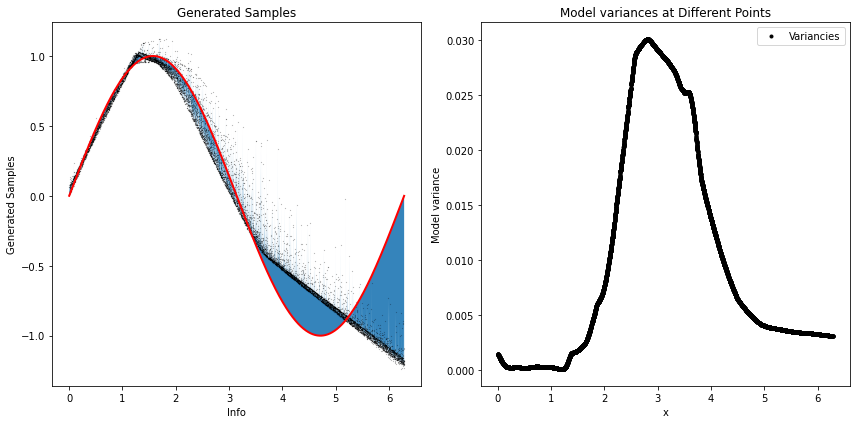

In [75]:
plot_sine(G, save_path = None)

In [190]:
# [el[0] for el in vals]
['Category 1', 'Category 2'], [lst1[0], lst2[0]]

(['Category 1', 'Category 2'], [1, 0])

In [79]:
# cats
# [el[0] for el in vals]

In [128]:
cats, vals = zip(*Weights_variance.items())


In [92]:
# vals
# cats

In [89]:
from modules.animate import animated_bar_var_plot

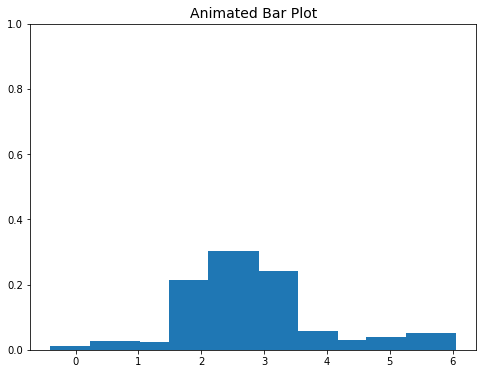

In [91]:
animated_bar_var_plot(Weights_variance, filename = save_path)

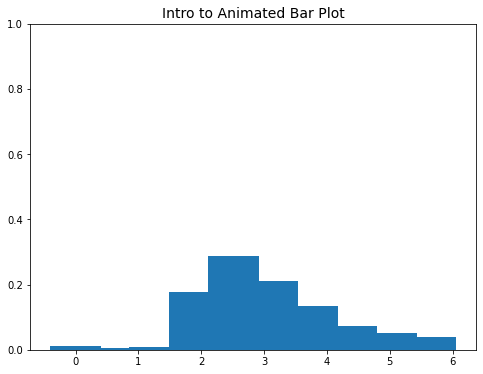

In [79]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
cats, vals = zip(*Weights_variance.items())
fig, axes = plt.subplots(figsize=(8, 6))
axes.set_ylim(0, 1)

bars = axes.bar(cats, [el[0] for el in vals])
cats, vals = zip(*Weights_variance.items())
def animate(i):
    for j in range(len(cats)):
        bars[j].set_height(vals[j][i])

plt.title("Intro to Animated Bar Plot", fontsize=14)
ani = FuncAnimation(fig, animate, frames=len(vals[0]), repeat=False)
HTML(ani.to_jshtml())




In [68]:
from typing import Dict, Callable, Tuple, List
def covert_dict2animate_format(weights_variance: dict) -> List[List]:
    names = weights_variance.keys()
    values = weights_variance.values()
    return list(names), list(values)
    

In [198]:
# covert_dict2animate_format(Weights_variance)

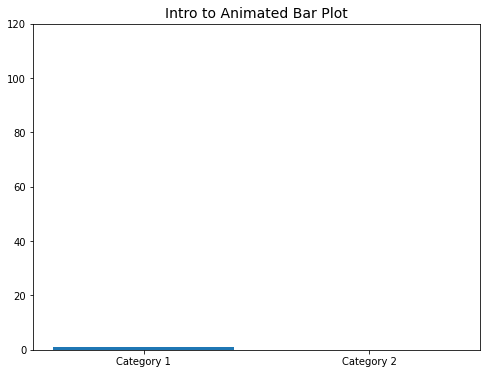

In [72]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, axes = plt.subplots(figsize=(8, 6))
axes.set_ylim(0, 120)

lst1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
lst2 = [0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]

bars = axes.bar(['Category 1', 'Category 2'], [lst1[0], lst2[0]])

def animate(i):
    bars[0].set_height(lst1[i])
    bars[1].set_height(lst2[i])

plt.title("Intro to Animated Bar Plot", fontsize=14)
ani = FuncAnimation(fig, animate, frames=len(lst1), repeat=False)
HTML(ani.to_jshtml())


In [36]:
q1, q2 = weights_variances(G)
q1, q2

({1: 0.016183618682155666,
  2: 0.018806433665996772,
  3: 0.06985694002369358,
  4: 0.13434583773446584,
  5: 0.28911277257802787,
  6: 0.22972140382321127,
  7: 0.06353128746379726,
  8: 0.05708069012271261,
  9: 0.05950891630869214,
  10: 0.06185209959724694},
 {1: 0.0,
  2: 0.6283185307179586,
  3: 1.2566370614359172,
  4: 1.8849555921538759,
  5: 2.5132741228718345,
  6: 3.141592653589793,
  7: 3.7699111843077517,
  8: 4.39822971502571,
  9: 5.026548245743669,
  10: 5.654866776461628})

In [66]:
r1, r2 = weights_variances(G)
r1, r2

({1: 0.002644329253079081,
  2: 0.0018797322437844827,
  3: 0.003721811401597339,
  4: 0.006826082518569738,
  5: 0.012869588342993829,
  6: 0.10386581523125141,
  7: 0.207430148807372,
  8: 0.2169833059643538,
  9: 0.22180804093609413,
  10: 0.2219711453009042},
 {1: 0.0,
  2: 0.6283185307179586,
  3: 1.2566370614359172,
  4: 1.8849555921538759,
  5: 2.5132741228718345,
  6: 3.141592653589793,
  7: 3.7699111843077517,
  8: 4.39822971502571,
  9: 5.026548245743669,
  10: 5.654866776461628})

In [83]:
t1 = {v: r1[k] for k, v in r2.items()}
t2 = {v: q1[k] for k, v in q2.items()}

In [84]:
t1, t2

({0.0: 0.002644329253079081,
  0.6283185307179586: 0.0018797322437844827,
  1.2566370614359172: 0.003721811401597339,
  1.8849555921538759: 0.006826082518569738,
  2.5132741228718345: 0.012869588342993829,
  3.141592653589793: 0.10386581523125141,
  3.7699111843077517: 0.207430148807372,
  4.39822971502571: 0.2169833059643538,
  5.026548245743669: 0.22180804093609413,
  5.654866776461628: 0.2219711453009042},
 {0.0: 0.016183618682155666,
  0.6283185307179586: 0.018806433665996772,
  1.2566370614359172: 0.06985694002369358,
  1.8849555921538759: 0.13434583773446584,
  2.5132741228718345: 0.28911277257802787,
  3.141592653589793: 0.22972140382321127,
  3.7699111843077517: 0.06353128746379726,
  4.39822971502571: 0.05708069012271261,
  5.026548245743669: 0.05950891630869214,
  5.654866776461628: 0.06185209959724694})

In [78]:
q1.values(), q2.values()

(dict_values([0.016183618682155666, 0.018806433665996772, 0.06985694002369358, 0.13434583773446584, 0.28911277257802787, 0.22972140382321127, 0.06353128746379726, 0.05708069012271261, 0.05950891630869214, 0.06185209959724694]),
 dict_values([0.0, 0.6283185307179586, 1.2566370614359172, 1.8849555921538759, 2.5132741228718345, 3.141592653589793, 3.7699111843077517, 4.39822971502571, 5.026548245743669, 5.654866776461628]))

In [88]:
t1

{0.0: 0.002644329253079081,
 0.6283185307179586: 0.0018797322437844827,
 1.2566370614359172: 0.003721811401597339,
 1.8849555921538759: 0.006826082518569738,
 2.5132741228718345: 0.012869588342993829,
 3.141592653589793: 0.10386581523125141,
 3.7699111843077517: 0.207430148807372,
 4.39822971502571: 0.2169833059643538,
 5.026548245743669: 0.22180804093609413,
 5.654866776461628: 0.2219711453009042}

<BarContainer object of 10 artists>

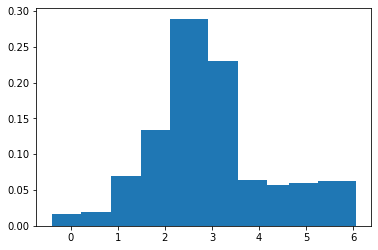

In [60]:
plt.bar(q2.values(), q1.values())

In [57]:
q1.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [58]:
q1.values()

dict_values([0.016183618682155666, 0.018806433665996772, 0.06985694002369358, 0.13434583773446584, 0.28911277257802787, 0.22972140382321127, 0.06353128746379726, 0.05708069012271261, 0.05950891630869214, 0.06185209959724694])

In [97]:
# pip install PyQt5


In [98]:
# pip install PySide2


In [26]:
from IPython.display import HTML
HTML(ani.to_jshtml())

NameError: name 'ani' is not defined

In [ ]:
ax.set_ylim(0, max(max(dic.values()) for dic in q))

In [24]:
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
%matplotlib qt

In [100]:
%matplotlib qt
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
axes.set_ylim(0, 150)
plt.style.use("seaborn")

lst1=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15 ]
lst2=[0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]

/var/folders/zw/rd1vhmbn34vgll3fpyhd2dwh0000gn/T/ipykernel_671/1713400341.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

q = [t1, t2]
i = 0

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = ax.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

# def update(frame):
    
#     xdata.append(frame)
#     ydata.append(np.sin(frame))
#     ln.set_data(xdata, ydata)
#     return ln,
# x_labels = list(q[0].keys())
def update(frame):
    heights = [q[i][key] for key in x_labels]
    for bar, height in zip(bars, heights):
        bar.set_height(height)
    return bars

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True, repeat = False)

HTML(ani.to_jshtml())

NameError: name 't1' is not defined

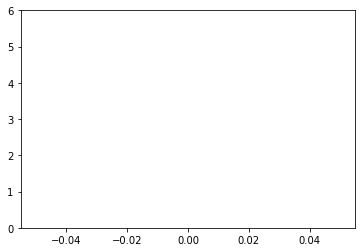

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Sample data for q
q = [{'A': 3, 'B': 5, 'C': 2}, {'A': 1, 'B': 4, 'C': 6}, {'A': 2, 'B': 3, 'C': 5}]

fig, ax = plt.subplots()
xdata, ydata = [], []
bars = ax.bar([], [])

def init():
    ax.set_ylim(0, max(max(dic.values()) for dic in q))
    return bars

def update(frame):
    values = q[frame].values()
    xdata.extend(range(len(values)))
    ydata.extend(values)
    
    for bar, h in zip(bars, values):
        bar.set_height(h)
    
    return bars

ani = FuncAnimation(fig, update, frames=range(len(q)),
                    init_func=init, blit=True, repeat=False)

plt.show()


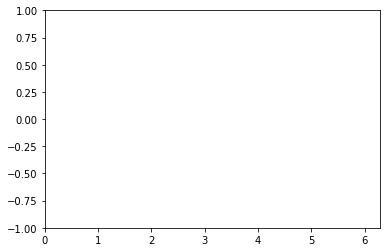

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = ax.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    print(frame, np.sin(frame))
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True, repeat = False)
# plt.show();

In [70]:
update

<function __main__.update(frame)>

In [215]:
# D_losses_final = []
# G_losses_final = []
# Variances = []
# # NUM_EPOCHS = NUM_EPOCHS//10
# for epoch in tqdm(range(1, NUM_EPOCHS+1)):           
#     D_losses, G_losses = [], []
#     for batch_idx in range(batches_per_epoch):
#         batch, mean_var = create_batch(
#                                 Generator = G,
#                                 batch_size = BATCH_SIZE,
#                                 get_variance = True,
#                                 repeat = 10,
#                                 num_samples = 128
#                             )
#         x, info = batch#x is y coordiante, we predict it, info is x corrdinate, its condition
#         D_losses.append(D_train(x, info))
#         G_losses.append(G_train(x))
#         Variances.append(mean_var)
#         # print(len(batch), var, x.size(), info.size())
#         # print(var)
#         # break
    
#     # for batch_idx, (x, info) in enumerate(train_loader):
#     #     D_losses.append(D_train(x, info))
#     #     G_losses.append(G_train(x))
        
#     D_losses_final.append(torch.mean(torch.FloatTensor(D_losses)))
#     G_losses_final.append(torch.mean(torch.FloatTensor(G_losses)))
    
#     if epoch % 20 == 0:
#         print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
#                 (epoch),
#                 NUM_EPOCHS,
#                 torch.mean(torch.FloatTensor(D_losses)),
#                 torch.mean(torch.FloatTensor(G_losses))
#                 )
#              )

In [116]:
q1, q2 = weights_variances(G)

# q


In [551]:
# weights_variancies

<function modules.optimal_batch.weights_variancies(G, num_beans=10)>

In [548]:
q2

{1: 0.0,
 2: 0.6283185307179586,
 3: 1.2566370614359172,
 4: 1.8849555921538759,
 5: 2.5132741228718345,
 6: 3.141592653589793,
 7: 3.7699111843077517,
 8: 4.39822971502571,
 9: 5.026548245743669,
 10: 5.654866776461628}

In [118]:
q1

{1: 0.008660152018654266,
 2: 0.009136536424053593,
 3: 0.05175037030646145,
 4: 0.11404620217661633,
 5: 0.13973310674543377,
 6: 0.11958336302381785,
 7: 0.11891246063171003,
 8: 0.13099686275494152,
 9: 0.14507482939156444,
 10: 0.16210611652674675}

In [262]:
# q

In [189]:
# q
a = torch.zeros(32, 1)
a.squeeze(-1).size()

torch.Size([32])

In [ ]:
    # calculate binary cross-entropy loss
    loss = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))

    # apply weights if provided
    if weights is not None:
        loss = loss * weights

    # take the mean across the batch
    loss = torch.mean(loss)
    
    loss = F.binary_cross_entropy_with_logits(y_pred, y_true, weight=weights)

The structure of having an outer function (weighted_interval_crossentropy) that returns an inner function (loss) is a way to create a closure, allowing the inner function to access variables from the outer function

In [607]:
import torch
import torch.nn.functional as F

def weighted_interval_crossentropy():
    """
    A weighted version of interval crossentropy loss for PyTorch.

    weights: torch tensor of shape batch_size
             torch.tensor([0.1, 0.3, 0.2,...]) # point one is in interval where the weight is 0.1, point 2 in interval the weight is 0.3, ...
    """
    # weights = torch.tensor(weights, requires_grad=False)
    

    def loss(y_pred, y_true, weights, conditional_info, from_logits=False):
        """
        y_true size: torch tensor (32, 1)
        y_pred size: torch tensor (32, 1)
        """
        weights = weights4batch(weights[0],
                                conditional_info = conditional_info,
                                bins_values = weights[1])# weights size: torch tensor (32)
        if from_logits:
            y_pred = F.softmax(y_pred, dim=-1)

        # clip to prevent NaN's and Inf's
        y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
        
        loss = F.binary_cross_entropy(y_pred, y_true, weight=weights.unsqueeze(-1))

        # # calculate loss
        # weights = weights.unsqueeze(-1)
        # print(f'''weights: {weights}, 
        #       y_true: {y_true},
        #       y_pred: {y_pred},
        #       torch.log(y_pred): {torch.log(y_pred)}''')
        # loss = y_true * torch.log(y_pred) * weights * 10
        # loss = -torch.sum(loss.squeeze(-1), -1)
        # print(f'loss: {loss}')
        return loss
    
    return loss


# Example usage:
# weights = [0.5, 2, 10]
# loss_function = weighted_categorical_crossentropy(weights)
# loss_value = loss_function(y_true, y_pred, )


In [477]:
# y_pred

In [473]:
torch.clamp(torch.tensor([0, 0.5, 1, 2, 3]), 1e-7, 1 - 1e-7)

tensor([1.0000e-07, 5.0000e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00])

In [468]:
torch.tensor([1, 2, 3]), torch.log(torch.tensor([0, 0.5, 1, 2, 3]))


(tensor([1, 2, 3]), tensor([   -inf, -0.6931,  0.0000,  0.6931,  1.0986]))

In [ ]:
# weights = [0.5, 2, 10]
loss_function = weighted_categorical_crossentropy(weights)
loss_value = loss_function(y_true, y_pred, )

In [538]:
q1

{1: 0.009937274450458401,
 2: 0.010061386916807866,
 3: 0.014705181638930415,
 4: 0.04883130833017653,
 5: 0.08768815862293726,
 6: 0.031174961779252098,
 7: 0.06065066189606768,
 8: 0.15052544915280178,
 9: 0.08279745939816543,
 10: 0.5036281578144026}

In [527]:
# def cross_

In [521]:
weighted_interval_crossentropy()

TypeError: weighted_interval_crossentropy() missing 1 required positional argument: 'weights'

In [ ]:
weighted_interval_crossentropy()

In [301]:
q1

{1: 0.009937274450458401,
 2: 0.010061386916807866,
 3: 0.014705181638930415,
 4: 0.04883130833017653,
 5: 0.08768815862293726,
 6: 0.031174961779252098,
 7: 0.06065066189606768,
 8: 0.15052544915280178,
 9: 0.08279745939816543,
 10: 0.5036281578144026}

In [516]:
def weights4batch(weights:dict, conditional_info, bins_values:dict):
    
    """
    Assign weights for every point based on conditional information and bins.

    Args:
    - weights (dict): Weights for every interval.
    - conditional_info (torch.Tensor): Tensor with conditional information (coordinate x of sine).
    - bins_values (dict): Bins values.

    Returns:
    - torch.tensor: Weights for every point that we have in condition.
    """
    weights_bins = []
    number_bins = len(bins_values.values())
    # print(f'conditional_info: {conditional_info}')
    sorted_info, indices = torch.sort(conditional_info, axis = 0)

    
    current_bin_id = 1
    # print(f'sorted_info and indices: {sorted_info}, {indices}')
    for i in range(conditional_info.size(0)):
        #find the next current_bin_id
        while current_bin_id <= number_bins - 1 and not (
            bins_values[current_bin_id] < sorted_info[i].item() < bins_values[current_bin_id + 1]
        ):
            current_bin_id += 1
            
        weights_bins.append(weights[current_bin_id])
        
    weights_bins = torch.tensor(weights_bins)
    sorted_weights = weights_bins[torch.argsort(indices.view(-1))]
    # print(torch.argsort(indices.view(-1)))
    return sorted_weights


                
            
            
            

        
        
    
    

In [436]:
conditional_info_0 = 2 * math.pi * torch.rand(4).view(-1, 1).to(device)
# conditional_info_0

In [437]:
q1, q2
# conditional_info_0
# q2

({1: 0.008660152018654266,
  2: 0.009136536424053593,
  3: 0.05175037030646145,
  4: 0.11404620217661633,
  5: 0.13973310674543377,
  6: 0.11958336302381785,
  7: 0.11891246063171003,
  8: 0.13099686275494152,
  9: 0.14507482939156444,
  10: 0.16210611652674675},
 {1: 0.0,
  2: 0.6283185307179586,
  3: 1.2566370614359172,
  4: 1.8849555921538759,
  5: 2.5132741228718345,
  6: 3.141592653589793,
  7: 3.7699111843077517,
  8: 4.39822971502571,
  9: 5.026548245743669,
  10: 5.654866776461628})

In [1]:
q2

NameError: name 'q2' is not defined

In [438]:
conditional_info_0

tensor([[5.8562],
        [1.1744],
        [0.0862],
        [1.2314]])

In [439]:
e = weights4batch(q1, conditional_info_0, q2)
# e[1]
e

tensor([0.1621, 0.0091, 0.0087, 0.0091], dtype=torch.float64)

In [389]:
e.size()

torch.Size([4])

In [517]:
# e[1][e[0]]
# e[1]
# [e[0]]

In [443]:
# indices
# bi

In [504]:
r = torch.log(torch.tensor([torch.tensor(i) for i in range(1, 33)]))

In [502]:
sorted, indices = torch.sort(fi, axis = 0)

In [509]:
e.size(), r.size()

(torch.Size([32, 1]), torch.Size([32]))

In [511]:
# r
e.view(-1)

tensor([0.0147, 0.0488, 0.0877, 0.0099, 0.1505, 0.0607, 0.0312, 0.0488, 0.0099,
        0.0607, 0.0099, 0.0877, 0.5036, 0.0877, 0.0147, 0.0147, 0.1505, 0.5036,
        0.1505, 0.0312, 0.0877, 0.0607, 0.0877, 0.0312, 0.0101, 0.0877, 0.0147,
        0.0147, 0.0101, 0.0488, 0.0828, 0.0877], dtype=torch.float64)

In [519]:
e

tensor([0.0877, 0.1505, 0.0828, 0.1505, 0.0101, 0.5036, 0.1505, 0.1505, 0.0147,
        0.5036, 0.0147, 0.0607, 0.0488, 0.0828, 0.1505, 0.0488, 0.0828, 0.5036,
        0.0147, 0.0607, 0.0101, 0.0828, 0.0312, 0.0488, 0.0488, 0.5036, 0.0099,
        0.0877, 0.0147, 0.0877, 0.0101, 0.1505], dtype=torch.float64)

In [518]:
r * e
# y_true * torch.log(y_pred) * weights

tensor([0.0000, 0.1043, 0.0910, 0.2087, 0.0162, 0.9024, 0.2929, 0.3130, 0.0323,
        1.1596, 0.0353, 0.1507, 0.1252, 0.2185, 0.4076, 0.1354, 0.2346, 1.4557,
        0.0433, 0.1817, 0.0306, 0.2559, 0.0977, 0.1552, 0.1572, 1.6409, 0.0328,
        0.2922, 0.0495, 0.2982, 0.0346, 0.5217], dtype=torch.float64)

In [267]:
fi = 2 * math.pi * torch.rand(32).view(-1, 1).to(device)

In [286]:
# fi

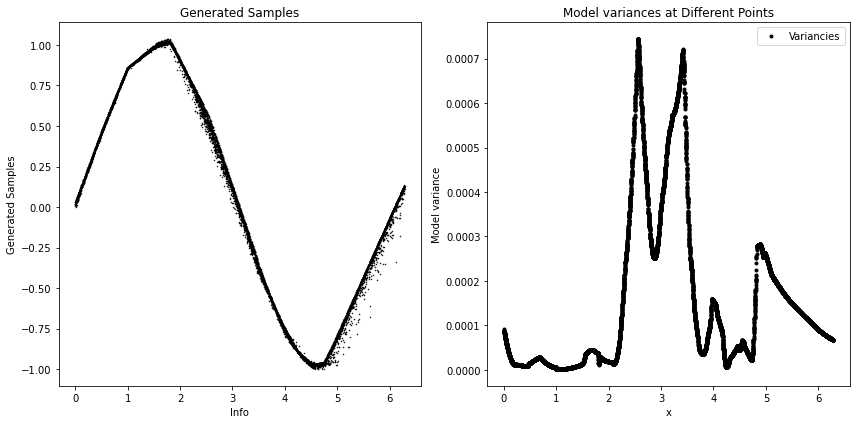

In [186]:
plot_sine(G, save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/tests/', name = 'base_gan__base_training__1')


In [159]:
pwd

'/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty'

## Test

In [736]:
# latent_space_samples = torch.randn(1000, 2)
num_samples = 10000
latent_space_samples = torch.randn(num_samples, 1)
# info = 8 * math.pi * torch.rand(num_samples).view(-1, 1) - 4 * math.pi
info = 2 * math.pi * torch.rand(num_samples).view(-1, 1)
generated_samples = G(latent_space_samples, info)



In [737]:
points_x, res = calculate_variance(G, repeat = 10, num_samples = 10000)

##### 4
> num_samples = 128, lr = 0.0005

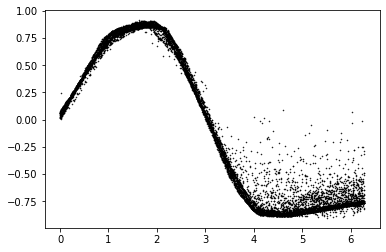

In [691]:
generated_samples = generated_samples.detach()
plt.plot(info, generated_samples, 'ko', markersize = 0.5)

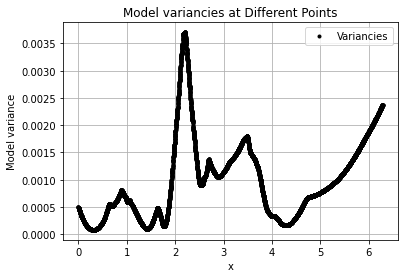

In [693]:
# Plot the graph
plt.plot(points_x, res, 'ko', markersize = 3, label='Variancies')
plt.xlabel('x')
plt.ylabel('Model variance')
plt.title('Model variancies at Different Points')
plt.legend()
plt.grid(True)
plt.show()

##### 3
> num_samples = 128

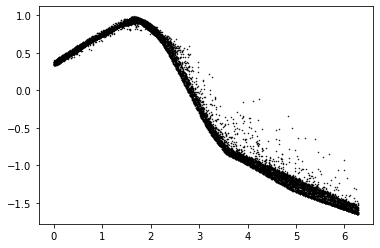

In [738]:
generated_samples = generated_samples.detach()
plt.plot(info, generated_samples, 'ko', markersize = 0.5)

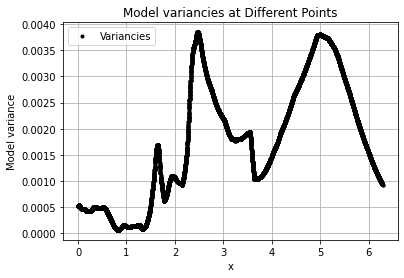

In [739]:
# Plot the graph
plt.plot(points_x, res, 'ko', markersize = 3, label='Variancies')
plt.xlabel('x')
plt.ylabel('Model variance')
plt.title('Model variancies at Different Points')
plt.legend()
plt.grid(True)
plt.show()

##### 2

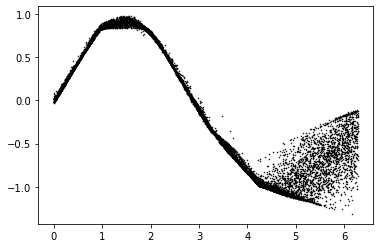

In [723]:
generated_samples = generated_samples.detach()
plt.plot(info, generated_samples, 'ko', markersize = 0.5)

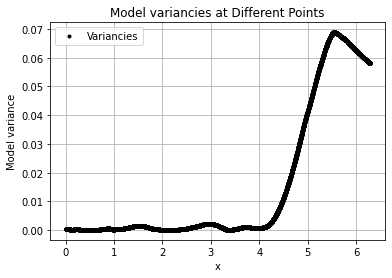

In [724]:
# Plot the graph
plt.plot(points_x, res, 'ko', markersize = 3, label='Variancies')
plt.xlabel('x')
plt.ylabel('Model variance')
plt.title('Model variancies at Different Points')
plt.legend()
plt.grid(True)
plt.show()

##### 1

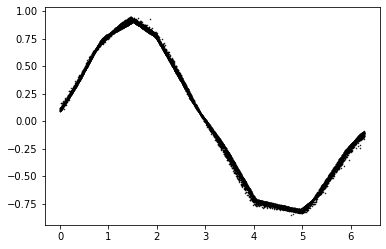

In [647]:
generated_samples = generated_samples.detach()
plt.plot(info, generated_samples, 'ko', markersize = 0.5)

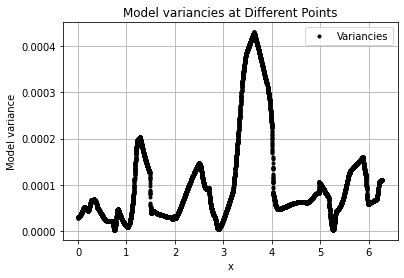

In [652]:
# Plot the graph
plt.plot(points_x, res, 'ko', markersize = 3, label='Variancies')
plt.xlabel('x')
plt.ylabel('Model variance')
plt.title('Model variancies at Different Points')
plt.legend()
plt.grid(True)
plt.show()

#### basic

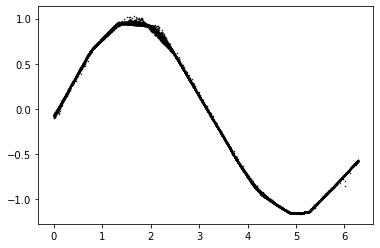

In [627]:
generated_samples = generated_samples.detach()
plt.plot(info, generated_samples, 'ko', markersize = 0.5)

In [628]:
points_x, res = calculate_variance(G, repeat = 1000, num_samples = 10000)

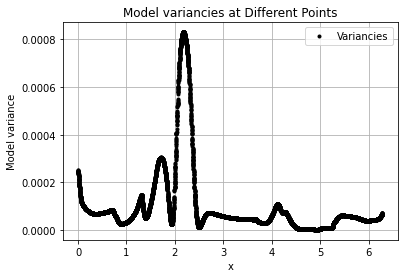

In [629]:
# Plot the graph
plt.plot(points_x, res, 'ko', markersize = 3, label='Variancies')
plt.xlabel('x')
plt.ylabel('Model variance')
plt.title('Model variancies at Different Points')
plt.legend()
plt.grid(True)
plt.show()

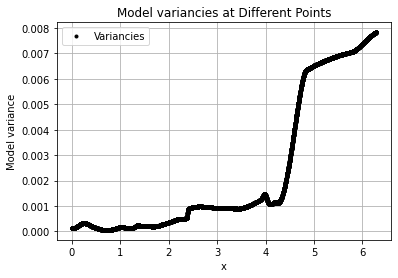

In [593]:
create_batch(G, batch_size = 10,                  
                 get_variance = True,
                 repeat = 10,
                 num_samples = 64)

([tensor([-0.5870, -0.5463, -0.4855, -0.3768, -0.2345, -0.1610, -0.1554, -0.1314,
          -0.1279, -0.0518]),
  tensor([[5.6558],
          [5.7053],
          [5.7763],
          [5.8969],
          [6.0465],
          [6.1215],
          [6.1272],
          [6.1514],
          [6.1550],
          [6.2314]])],
 0.0038968222012272236)